In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)
%config InlineBackend.figure_format = 'retina'


import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
AT =pd.read_csv('/content/drive/MyDrive/adverts.csv')

#UNDERSTANDING THE DATA

In [4]:
print(AT.head())

   public_reference   mileage reg_code standard_colour standard_make  \
0   202006039777689       0.0      NaN            Grey         Volvo   
1   202007020778260  108230.0       61            Blue        Jaguar   
2   202007020778474    7800.0       17            Grey         SKODA   
3   202007080986776   45000.0       16           Brown      Vauxhall   
4   202007161321269   64000.0       64            Grey    Land Rover   

      standard_model vehicle_condition  year_of_registration  price  \
0               XC90               NEW                   NaN  73970   
1                 XF              USED                2011.0   7000   
2               Yeti              USED                2017.0  14000   
3              Mokka              USED                2016.0   7995   
4  Range Rover Sport              USED                2015.0  26995   

   body_type  crossover_car_and_van              fuel_type  
0        SUV                  False  Petrol Plug-in Hybrid  
1     Saloon      

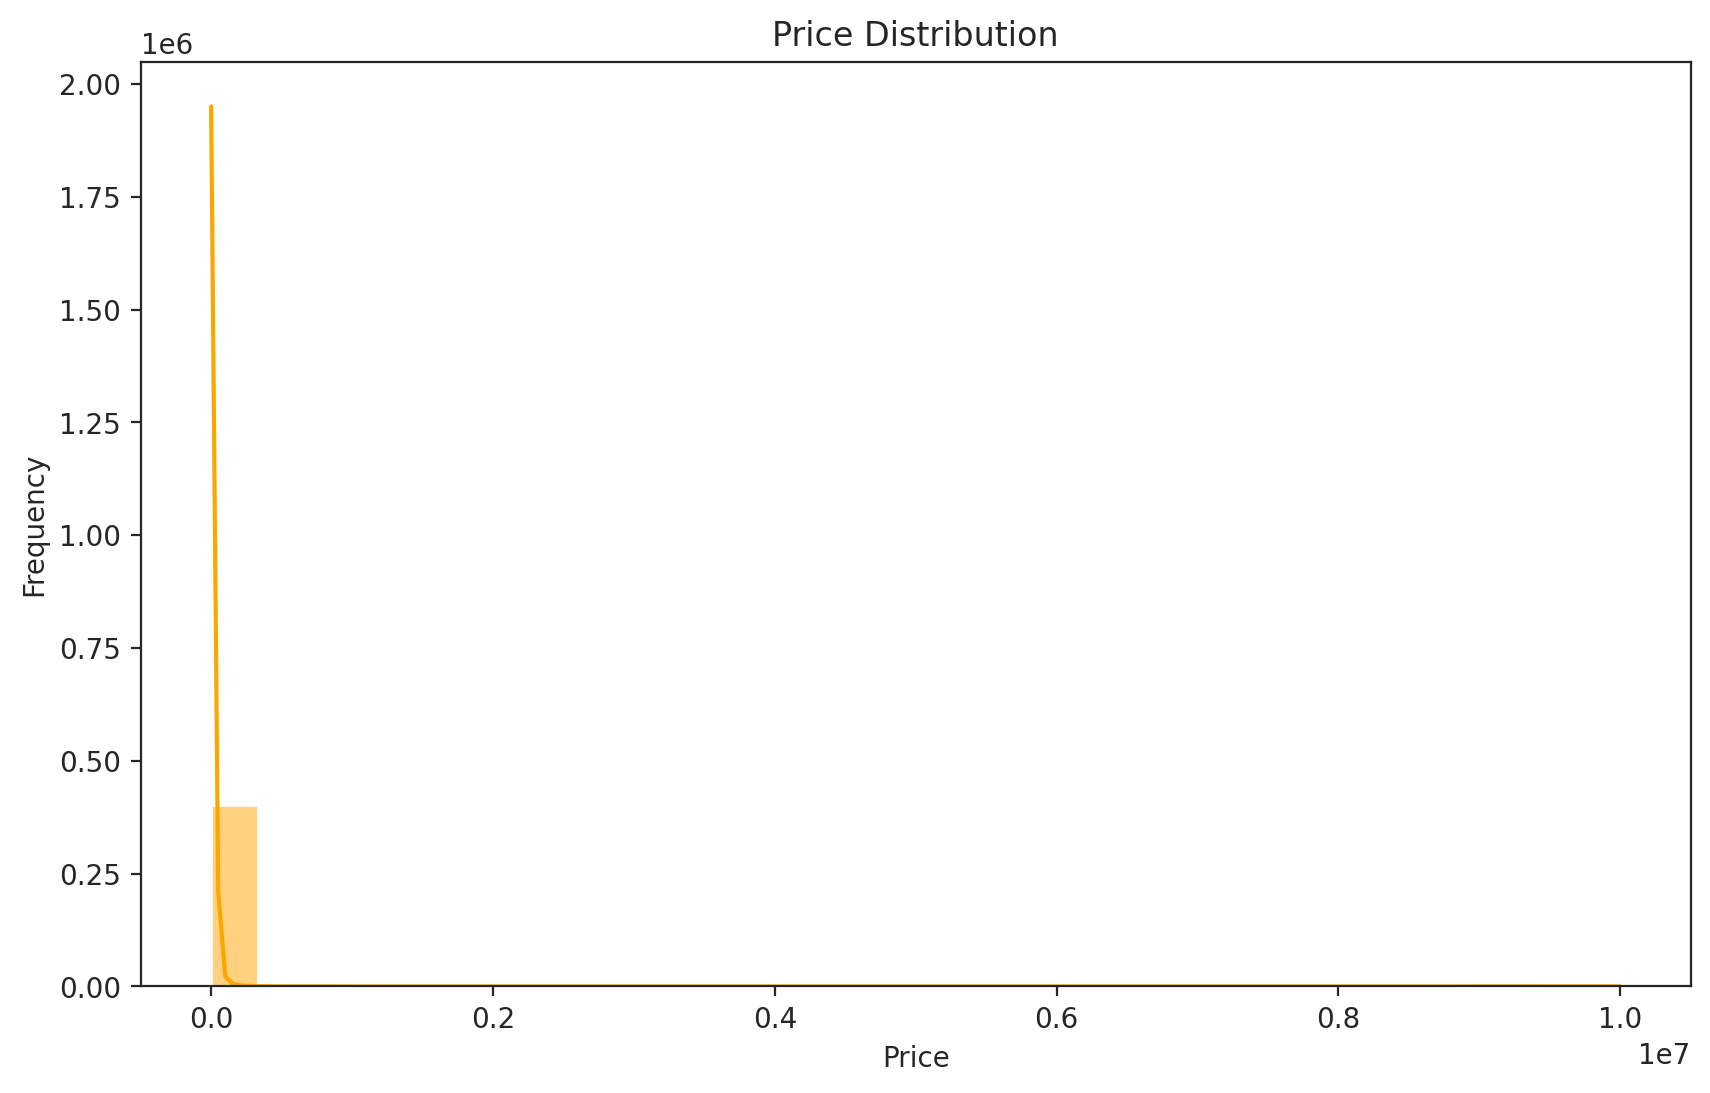

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(AT['price'], kde=True, bins=30, color="ORANGE")
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

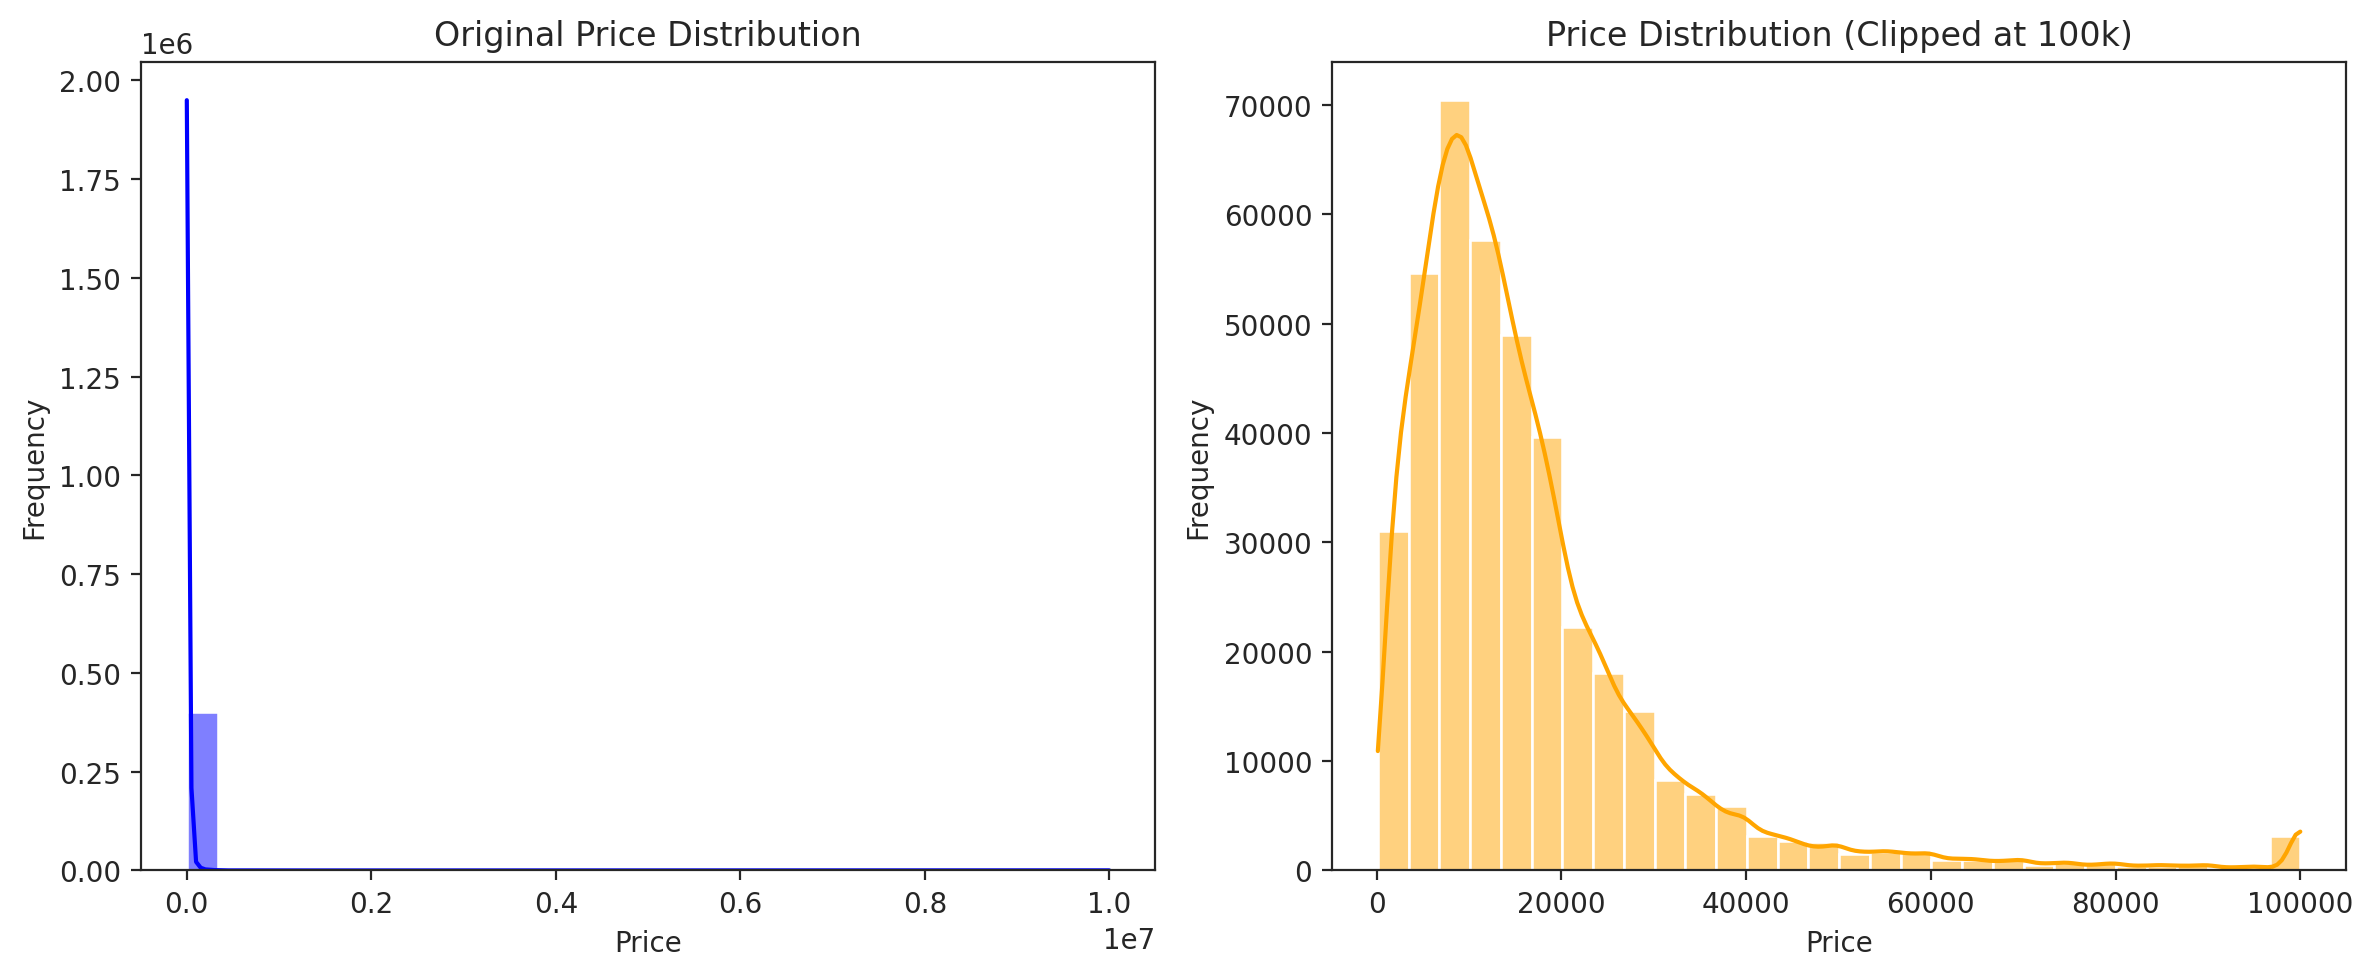

In [6]:
# prompt: side by side sidtrubtion plotss for price but with orgianl price distribtion and price clipped at 100k

import matplotlib.pyplot as plt
# Create a copy of the price column and clip it at 100k
AT['clipped_price'] = AT['price'].clip(upper=100000)

# Create side-by-side distribution plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original price distribution
sns.histplot(AT['price'], kde=True, bins=30, color="blue", ax=axes[0])
axes[0].set_title("Original Price Distribution")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")

# Clipped price distribution
sns.histplot(AT['clipped_price'], kde=True, bins=30, color="orange", ax=axes[1])
axes[1].set_title("Price Distribution (Clipped at 100k)")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Frequency")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [7]:
AT.tail()

public_reference   mileage reg_code standard_colour standard_make  \
402000   202010315652942    5179.0       69            Grey       Peugeot   
402001   202010315657341  110000.0       59             Red       Peugeot   
402002   202010315659271   52760.0       62           White        Nissan   
402003   202011015662436   10250.0       65             Red        Abarth   
402004   201512149444029   14000.0       14          Silver          Audi   

       standard_model vehicle_condition  year_of_registration  price  \
402000            208              USED                2019.0  10595   
402001            107              USED                2009.0   2000   
402002        Qashqai              USED                2012.0   7250   
402003            595              USED                2015.0  11490   
402004       A4 Avant              USED                2014.0  20520   

        body_type  crossover_car_and_van fuel_type  clipped_price  
402000  Hatchback                  False    Petrol          10595  
402001  Hatchback                  False    Petrol           2000  
402002        SUV                  False    Petrol           7250  
402003  Hatchback                  False    Petrol          11490  
402004     Estate                  False    Diesel          20520

In [8]:
print(AT.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
 12  clipped_price          402005 non-null  int64  
dtypes: bool(1), float64(2), int64(3), object(7)
memory usage: 37.2+ MB
None


In [9]:
AT['price'].describe()

count    4.020050e+05
mean     1.734197e+04
std      4.643746e+04
min      1.200000e+02
25%      7.495000e+03
50%      1.260000e+04
75%      2.000000e+04
max      9.999999e+06
Name: price, dtype: float64

In [10]:
pd.options.display.float_format = '{:.2f}'.format
print(AT['price'].describe())

count    402005.00
mean      17341.97
std       46437.46
min         120.00
25%        7495.00
50%       12600.00
75%       20000.00
max     9999999.00
Name: price, dtype: float64


In [11]:
print(AT.isnull().sum())

public_reference             0
mileage                    127
reg_code                 31857
standard_colour           5378
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration     33311
price                        0
body_type                  837
crossover_car_and_van        0
fuel_type                  601
clipped_price                0
dtype: int64


In [12]:
top_10_expensive = AT.sort_values('price', ascending=False).head(10)
top_10_expensive


public_reference  mileage reg_code standard_colour standard_make  \
147188   202009103539048   100.00      NaN            Grey      Maserati   
336536   202006180262926  4400.00      NaN           White       Porsche   
305436   201812223434109  3600.00      NaN            Grey   Lamborghini   
141833   202007050883898 87450.00      NaN             Red       Ferrari   
336202   202001226429470   950.00      NaN           Black       Ferrari   
252505   202008112331147 46300.00      NaN            Blue       Ferrari   
198060   202008252907180   300.00       17             NaN       Ferrari   
51741    202002257718775  4400.00       14           Black       Bugatti   
64910    202006039766650   189.00      NaN           Black       McLaren   
223835   202007081011555  1000.00       67            Blue       Bugatti   

       standard_model vehicle_condition  year_of_registration    price  \
147188           3500              USED                   NaN  9999999   
336536            959              USED                   NaN  9999999   
305436          Miura              USED                   NaN  9999999   
141833            250              USED                   NaN  9999999   
336202      LaFerrari              USED                   NaN  9999999   
252505            275              USED                   NaN  9999999   
198060      LaFerrari              USED               2017.00  3799995   
51741          Veyron              USED               2014.00  2850000   
64910              P1              USED                   NaN  2695000   
223835         Chiron              USED               2018.00  2500000   

          body_type  crossover_car_and_van              fuel_type  \
147188  Convertible                  False                 Petrol   
336536        Coupe                  False                 Petrol   
305436        Coupe                  False                 Petrol   
141833        Coupe                  False                 Petrol   
336202        Coupe                  False                 Petrol   
252505        Coupe                  False                 Petrol   
198060          NaN                  False                    NaN   
51741         Coupe                  False                 Petrol   
64910         Coupe                  False  Petrol Plug-in Hybrid   
223835        Coupe                  False                 Petrol   

        clipped_price  
147188         100000  
336536         100000  
305436         100000  
141833         100000  
336202         100000  
252505         100000  
198060         100000  
51741          100000  
64910          100000  
223835         100000

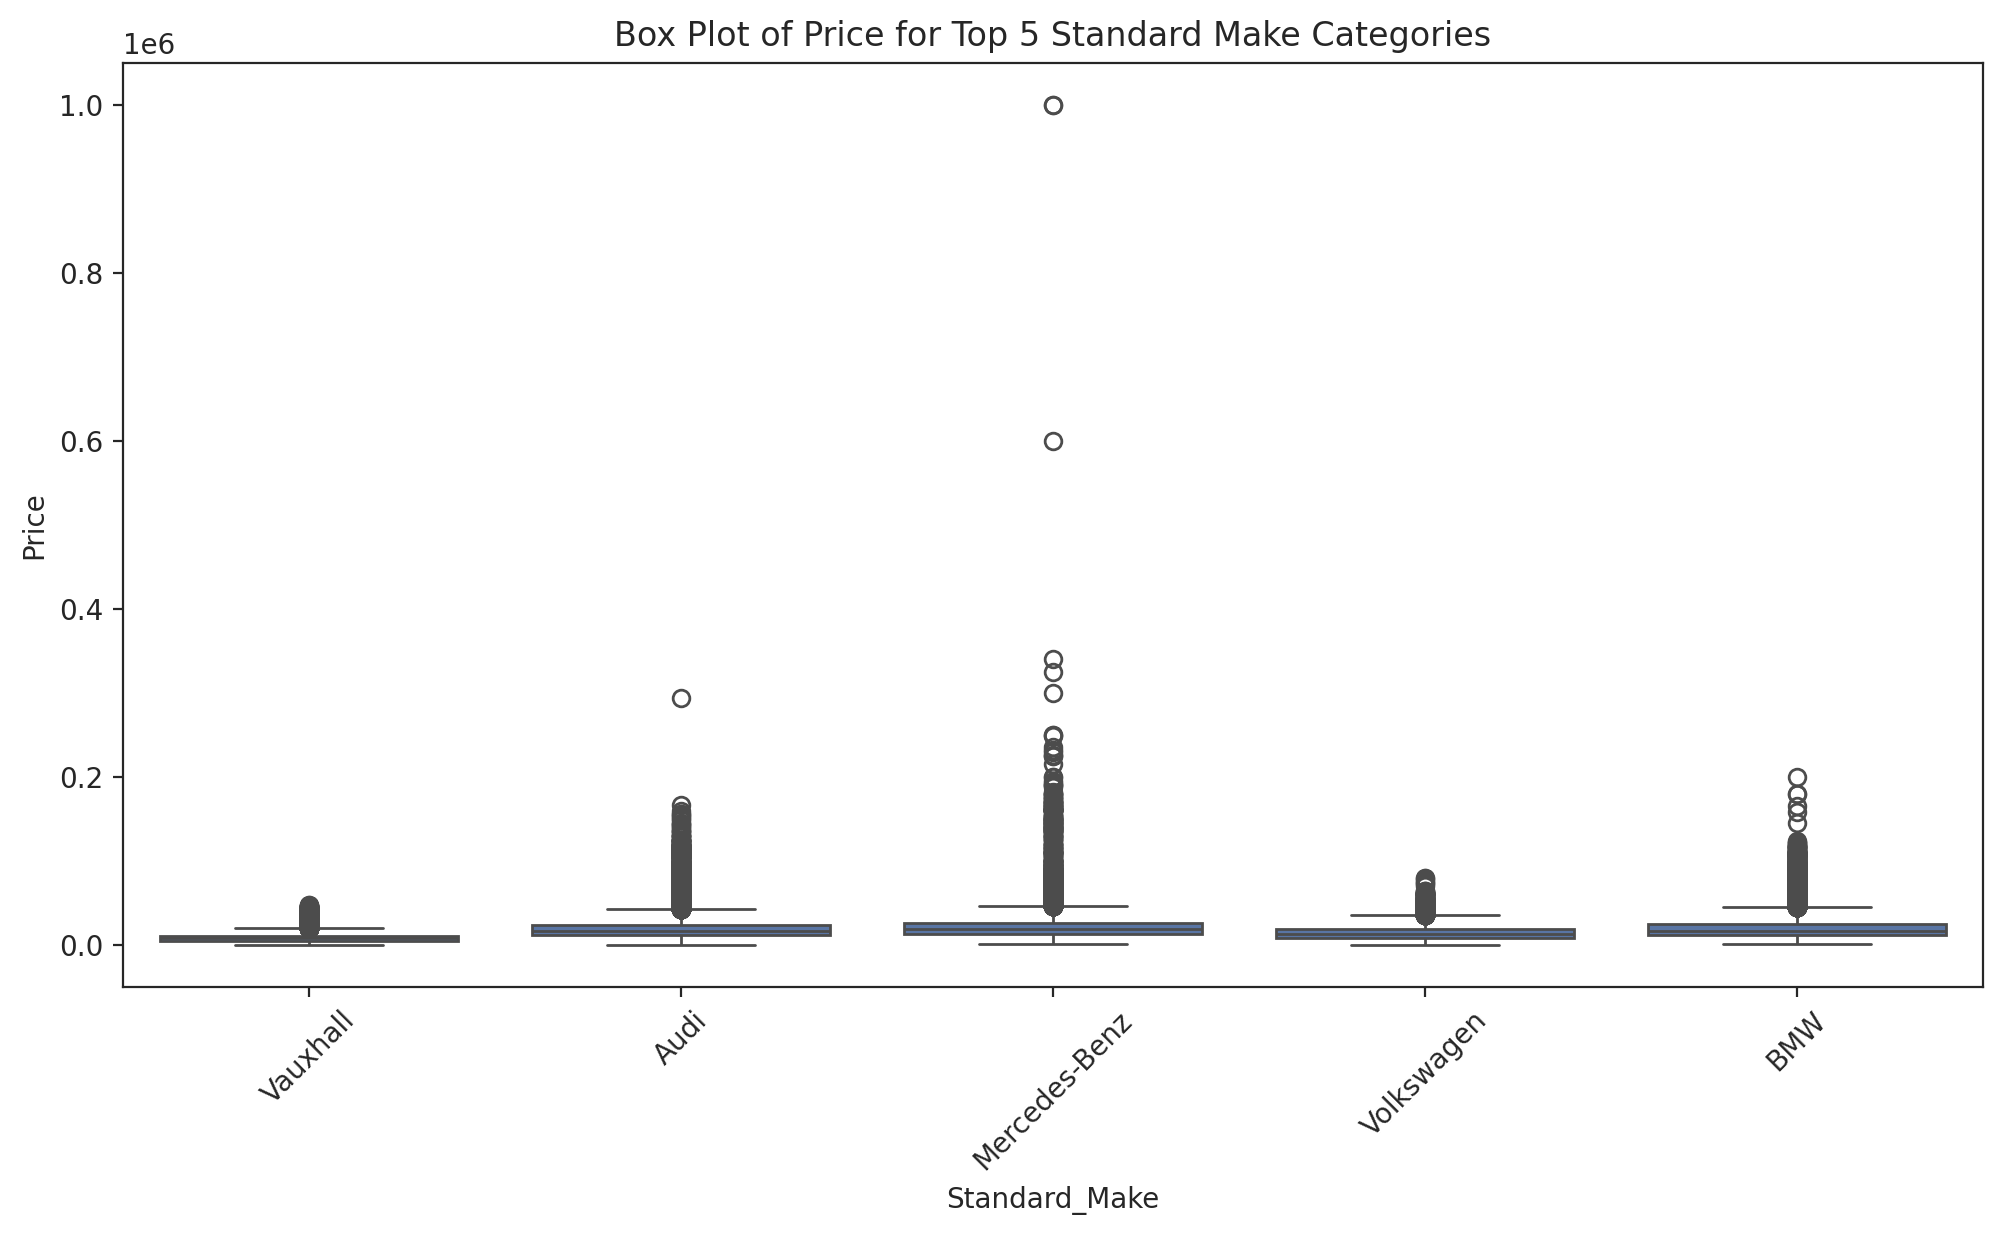

In [13]:
top_5_categories = AT['standard_make'].value_counts().head(5).index


filtered_data = AT[AT['standard_make'].isin(top_5_categories)]


plt.figure(figsize=(12, 6))
sns.boxplot(x='standard_make', y='price', data=filtered_data)
plt.title("Box Plot of Price for Top 5 Standard Make Categories")
plt.xlabel("Standard_Make")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

<ipython-input-14-b52e8c9446ba>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['price_clipped'] = filtered_data['price'].clip(upper=upper_limit)


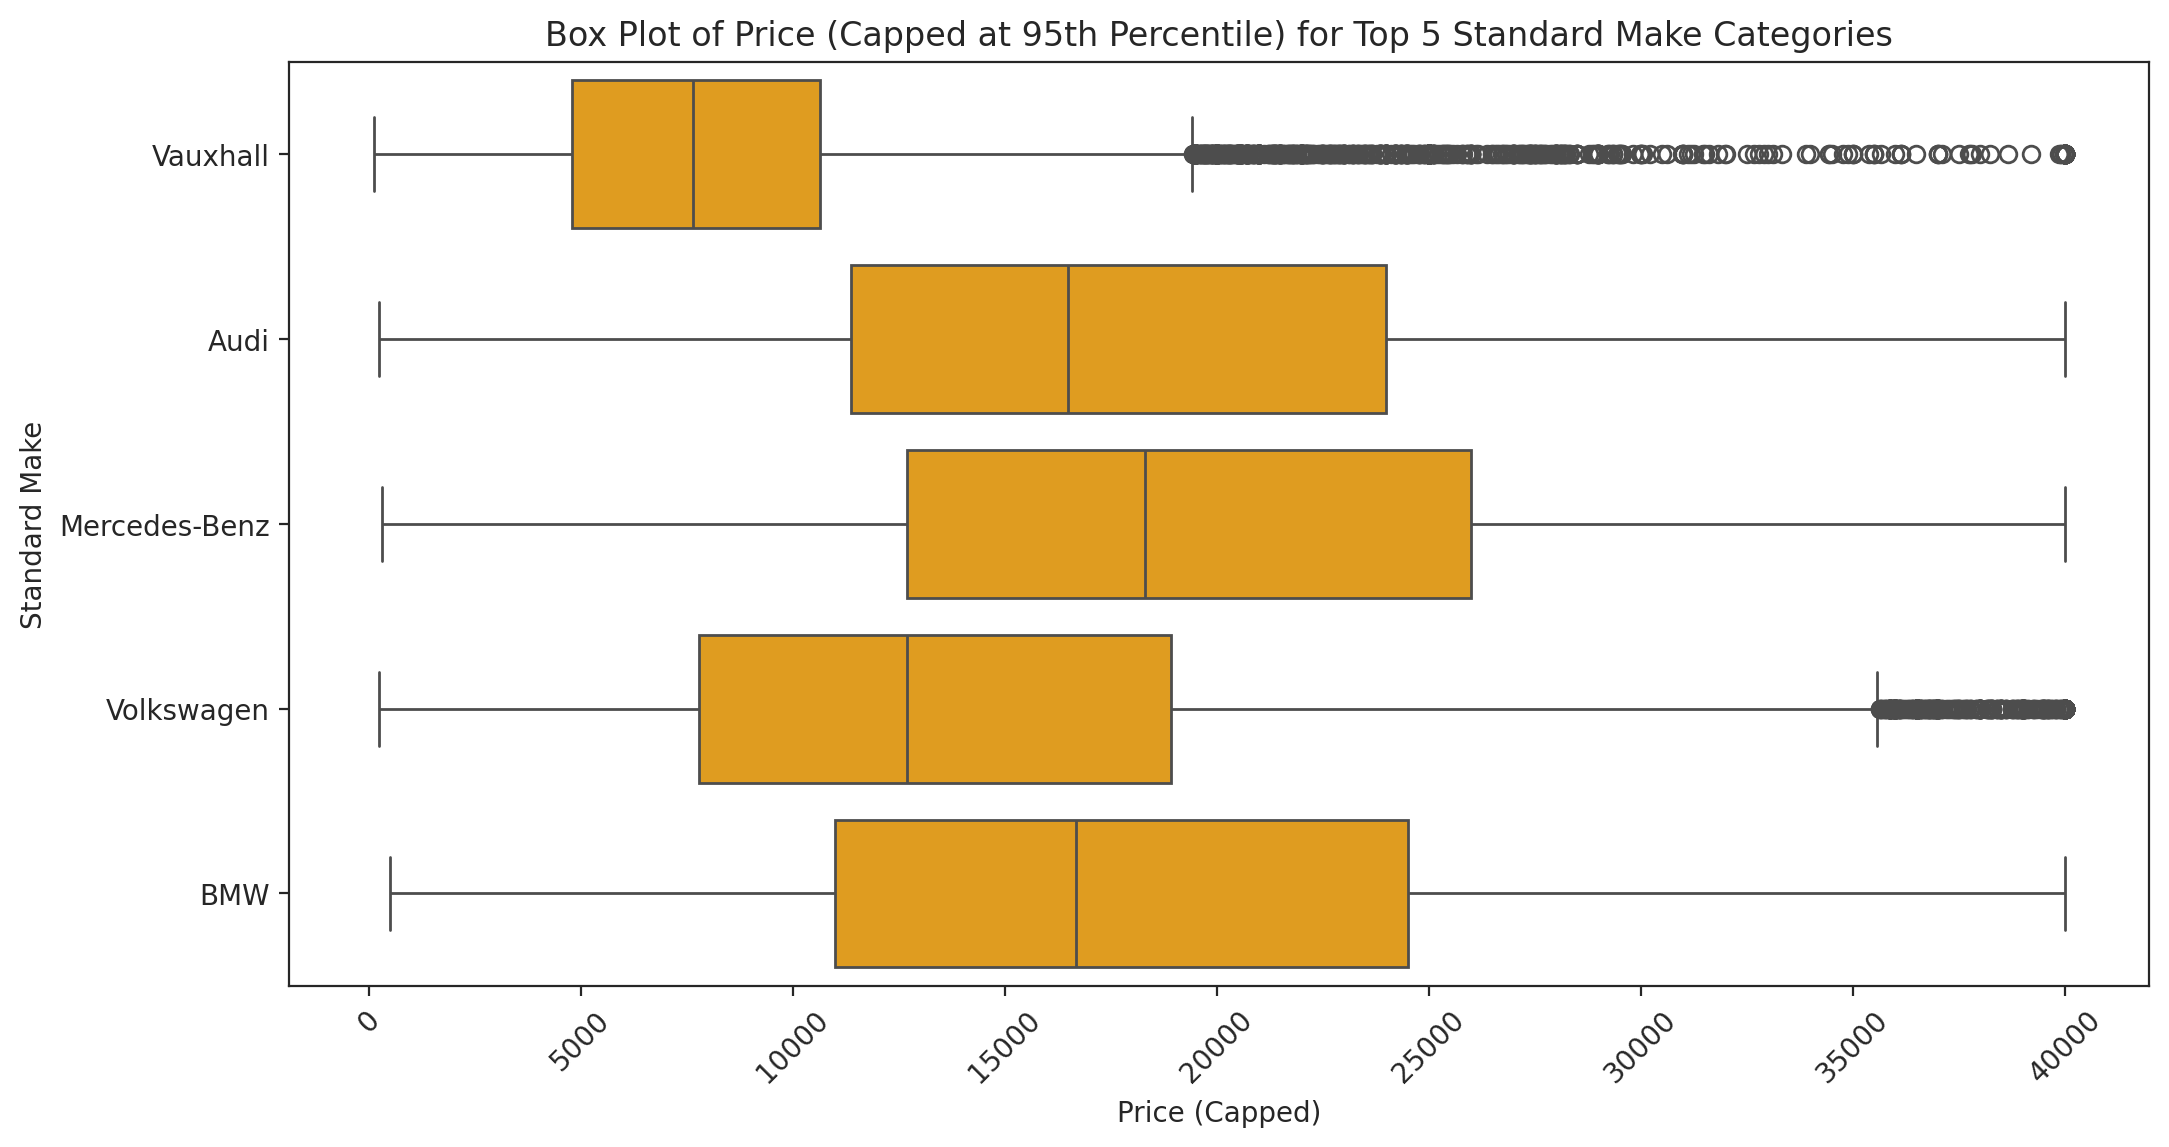

In [14]:
upper_limit = filtered_data['price'].quantile(0.95)


filtered_data['price_clipped'] = filtered_data['price'].clip(upper=upper_limit)


plt.figure(figsize=(12, 6))
sns.boxplot(x='price_clipped', y='standard_make', data=filtered_data, color='orange')
plt.title("Box Plot of Price (Capped at 95th Percentile) for Top 5 Standard Make Categories")
plt.xlabel("Price (Capped)")
plt.ylabel("Standard Make")
plt.xticks(rotation=45)
plt.show()

In [15]:
AT['standard_make'].value_counts(True)

standard_make
BMW              0.09
Audi             0.09
Volkswagen       0.09
Vauxhall         0.08
Mercedes-Benz    0.08
                 ... 
Sebring          0.00
Radical          0.00
Pontiac          0.00
Mitsuoka         0.00
Custom Vehicle   0.00
Name: proportion, Length: 110, dtype: float64

#DATA CLEANING

Price- heavy skew, outliers handled

In [16]:
max_price = AT['price'].max()

max_price_rows = AT[AT['price'] == max_price]

print(max_price_rows)

        public_reference  mileage reg_code standard_colour standard_make  \
141833   202007050883898 87450.00      NaN             Red       Ferrari   
147188   202009103539048   100.00      NaN            Grey      Maserati   
252505   202008112331147 46300.00      NaN            Blue       Ferrari   
305436   201812223434109  3600.00      NaN            Grey   Lamborghini   
336202   202001226429470   950.00      NaN           Black       Ferrari   
336536   202006180262926  4400.00      NaN           White       Porsche   

       standard_model vehicle_condition  year_of_registration    price  \
141833            250              USED                   NaN  9999999   
147188           3500              USED                   NaN  9999999   
252505            275              USED                   NaN  9999999   
305436          Miura              USED                   NaN  9999999   
336202      LaFerrari              USED                   NaN  9999999   
336536            959  

In [17]:
AT['price'] = AT['price'].clip(upper=100000)

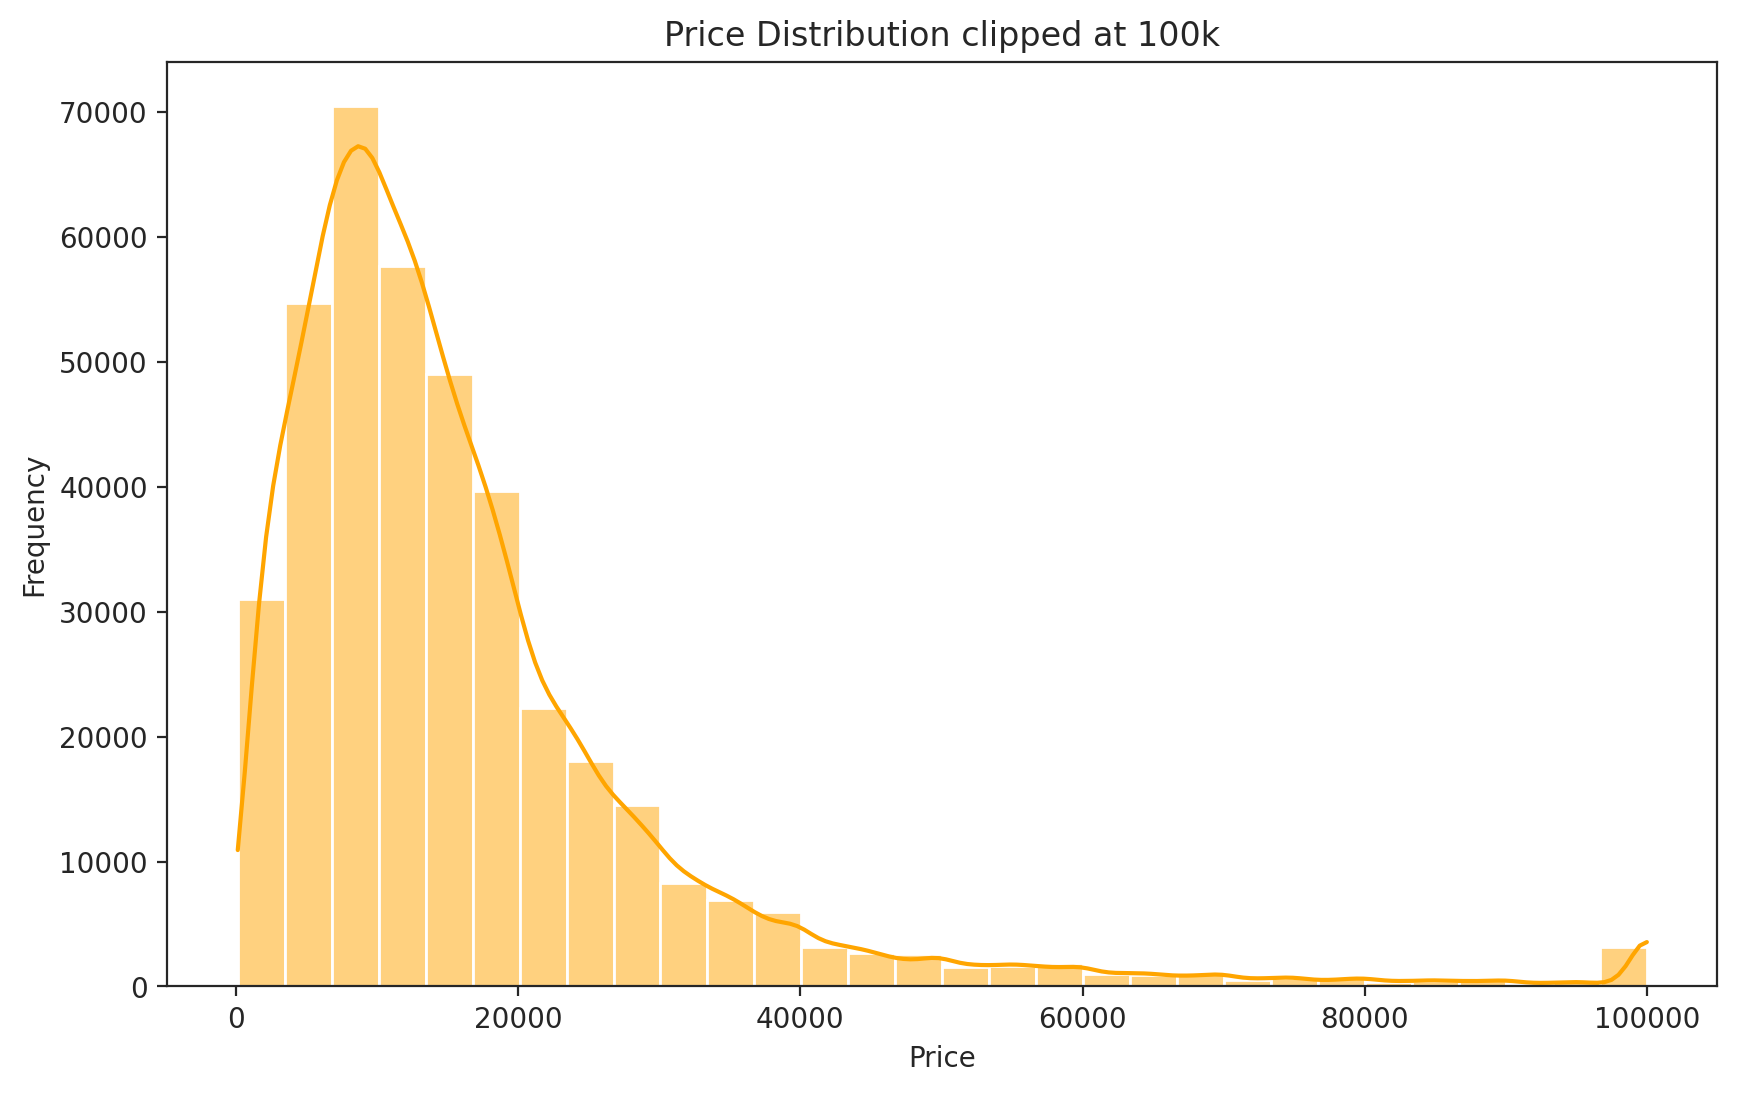

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(AT['price'], kde=True, bins=30, color="ORANGE")
plt.title("Price Distribution clipped at 100k")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [19]:
# Create a copy of the DataFrame AT
AT_cleaned = AT.copy()

In [20]:
AT_cleaned['price'] = AT_cleaned['price'].clip(upper=100000)


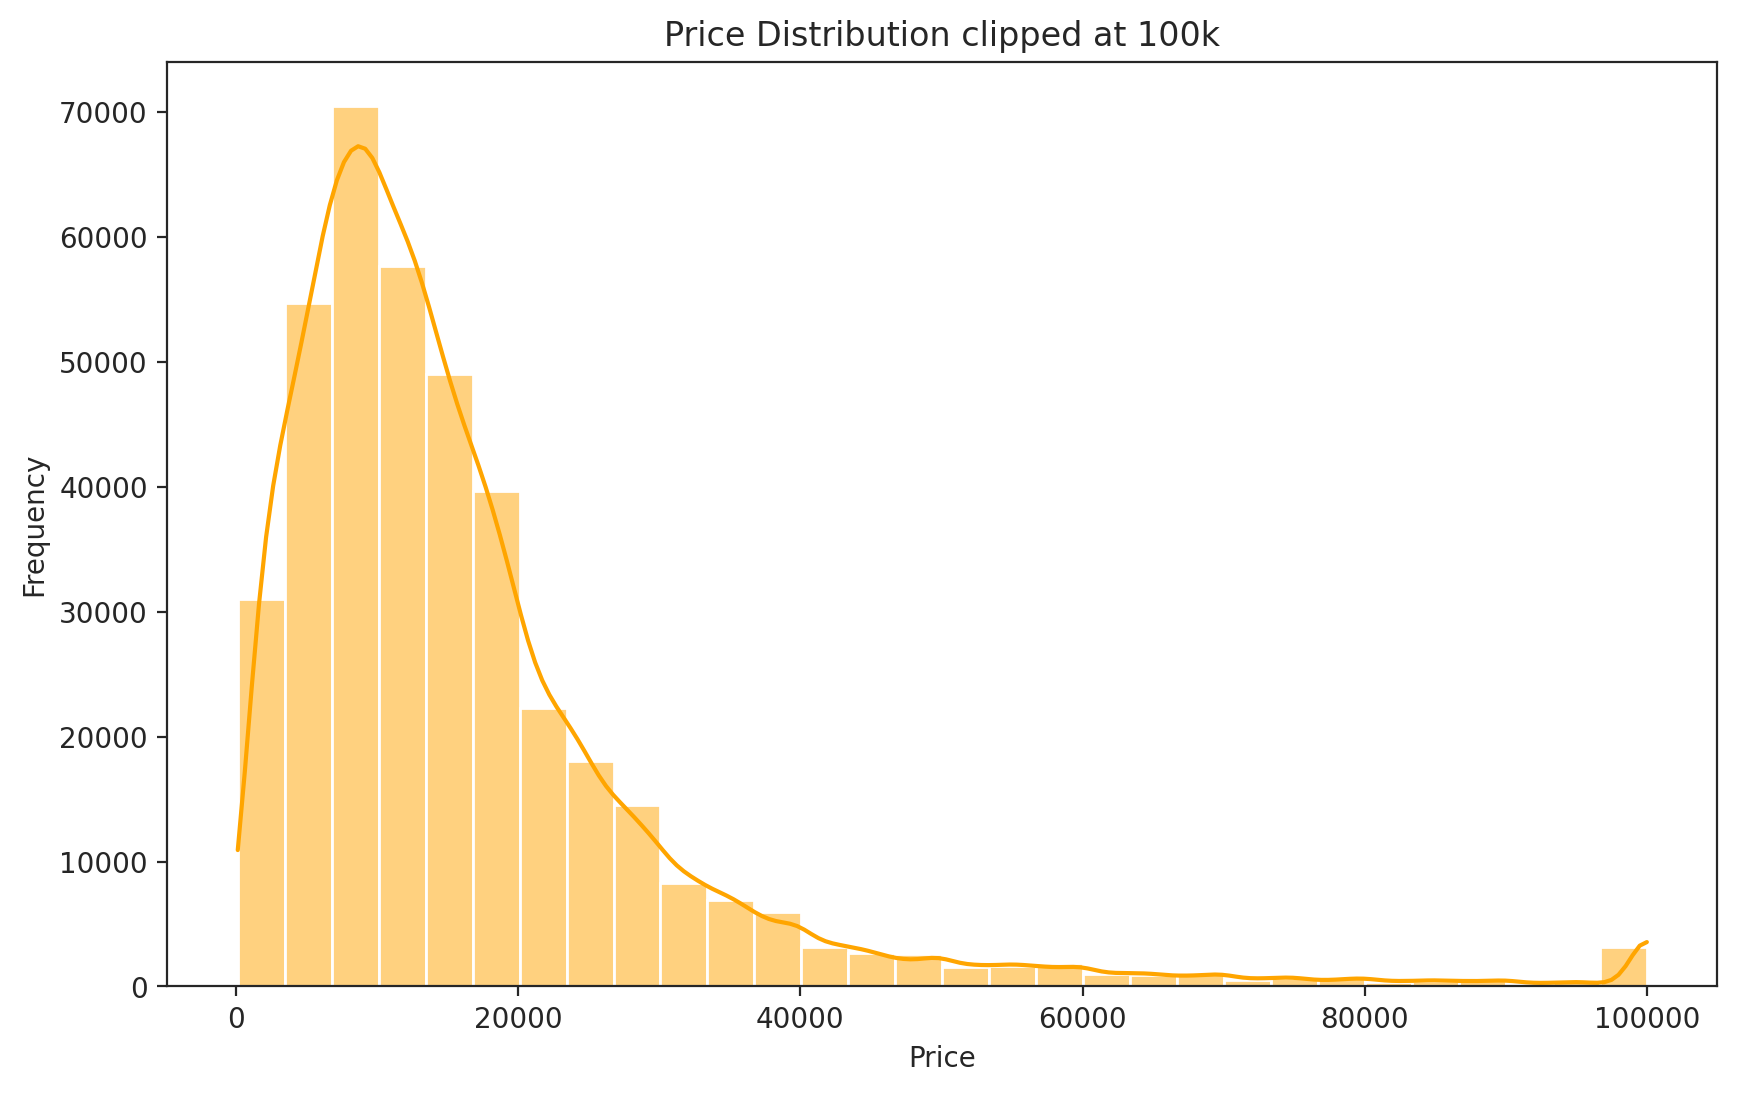

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(AT_cleaned['price'], kde=True, bins=30, color="ORANGE")
plt.title("Price Distribution clipped at 100k")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

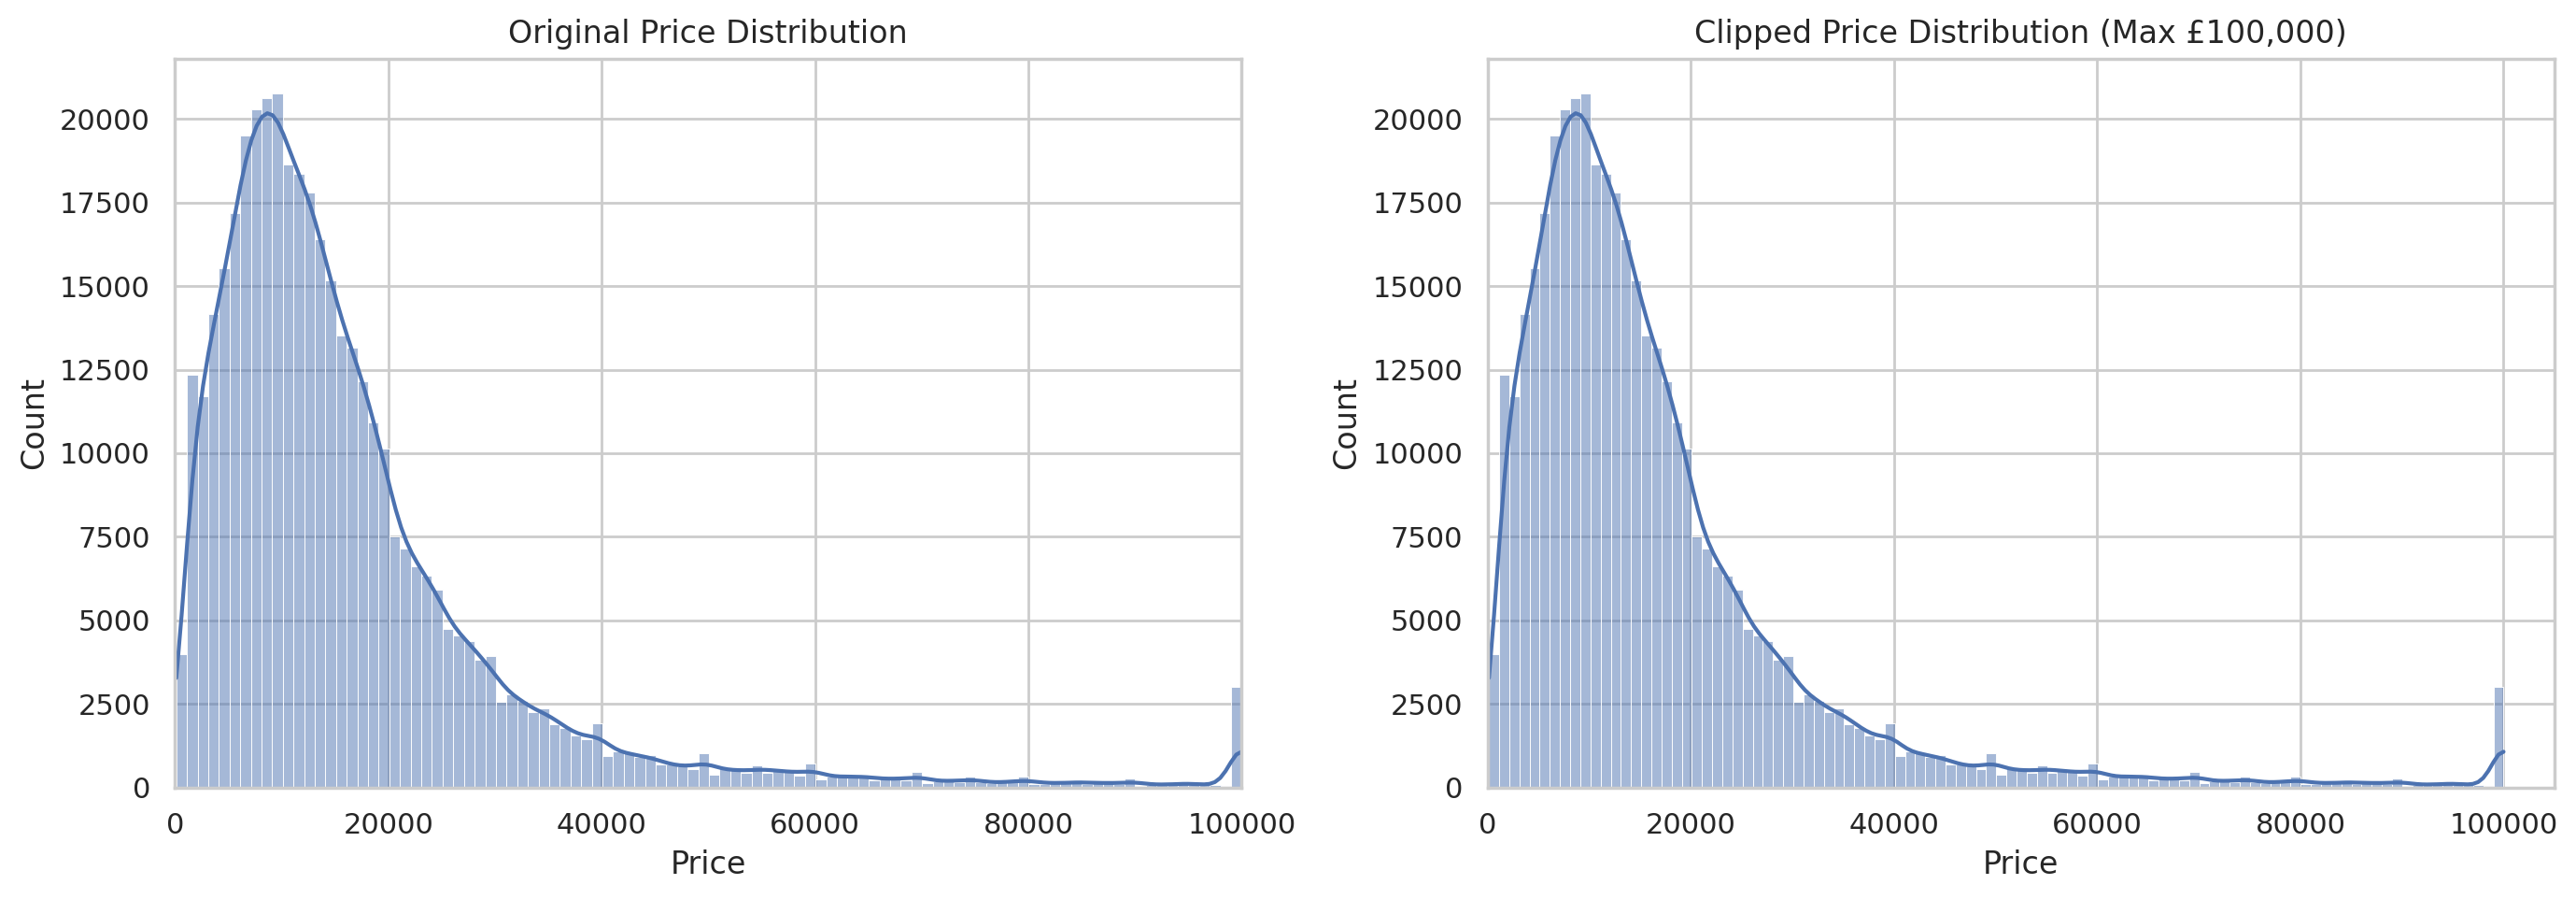

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

# Compare before and after clipping
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot original price distribution
sns.histplot(data=AT, x='price', bins=100, kde=True, ax=axs[0])
axs[0].set_title('Original Price Distribution')
axs[0].set_xlim(0, AT['price'].max())
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Count')

# Clip prices above 100,000
AT_cleaned['price_clipped'] = AT_cleaned['price'].clip(upper=100000)

# Plot clipped price distribution
# Changed 'AT' to 'AT_cleaned' to use the DataFrame with 'price_clipped' column
sns.histplot(data=AT_cleaned, x='price_clipped', bins=100, kde=True, ax=axs[1])
axs[1].set_title('Clipped Price Distribution (Max £100,000)')
axs[1].set_xlim(0, 105000)
axs[1].set_xlabel('Price')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [23]:
AT_cleaned['price'].describe()

count   402005.00
mean     16554.35
std      15085.30
min        120.00
25%       7495.00
50%      12600.00
75%      20000.00
max     100000.00
Name: price, dtype: float64

In [24]:
AT_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
 12  clipped_price          402005 non-null  int64  
 13  price_clipped          402005 non-null  int64  
dtypes: bool(1), float64(2), int64(4), ob

In [25]:
print(AT_cleaned.isna().sum())

public_reference             0
mileage                    127
reg_code                 31857
standard_colour           5378
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration     33311
price                        0
body_type                  837
crossover_car_and_van        0
fuel_type                  601
clipped_price                0
price_clipped                0
dtype: int64


##vechicle condition
changed from used(0) and new(1) to 0 and 1

In [26]:
print(AT_cleaned['vehicle_condition'].unique())

['NEW' 'USED']


In [27]:
print(AT_cleaned['vehicle_condition'].value_counts())

vehicle_condition
USED    370756
NEW      31249
Name: count, dtype: int64


In [28]:
print(AT_cleaned['vehicle_condition'].value_counts(normalize=True))

vehicle_condition
USED   0.92
NEW    0.08
Name: proportion, dtype: float64


In [29]:
AT_cleaned['vehicle_condition'] = AT_cleaned['vehicle_condition'].map({'USED': 0, 'NEW': 1})

In [30]:
print(AT_cleaned['vehicle_condition'].value_counts(normalize=True))

vehicle_condition
0   0.92
1   0.08
Name: proportion, dtype: float64


##standard colour
fillNA will mode

In [31]:
AT_cleaned['standard_colour'].describe()

count     396627
unique        22
top        Black
freq       86287
Name: standard_colour, dtype: object

In [32]:
print(AT_cleaned['standard_colour'].unique())

['Grey' 'Blue' 'Brown' 'Red' 'Bronze' 'Black' 'White' 'Silver' nan
 'Purple' 'Green' 'Orange' 'Yellow' 'Turquoise' 'Gold' 'Multicolour'
 'Beige' 'Burgundy' 'Pink' 'Maroon' 'Magenta' 'Navy' 'Indigo']


In [33]:
AT_cleaned['standard_colour'].value_counts()

standard_colour
Black          86287
White          70535
Grey           68227
Blue           59784
Silver         49323
Red            42024
Green           4534
Orange          4088
Yellow          2097
Brown           2014
Multicolour     1854
Beige           1539
Bronze          1330
Purple          1211
Gold             818
Pink             410
Turquoise        307
Maroon           159
Burgundy          63
Magenta           15
Navy               7
Indigo             1
Name: count, dtype: int64

In [34]:
AT_cleaned['standard_colour'].value_counts(normalize=True)

standard_colour
Black         0.22
White         0.18
Grey          0.17
Blue          0.15
Silver        0.12
Red           0.11
Green         0.01
Orange        0.01
Yellow        0.01
Brown         0.01
Multicolour   0.00
Beige         0.00
Bronze        0.00
Purple        0.00
Gold          0.00
Pink          0.00
Turquoise     0.00
Maroon        0.00
Burgundy      0.00
Magenta       0.00
Navy          0.00
Indigo        0.00
Name: proportion, dtype: float64

In [35]:
AT_cleaned['standard_colour'].isna().value_counts()

standard_colour
False    396627
True       5378
Name: count, dtype: int64

In [36]:
AT_cleaned['standard_colour'].isna().value_counts(normalize=True)

standard_colour
False   0.99
True    0.01
Name: proportion, dtype: float64

In [37]:
AT_cleaned['standard_colour'] = AT_cleaned['standard_colour'].fillna(AT_cleaned['standard_colour'].mode()[0])

In [38]:
AT_cleaned['standard_colour'].isna().value_counts()

standard_colour
False    402005
Name: count, dtype: int64

##REG CODE and year of registration
fixed with year of registration

In [39]:
print(AT_cleaned['reg_code'].unique())

[nan '61' '17' '16' '64' '13' '08' '19' '60' '69' '66' '12' '18' '65' '09'
 'B' '10' '14' '03' '67' '63' '15' '68' '56' '20' '70' '62' '11' '05' '59'
 '58' 'W' '02' '57' '06' '52' '53' '04' 'J' '07' '55' '51' 'X' 'D' 'S' 'Y'
 '54' 'H' 'K' 'E' 'L' 'V' 'M' 'G' 'T' 'N' 'P' 'A' 'F' 'R' 'C' '94' '85'
 'CA' 'm' 'FW' '723xuu' '95' 's' '38' 'k' '37' 'p']


In [40]:
AT_cleaned['reg_code'] = AT_cleaned['reg_code'].astype(str).str.upper().str.strip()

###year of registration

In [41]:
AT_cleaned['year_of_registration'].value_counts()

year_of_registration
2017.00    68790
2016.00    43483
2019.00    39236
2018.00    38300
2015.00    29019
           ...  
1950.00        1
1018.00        1
1017.00        1
1006.00        1
1015.00        1
Name: count, Length: 84, dtype: int64

In [42]:
AT_cleaned['year_of_registration'].value_counts(normalize=True)

year_of_registration
2017.00   0.19
2016.00   0.12
2019.00   0.11
2018.00   0.10
2015.00   0.08
          ... 
1950.00   0.00
1018.00   0.00
1017.00   0.00
1006.00   0.00
1015.00   0.00
Name: proportion, Length: 84, dtype: float64

In [43]:
most_common_year = AT['year_of_registration'].value_counts(normalize=True)

print(most_common_year.head(10))

year_of_registration
2017.00   0.19
2016.00   0.12
2019.00   0.11
2018.00   0.10
2015.00   0.08
2020.00   0.08
2014.00   0.06
2013.00   0.05
2012.00   0.04
2011.00   0.03
Name: proportion, dtype: float64


In [44]:
AT['year_of_registration'].describe()

count   368694.00
mean      2015.01
std          7.96
min        999.00
25%       2013.00
50%       2016.00
75%       2018.00
max       2020.00
Name: year_of_registration, dtype: float64

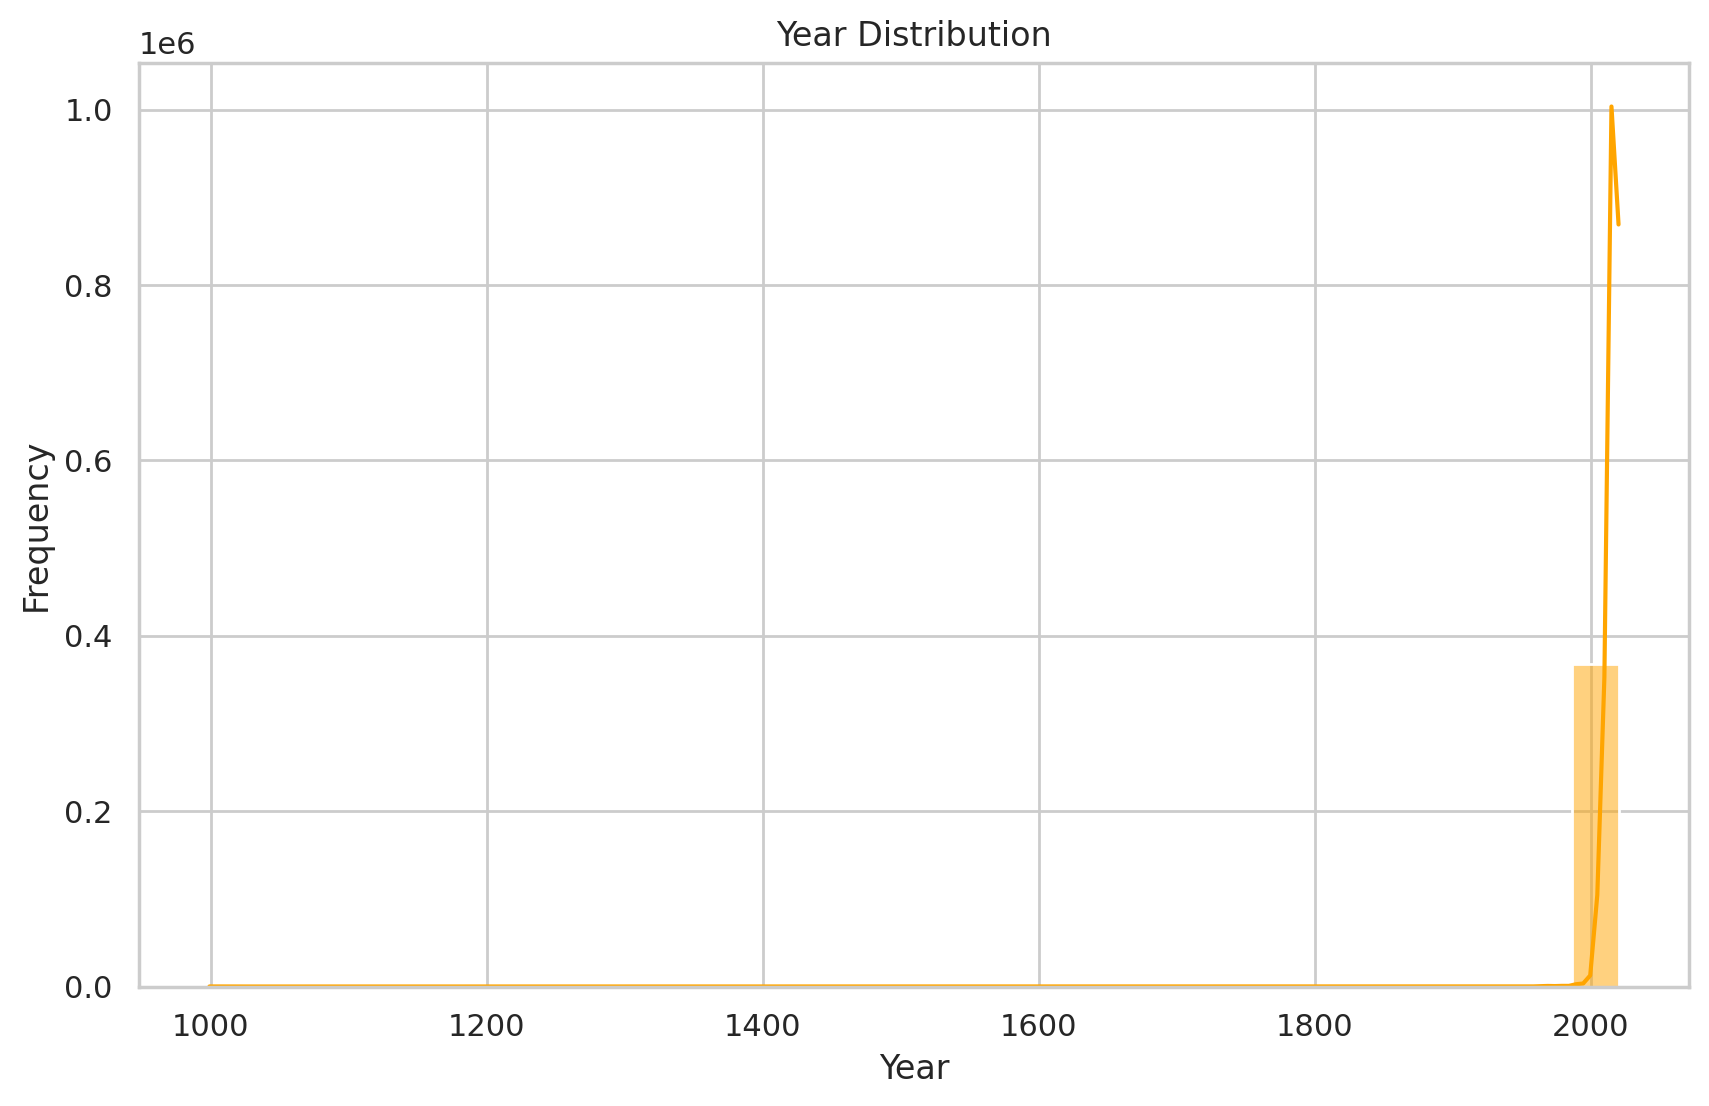

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(AT_cleaned['year_of_registration'], kde=True, bins=30,color="orange")
plt.title("Year Distribution")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

In [46]:
print(AT_cleaned['year_of_registration'].unique())

[  nan 2011. 2017. 2016. 2015. 2013. 2008. 2019. 2010. 2012. 2018. 2009.
 1984. 2014. 2003. 2006. 2020. 2005. 2000. 2002. 2007. 2004. 1991. 2001.
 1986. 1998. 1990. 1993. 1987. 1994. 1999. 1970. 1988. 1995. 1997. 1969.
 1992. 1989. 1996. 1976. 1983. 1980. 1973. 1962. 1967. 1972. 1982. 1968.
 1979. 1964. 1933. 1981. 1985. 1978. 1971. 1974. 1966. 1977. 1961. 1965.
 1007. 1957. 1515. 1963. 1063. 1954. 1975. 1955. 1009. 1016. 1960. 1956.
 1959. 1909. 1934. 1958. 1010. 1950. 1008. 1018.  999. 1017. 1952. 1006.
 1015.]


In [47]:
print(AT_cleaned['reg_code'].unique())

['NAN' '61' '17' '16' '64' '13' '08' '19' '60' '69' '66' '12' '18' '65'
 '09' 'B' '10' '14' '03' '67' '63' '15' '68' '56' '20' '70' '62' '11' '05'
 '59' '58' 'W' '02' '57' '06' '52' '53' '04' 'J' '07' '55' '51' 'X' 'D'
 'S' 'Y' '54' 'H' 'K' 'E' 'L' 'V' 'M' 'G' 'T' 'N' 'P' 'A' 'F' 'R' 'C' '94'
 '85' 'CA' 'FW' '723XUU' '95' '38' '37']


In [48]:
# Dictionary to map reg_code suffix letters to corresponding years
reg_code_to_year = {
    'A': 1963, 'B': 1964, 'C': 1965, 'D': 1966, 'E': 1967, 'F': 1968,
    'G': 1969, 'H': 1970, 'J': 1971, 'K': 1972, 'L': 1973, 'M': 1974,
    'N': 1975, 'P': 1976, 'R': 1977, 'S': 1978, 'T': 1979, 'V': 1980,
    'W': 1981, 'X': 1982, 'Y': 1983
}

# Extract year from reg_code
def extract_year_from_reg_code(reg_code):
    if isinstance(reg_code, str):
        if reg_code.isdigit():
            year_suffix = int(reg_code)
            return 1900 + year_suffix if 50 <= year_suffix <= 99 else 2000 + year_suffix
        elif len(reg_code) == 1 and reg_code.isalpha():
            return reg_code_to_year.get(reg_code)
    return None

# Apply correction
AT_cleaned['corrected_year_of_reg'] = np.where(
    # Case 1: Valid year_of_registration
    (AT_cleaned['year_of_registration'].between(1909, 2020)),
    AT_cleaned['year_of_registration'],

    # Case 2: Out-of-range year, extract from reg code
    np.where(
        AT_cleaned['year_of_registration'].notna(),
        AT_cleaned['reg_code'].apply(extract_year_from_reg_code),

        # Case 3: Missing year of registration and vehicle_condition is 1
        np.where(
            (AT_cleaned['vehicle_condition'] == 1),
            AT_cleaned['year_of_registration'].max() + 1 if pd.notna(AT_cleaned['year_of_registration'].max()) else 2021,

            # Case 4: Default to NaN
            np.nan
        )
    )
)

print(AT_cleaned.head())

   public_reference   mileage reg_code standard_colour standard_make  \
0   202006039777689      0.00      NAN            Grey         Volvo   
1   202007020778260 108230.00       61            Blue        Jaguar   
2   202007020778474   7800.00       17            Grey         SKODA   
3   202007080986776  45000.00       16           Brown      Vauxhall   
4   202007161321269  64000.00       64            Grey    Land Rover   

      standard_model  vehicle_condition  year_of_registration  price  \
0               XC90                  1                   NaN  73970   
1                 XF                  0               2011.00   7000   
2               Yeti                  0               2017.00  14000   
3              Mokka                  0               2016.00   7995   
4  Range Rover Sport                  0               2015.00  26995   

   body_type  crossover_car_and_van              fuel_type  clipped_price  \
0        SUV                  False  Petrol Plug-in Hybri

In [49]:
print(AT_cleaned['corrected_year_of_reg'].unique())

print(AT_cleaned['year_of_registration'].unique())

[2021. 2011. 2017. 2016. 2015. 2013. 2008. 2019. 2010. 2012. 2018. 2009.
 1984. 2014. 2003.   nan 2006. 2020. 2005. 2000. 2002. 2007. 2004. 1991.
 2001. 1986. 1998. 1990. 1993. 1987. 1994. 1999. 1970. 1988. 1995. 1997.
 1969. 1992. 1989. 1996. 1976. 1983. 1980. 1973. 1962. 1967. 1972. 1982.
 1968. 1979. 1964. 1933. 1981. 1985. 1978. 1971. 1974. 1966. 1977. 1961.
 1965. 1957. 1963. 1954. 1975. 1955. 1959. 1960. 1956. 1909. 1934. 1958.
 1950. 1952.]
[  nan 2011. 2017. 2016. 2015. 2013. 2008. 2019. 2010. 2012. 2018. 2009.
 1984. 2014. 2003. 2006. 2020. 2005. 2000. 2002. 2007. 2004. 1991. 2001.
 1986. 1998. 1990. 1993. 1987. 1994. 1999. 1970. 1988. 1995. 1997. 1969.
 1992. 1989. 1996. 1976. 1983. 1980. 1973. 1962. 1967. 1972. 1982. 1968.
 1979. 1964. 1933. 1981. 1985. 1978. 1971. 1974. 1966. 1977. 1961. 1965.
 1007. 1957. 1515. 1963. 1063. 1954. 1975. 1955. 1009. 1016. 1960. 1956.
 1959. 1909. 1934. 1958. 1010. 1950. 1008. 1018.  999. 1017. 1952. 1006.
 1015.]


In [50]:
print(AT_cleaned['corrected_year_of_reg'].describe())


count   399943.00
mean      2015.51
std          4.49
min       1909.00
25%       2014.00
50%       2017.00
75%       2018.00
max       2021.00
Name: corrected_year_of_reg, dtype: float64


In [51]:
missing_years_nan = AT_cleaned[AT_cleaned['year_of_registration'].isna()]
print(missing_years_nan[['year_of_registration', 'vehicle_condition', 'reg_code', 'corrected_year_of_reg']]) # Changed missing_years to missing_years_nan

        year_of_registration  vehicle_condition reg_code  \
0                        NaN                  1      NAN   
17                       NaN                  1      NAN   
19                       NaN                  1      NAN   
37                       NaN                  1      NAN   
44                       NaN                  1      NAN   
...                      ...                ...      ...   
401860                   NaN                  1      NAN   
401890                   NaN                  1      NAN   
401902                   NaN                  1      NAN   
401905                   NaN                  1      NAN   
401971                   NaN                  1      NAN   

        corrected_year_of_reg  
0                     2021.00  
17                    2021.00  
19                    2021.00  
37                    2021.00  
44                    2021.00  
...                       ...  
401860                2021.00  
401890                2

In [52]:
missing_years_nan = AT_cleaned[AT_cleaned['corrected_year_of_reg'].isna()]
print(missing_years_nan[[ 'vehicle_condition', 'reg_code', 'corrected_year_of_reg','year_of_registration',]])

        vehicle_condition reg_code  corrected_year_of_reg  \
54                      0       18                    NaN   
83                      0       61                    NaN   
865                     0       66                    NaN   
968                     0       17                    NaN   
1256                    0       68                    NaN   
...                   ...      ...                    ...   
400536                  0      NAN                    NaN   
400725                  0       20                    NaN   
401314                  0       67                    NaN   
401323                  0       13                    NaN   
401357                  0       20                    NaN   

        year_of_registration  
54                       NaN  
83                       NaN  
865                      NaN  
968                      NaN  
1256                     NaN  
...                      ...  
400536                   NaN  
400725             

In [53]:
(AT_cleaned['corrected_year_of_reg'].isna()).value_counts()

corrected_year_of_reg
False    399943
True       2062
Name: count, dtype: int64

In [54]:
(AT_cleaned['corrected_year_of_reg'].isna()).value_counts(normalize=True)

corrected_year_of_reg
False   0.99
True    0.01
Name: proportion, dtype: float64

In [55]:
AT_cleaned.loc[AT_cleaned['corrected_year_of_reg'].isna()]

public_reference  mileage reg_code standard_colour standard_make  \
54       202007030806426 30000.00       18             Red      Vauxhall   
83       202008222801747 42847.00       61             Red         Honda   
865      202010084741550 43130.00       66           White    Land Rover   
968      202010305607535 63369.00       17            Blue         SKODA   
1256     202010225294466 18715.00       68           White         Volvo   
...                  ...      ...      ...             ...           ...   
400536   202010094805399 40523.00      NAN             Red       Peugeot   
400725   202008252905656    45.00       20          Silver    Land Rover   
401314   202010315635541 12522.00       67             Red         Dacia   
401323   201909222504136 46000.00       13            Grey    Volkswagen   
401357   202007111114611    10.00       20            Blue      Vauxhall   

            standard_model  vehicle_condition  year_of_registration  price  \
54                Insignia                  0                   NaN  11990   
83                    Jazz                  0                   NaN   5695   
865      Range Rover Sport                  0                   NaN  35990   
968        Rapid Spaceback                  0                   NaN   7490   
1256                   V40                  0                   NaN  16950   
...                    ...                ...                   ...    ...   
400536                 108                  0                   NaN   5999   
400725  Range Rover Evoque                  0                   NaN  46945   
401314             Sandero                  0                   NaN   6300   
401323           Caravelle                  0                   NaN  22995   
401357               Corsa                  0                   NaN  16000   

        body_type  crossover_car_and_van fuel_type  clipped_price  \
54      Hatchback                  False    Petrol          11990   
83      Hatchback                  False    Petrol           5695   
865           SUV                  False    Diesel          35990   
968     Hatchback                  False    Diesel           7490   
1256          NaN                  False    Petrol          16950   
...           ...                    ...       ...            ...   
400536  Hatchback                  False    Petrol           5999   
400725        SUV                  False    Diesel          46945   
401314  Hatchback                  False    Petrol           6300   
401323        MPV                  False    Diesel          22995   
401357  Hatchback                  False    Petrol          16000   

        price_clipped  corrected_year_of_reg  
54              11990                    NaN  
83               5695                    NaN  
865             35990                    NaN  
968              7490                    NaN  
1256            16950                    NaN  
...               ...                    ...  
400536           5999                    NaN  
400725          46945                    NaN  
401314           6300                    NaN  
401323          22995                    NaN  
401357          16000                    NaN  

[2062 rows x 15 columns]

In [56]:
median_year = AT_cleaned['corrected_year_of_reg'].median()
print(f"median_year: {median_year}")

median_year: 2017.0


In [57]:
#Fill missing values with the median
AT_cleaned['corrected_year_of_reg'] = AT_cleaned['corrected_year_of_reg'].fillna(median_year)

In [58]:
(AT_cleaned['corrected_year_of_reg'].isna()).value_counts()

corrected_year_of_reg
False    402005
Name: count, dtype: int64

In [59]:
print(AT_cleaned['corrected_year_of_reg'].describe())

count   402005.00
mean      2015.52
std          4.48
min       1909.00
25%       2014.00
50%       2017.00
75%       2018.00
max       2021.00
Name: corrected_year_of_reg, dtype: float64


##body type
fill na with mode

In [60]:
AT_cleaned['body_type'].value_counts()

body_type
Hatchback          167315
SUV                115872
Saloon              36641
Estate              24692
Coupe               23258
Convertible         16038
MPV                 16026
Pickup                620
Combi Van             214
Limousine             159
Minibus               149
Camper                 77
Panel Van              61
Window Van             41
Chassis Cab             3
Car Derived Van         2
Name: count, dtype: int64

In [61]:
AT_cleaned['body_type'].value_counts(normalize=True)

body_type
Hatchback         0.42
SUV               0.29
Saloon            0.09
Estate            0.06
Coupe             0.06
Convertible       0.04
MPV               0.04
Pickup            0.00
Combi Van         0.00
Limousine         0.00
Minibus           0.00
Camper            0.00
Panel Van         0.00
Window Van        0.00
Chassis Cab       0.00
Car Derived Van   0.00
Name: proportion, dtype: float64

In [62]:
AT_cleaned['body_type'].describe()

count        401168
unique           16
top       Hatchback
freq         167315
Name: body_type, dtype: object

In [63]:
print(AT_cleaned['body_type'].unique())

['SUV' 'Saloon' 'Hatchback' 'Convertible' 'Limousine' 'Estate' 'MPV'
 'Coupe' nan 'Pickup' 'Combi Van' 'Panel Van' 'Minibus' 'Window Van'
 'Camper' 'Car Derived Van' 'Chassis Cab']


In [64]:
(AT_cleaned['body_type'].isna()).value_counts()

body_type
False    401168
True        837
Name: count, dtype: int64

In [65]:
AT_cleaned['body_type'] = AT_cleaned['body_type'].fillna(AT_cleaned['body_type'].mode()[0])

In [66]:
(AT_cleaned['body_type'].isna()).value_counts()

body_type
False    402005
Name: count, dtype: int64

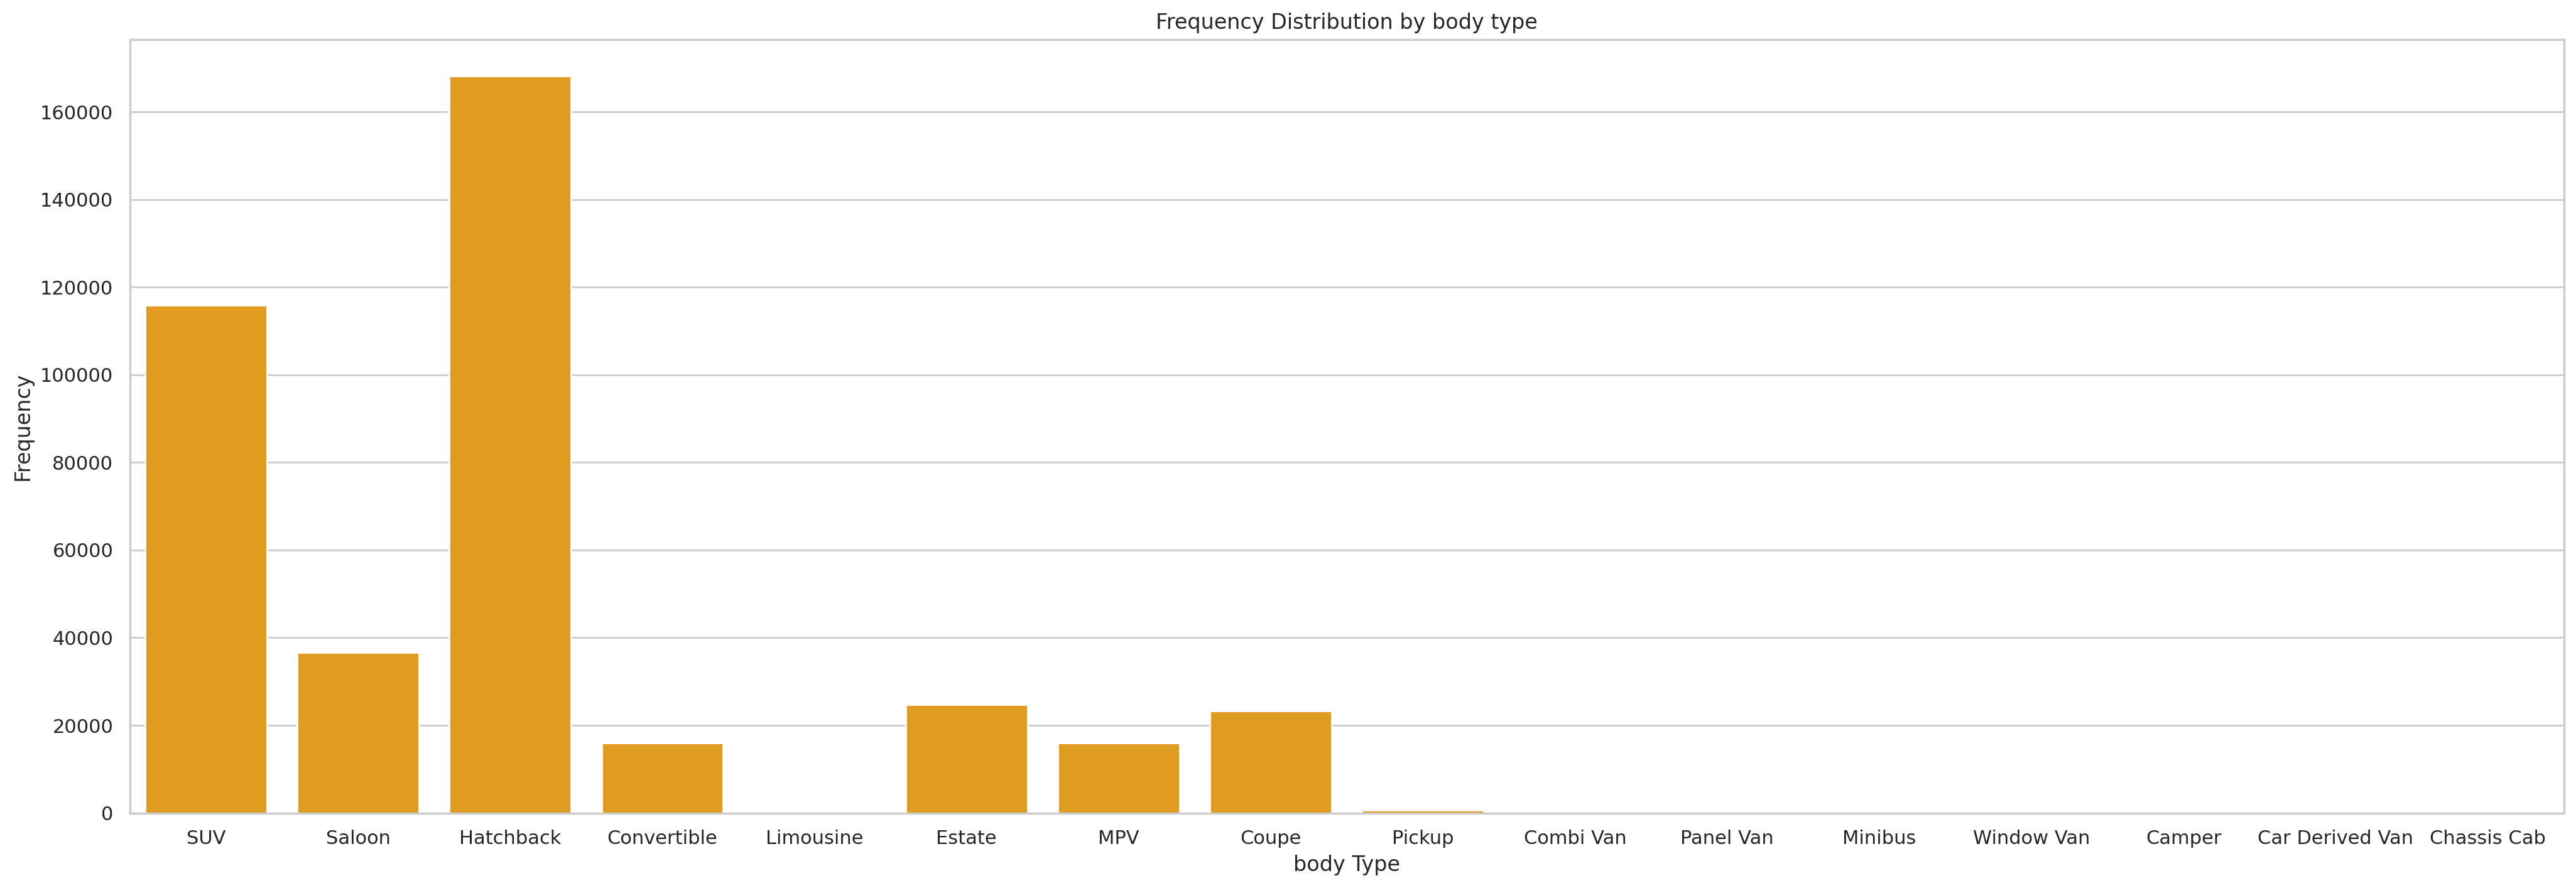

In [67]:
# Initialize the figure
plt.figure(figsize=(25, 8))

# Plot the frequency of fuel types
sns.countplot(data=AT_cleaned, x='body_type', color='orange')

# Title and labels
plt.title("Frequency Distribution by body type")
plt.xlabel("body Type")
plt.ylabel("Frequency")

# Show the plot
plt.show()



##FUEL TYPE
fill na with mode

In [68]:
AT_cleaned['fuel_type'].value_counts()

fuel_type
Petrol                   216929
Diesel                   158120
Petrol Hybrid             13602
Petrol Plug-in Hybrid      6160
Electric                   4783
Diesel Hybrid              1403
Bi Fuel                     221
Diesel Plug-in Hybrid       185
Natural Gas                   1
Name: count, dtype: int64

In [69]:
AT_cleaned['fuel_type'].value_counts(normalize=True)

fuel_type
Petrol                  0.54
Diesel                  0.39
Petrol Hybrid           0.03
Petrol Plug-in Hybrid   0.02
Electric                0.01
Diesel Hybrid           0.00
Bi Fuel                 0.00
Diesel Plug-in Hybrid   0.00
Natural Gas             0.00
Name: proportion, dtype: float64

In [70]:
AT_cleaned['fuel_type'].describe()

count     401404
unique         9
top       Petrol
freq      216929
Name: fuel_type, dtype: object

In [71]:
(AT_cleaned['fuel_type'].isna()).value_counts()

fuel_type
False    401404
True        601
Name: count, dtype: int64

In [72]:
AT_cleaned['fuel_type'].unique()

array(['Petrol Plug-in Hybrid', 'Diesel', 'Petrol', 'Diesel Hybrid',
       'Petrol Hybrid', 'Electric', 'Diesel Plug-in Hybrid', nan,
       'Bi Fuel', 'Natural Gas'], dtype=object)

In [73]:
AT_cleaned['fuel_type'] = AT_cleaned['fuel_type'].fillna(AT_cleaned['fuel_type'].mode()[0])

In [74]:
(AT_cleaned['fuel_type'].isna()).value_counts()

fuel_type
False    402005
Name: count, dtype: int64

In [75]:
AT_cleaned['fuel_type'].describe()

count     402005
unique         9
top       Petrol
freq      217530
Name: fuel_type, dtype: object

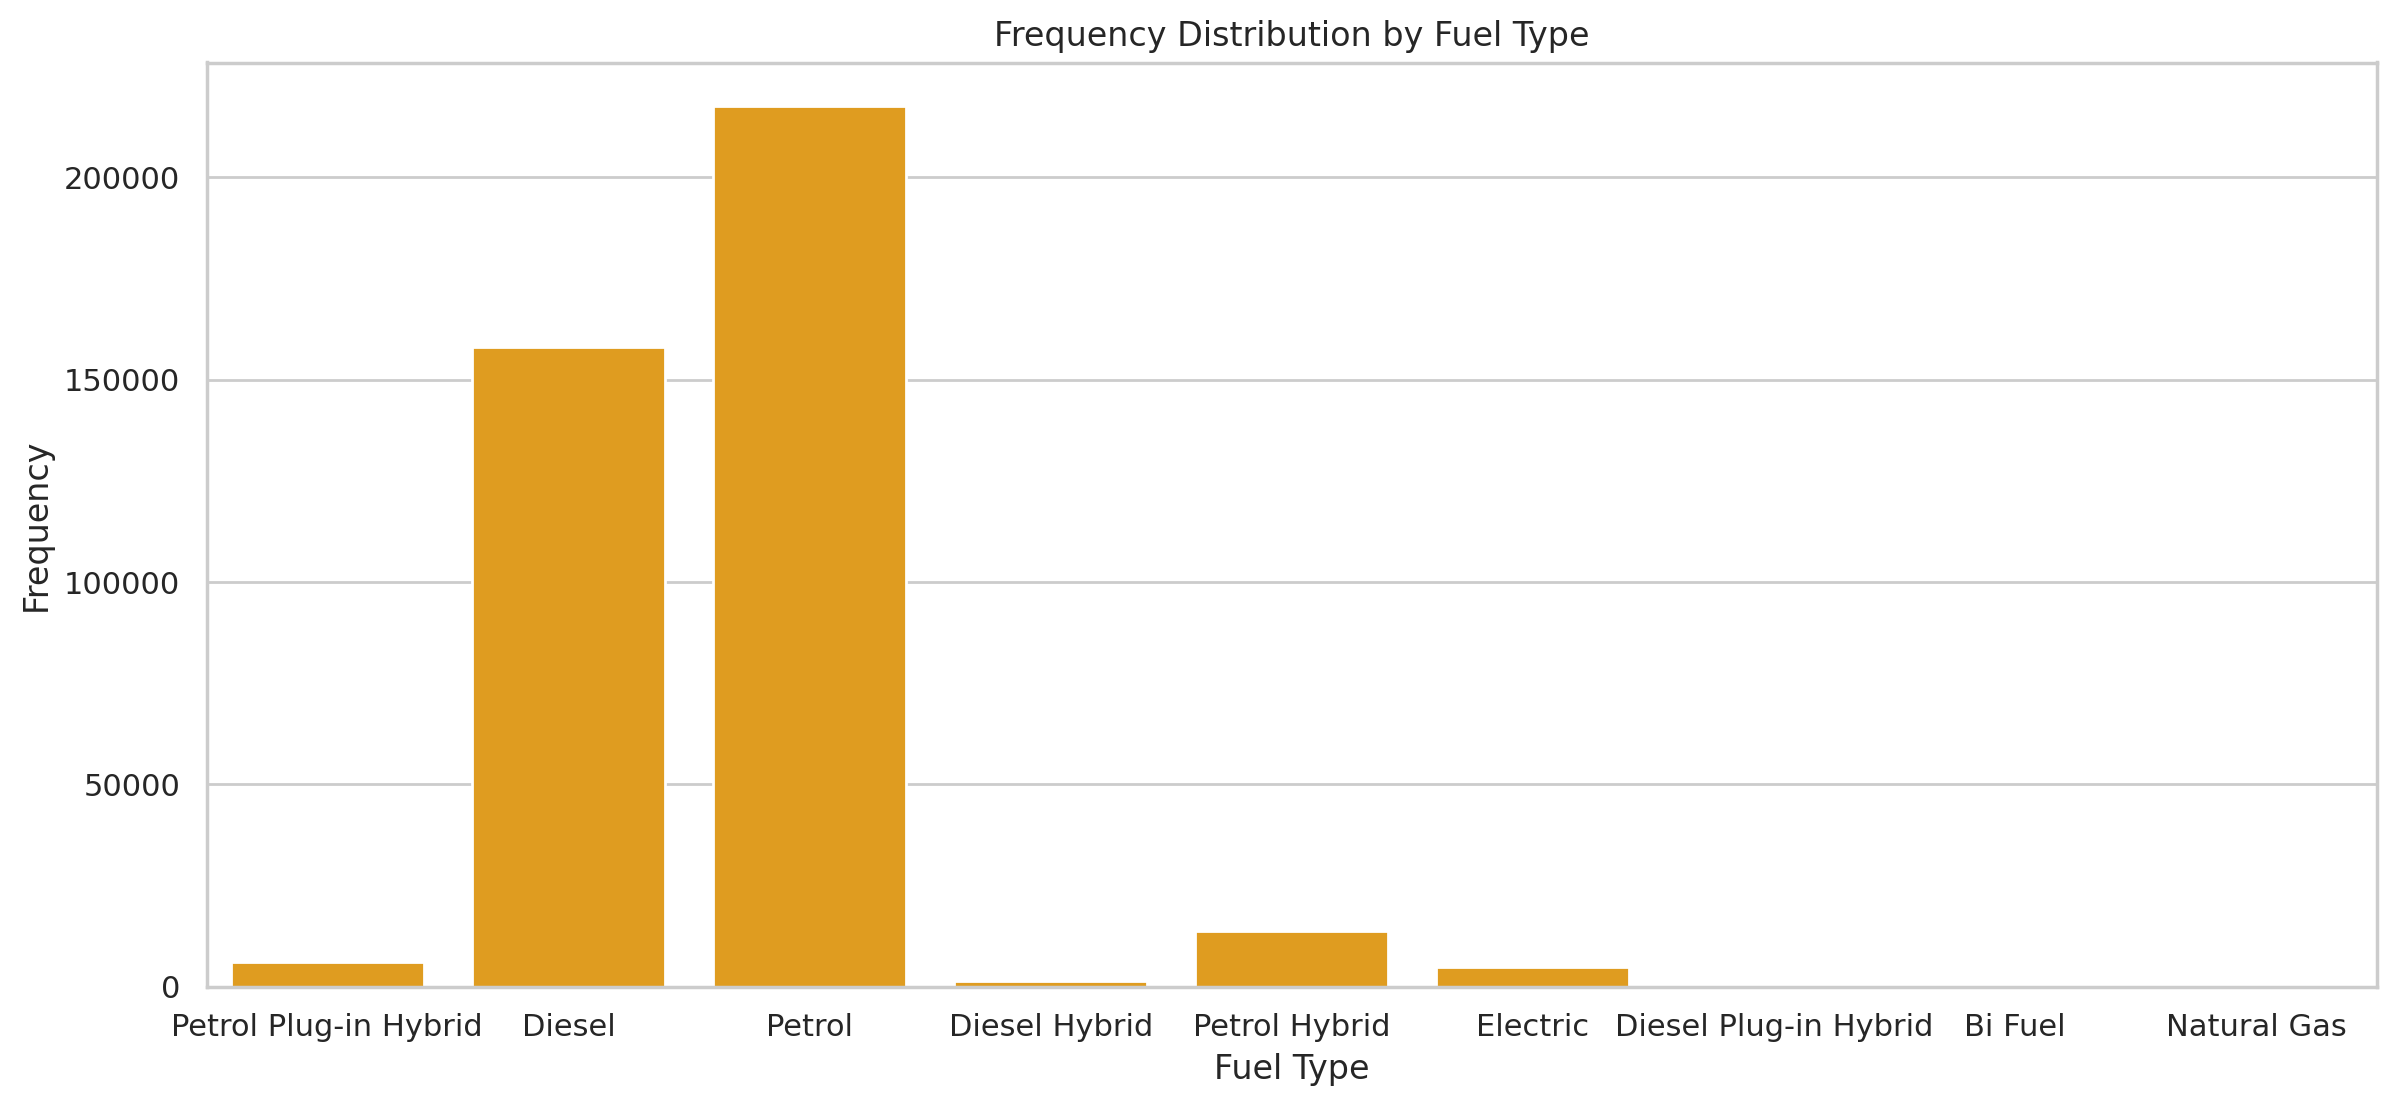

In [76]:
plt.figure(figsize=(14, 6))

# Plot the frequency of fuel types
sns.countplot(data=AT_cleaned, x='fuel_type', color='orange')

# Title and labels
plt.title("Frequency Distribution by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Frequency")

# Show the plot
plt.show()

##mileage

In [77]:
AT_cleaned['mileage'].describe()

count   401878.00
mean     37743.60
std      34831.72
min          0.00
25%      10481.00
50%      28629.50
75%      56875.75
max     999999.00
Name: mileage, dtype: float64

In [78]:
# Calculate mean, median, and mode for the entire 'mileage' column
mean_mileage = AT_cleaned['mileage'].mean()
median_mileage = AT_cleaned['mileage'].median()
mode_mileage = AT_cleaned['mileage'].mode()  # Extract the first mode value if multiple modes exist

print("Mean Mileage:", mean_mileage)
print("Median Mileage:", median_mileage)
print("Mode Mileage:", mode_mileage)

Mean Mileage: 37743.59565589557
Median Mileage: 28629.5
Mode Mileage: 0   0.00
Name: mileage, dtype: float64


In [79]:
(AT_cleaned['mileage'].isna()).value_counts()

mileage
False    401878
True        127
Name: count, dtype: int64

In [80]:
AT_cleaned['mileage'] = AT_cleaned['mileage'].fillna(AT_cleaned['mileage'].median())

In [81]:
(AT_cleaned['mileage'].isna()).value_counts()

mileage
False    402005
Name: count, dtype: int64

In [82]:
# Compute median mileage (excluding zeros)
mileage_median = AT.loc[AT['mileage'] > 0, 'mileage'].median()

# Fix only mileage == 0 where the car is NOT new
AT.loc[(AT['mileage'] == 0) & (AT['vehicle_condition'].str.lower() != 'new'), 'mileage'] = mileage_median



In [83]:
AT_cleaned['log_mileage'] = np.log(AT_cleaned['mileage'] + 1)

In [84]:
print(AT_cleaned['log_mileage'].isna().sum())
print(np.isinf(AT_cleaned['log_mileage']).sum())


0
0


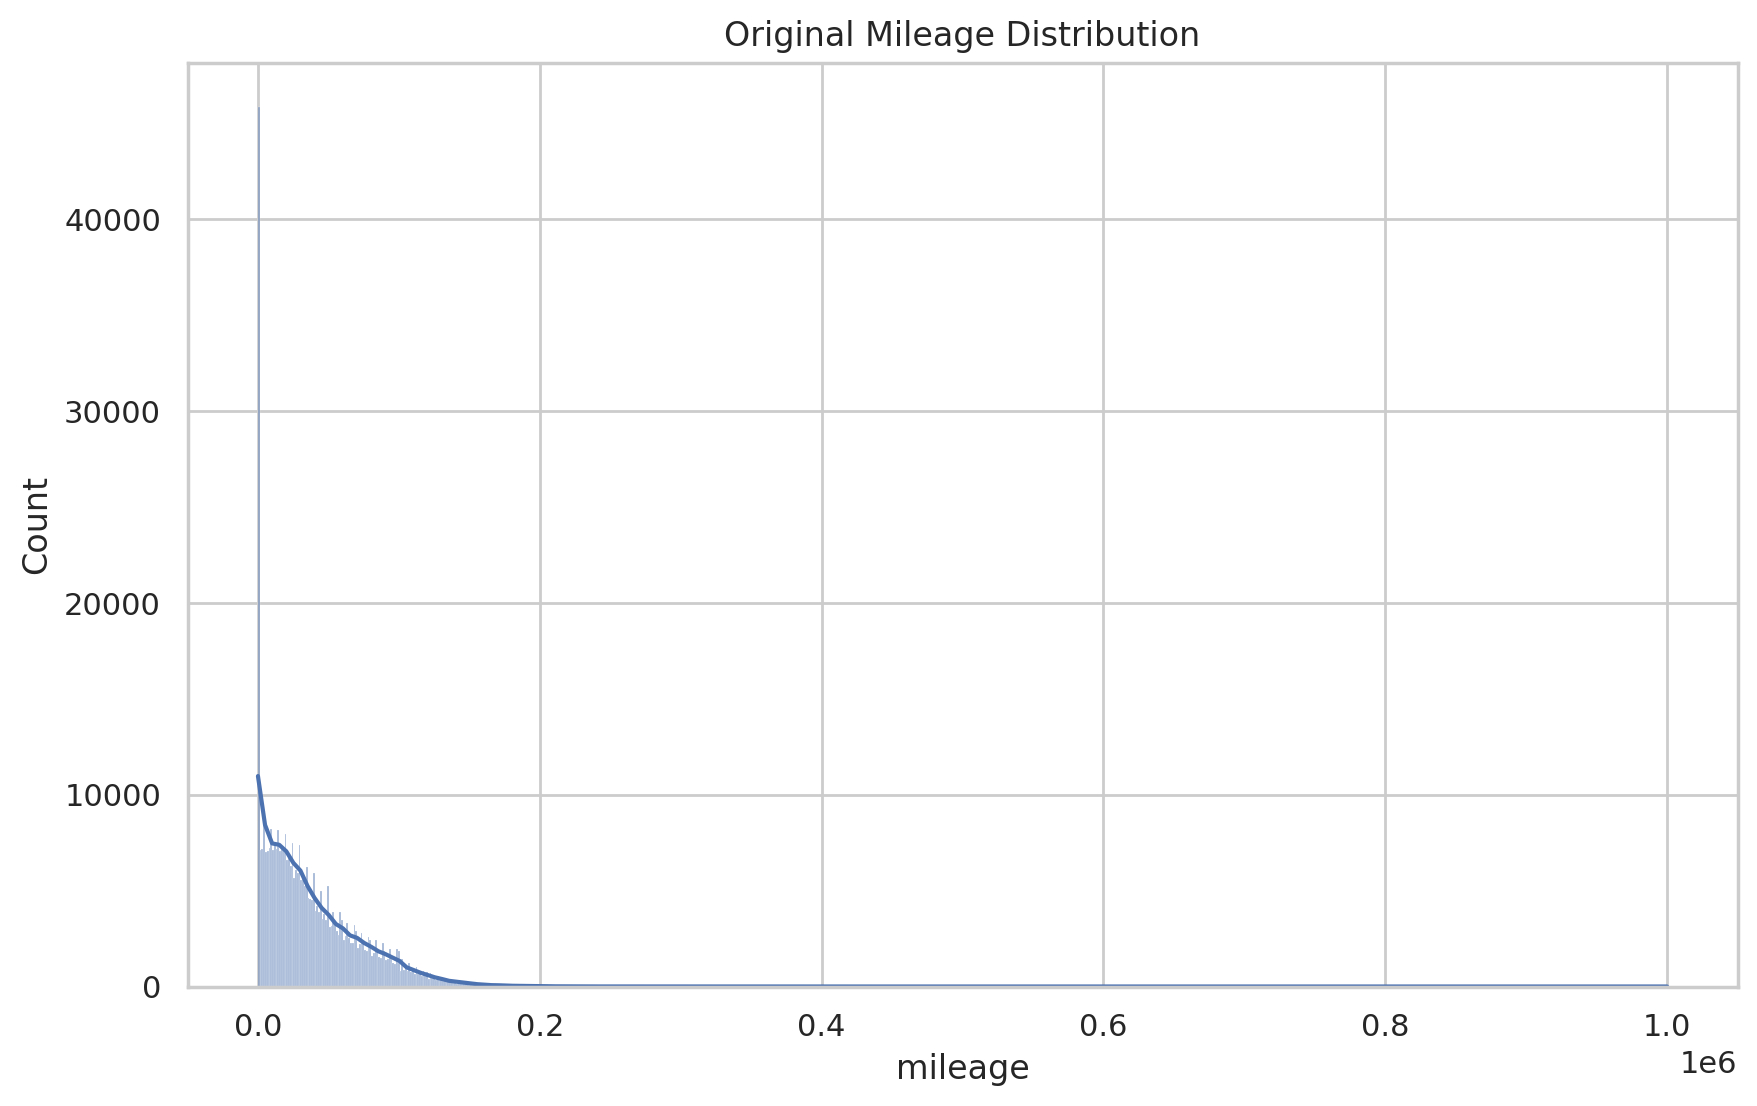

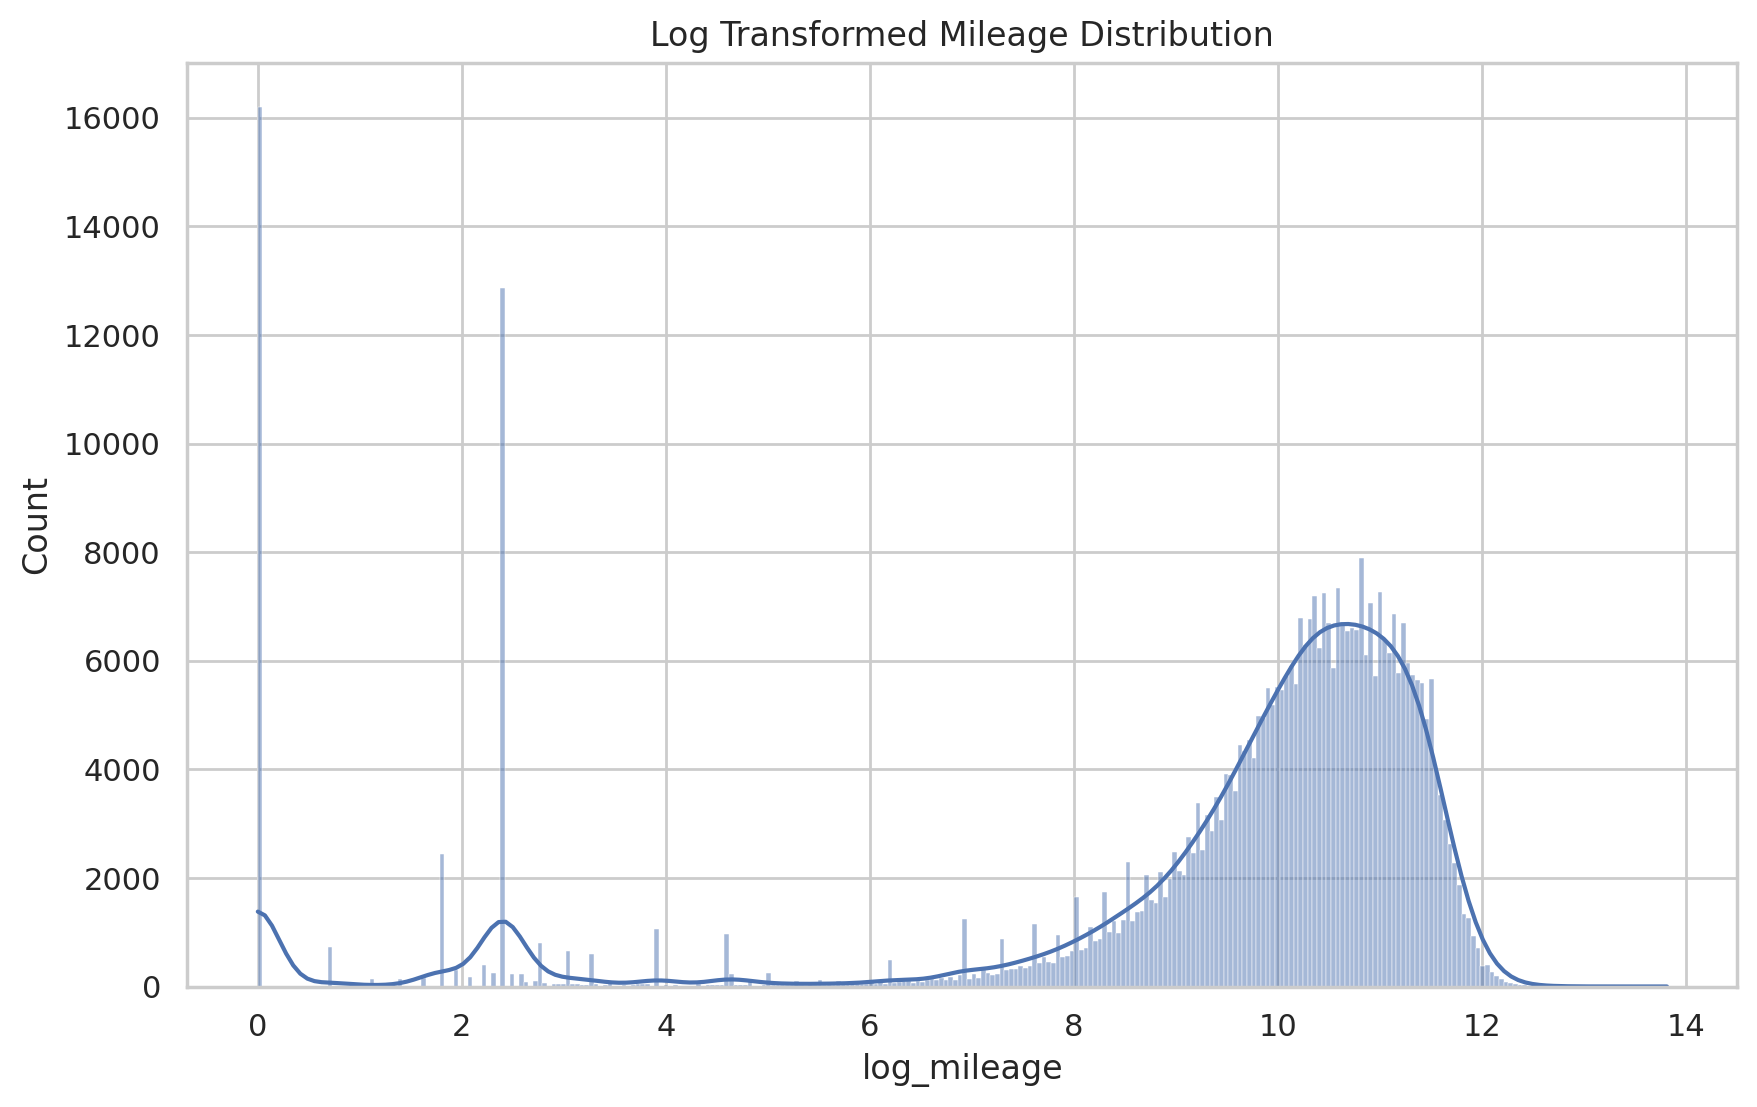

In [85]:
# Plot the original mileage distribution
plt.figure(figsize=(10, 6))
sns.histplot(AT_cleaned['mileage'], kde=True)
plt.title("Original Mileage Distribution")
plt.show()

# Plot the log-transformed mileage distribution
plt.figure(figsize=(10, 6))
sns.histplot(AT_cleaned['log_mileage'], kde=True)
plt.title("Log Transformed Mileage Distribution")
plt.show()

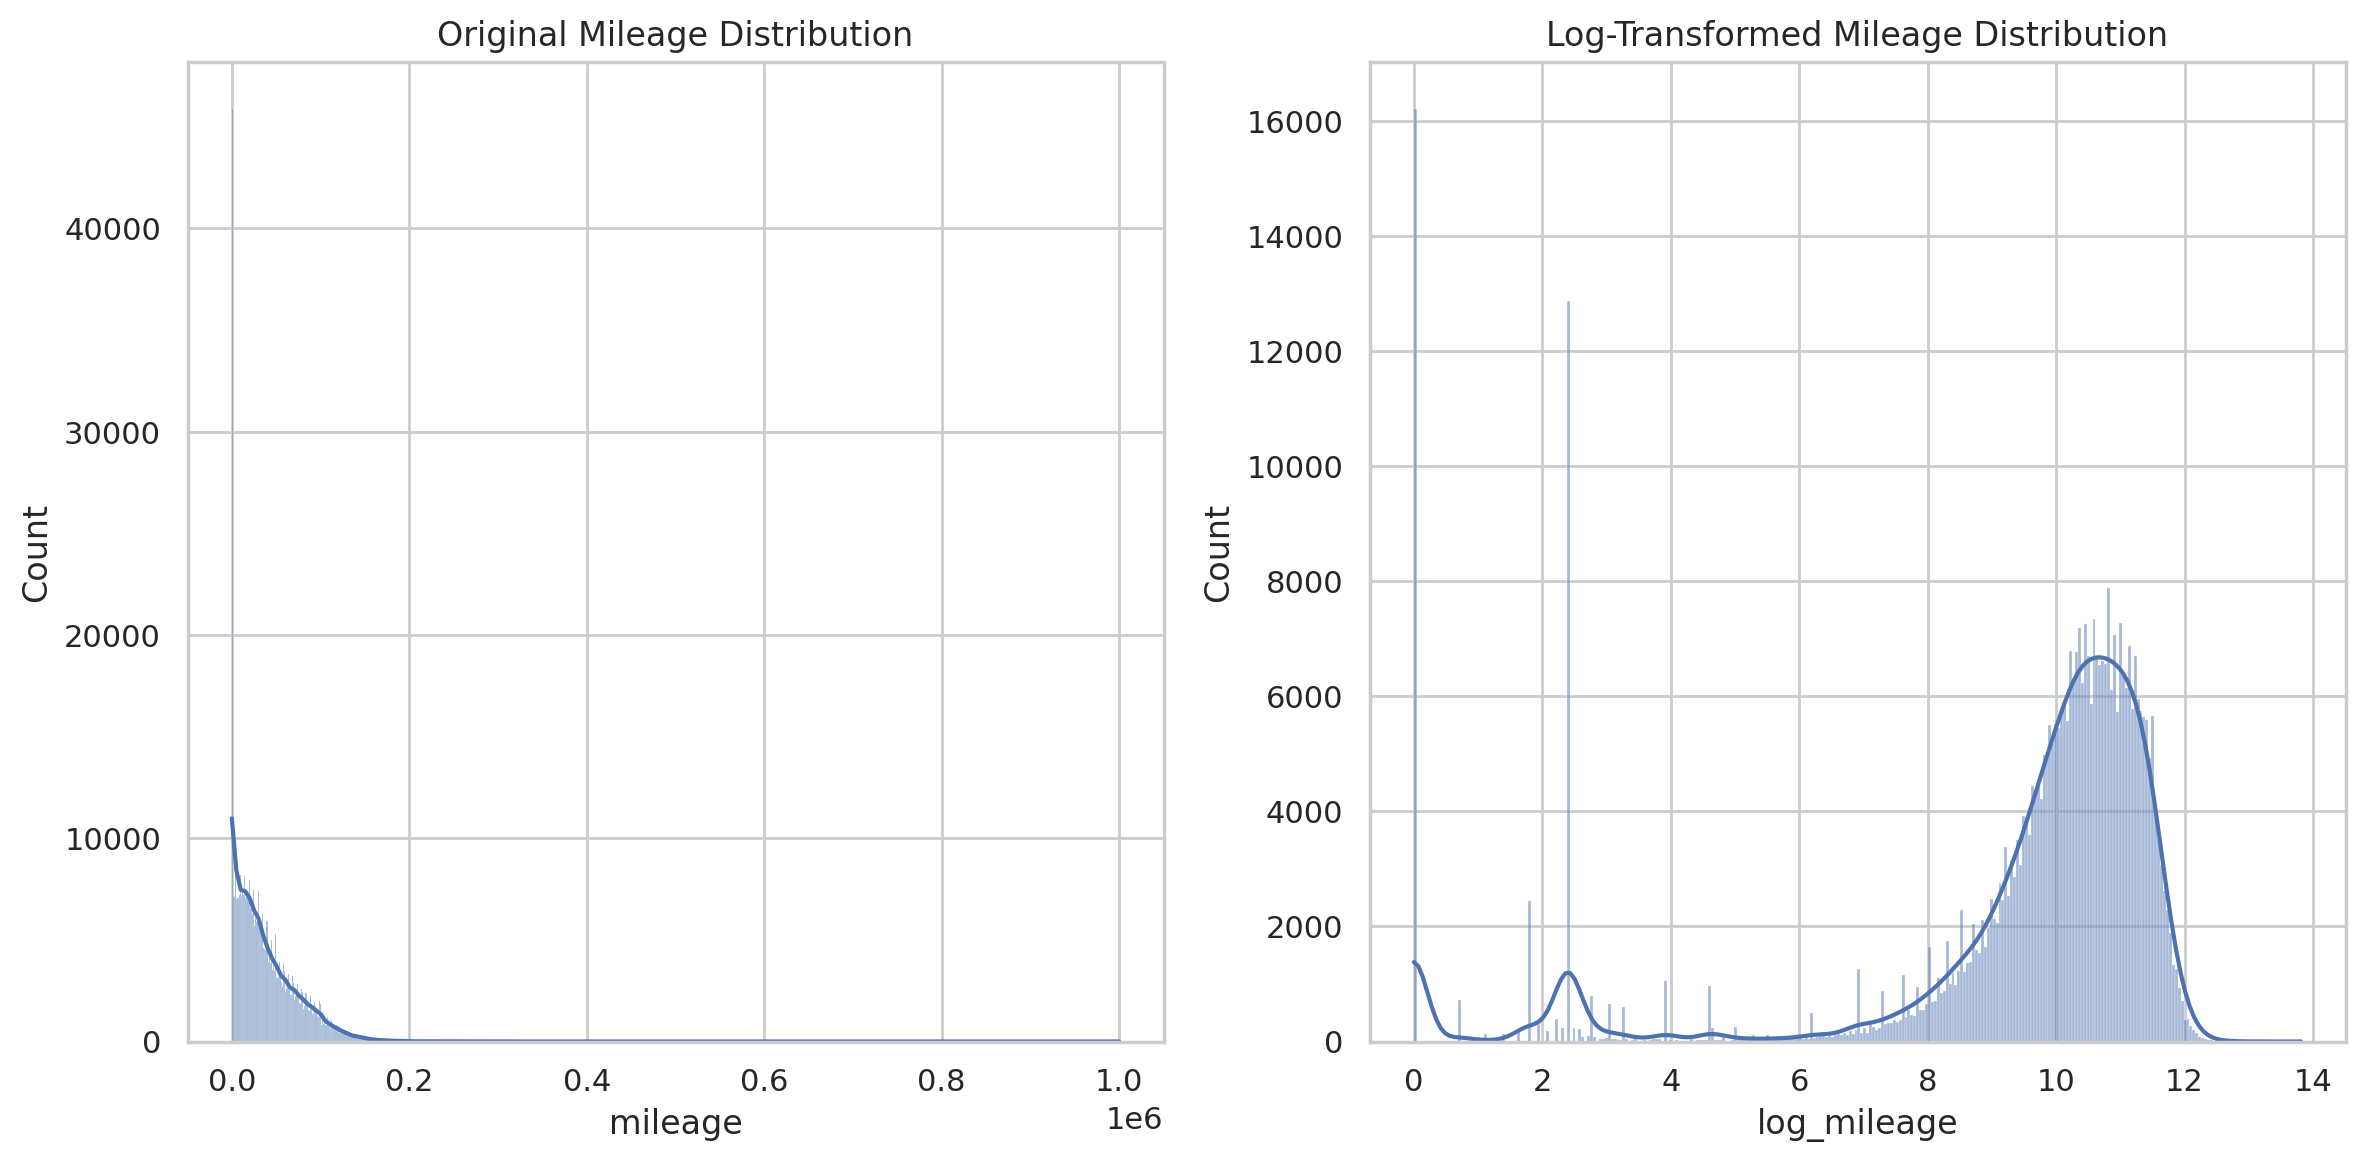

In [86]:
# prompt: side by side distribution plots for orginal mileage  and lig trasnformed mileage

import matplotlib.pyplot as plt
# Plot the original and log-transformed mileage distributions side-by-side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(AT_cleaned['mileage'], kde=True)
plt.title("Original Mileage Distribution")

plt.subplot(1, 2, 2)
sns.histplot(AT_cleaned['log_mileage'], kde=True)
plt.title("Log-Transformed Mileage Distribution")

plt.tight_layout()
plt.show()


In [87]:
AT_cleaned['mileage'].describe()

count   402005.00
mean     37740.72
std      34826.60
min          0.00
25%      10487.00
50%      28629.50
75%      56852.00
max     999999.00
Name: mileage, dtype: float64

In [88]:
AT_cleaned['log_mileage'].describe()

count   402005.00
mean         9.35
std          2.83
min          0.00
25%          9.26
50%         10.26
75%         10.95
max         13.82
Name: log_mileage, dtype: float64

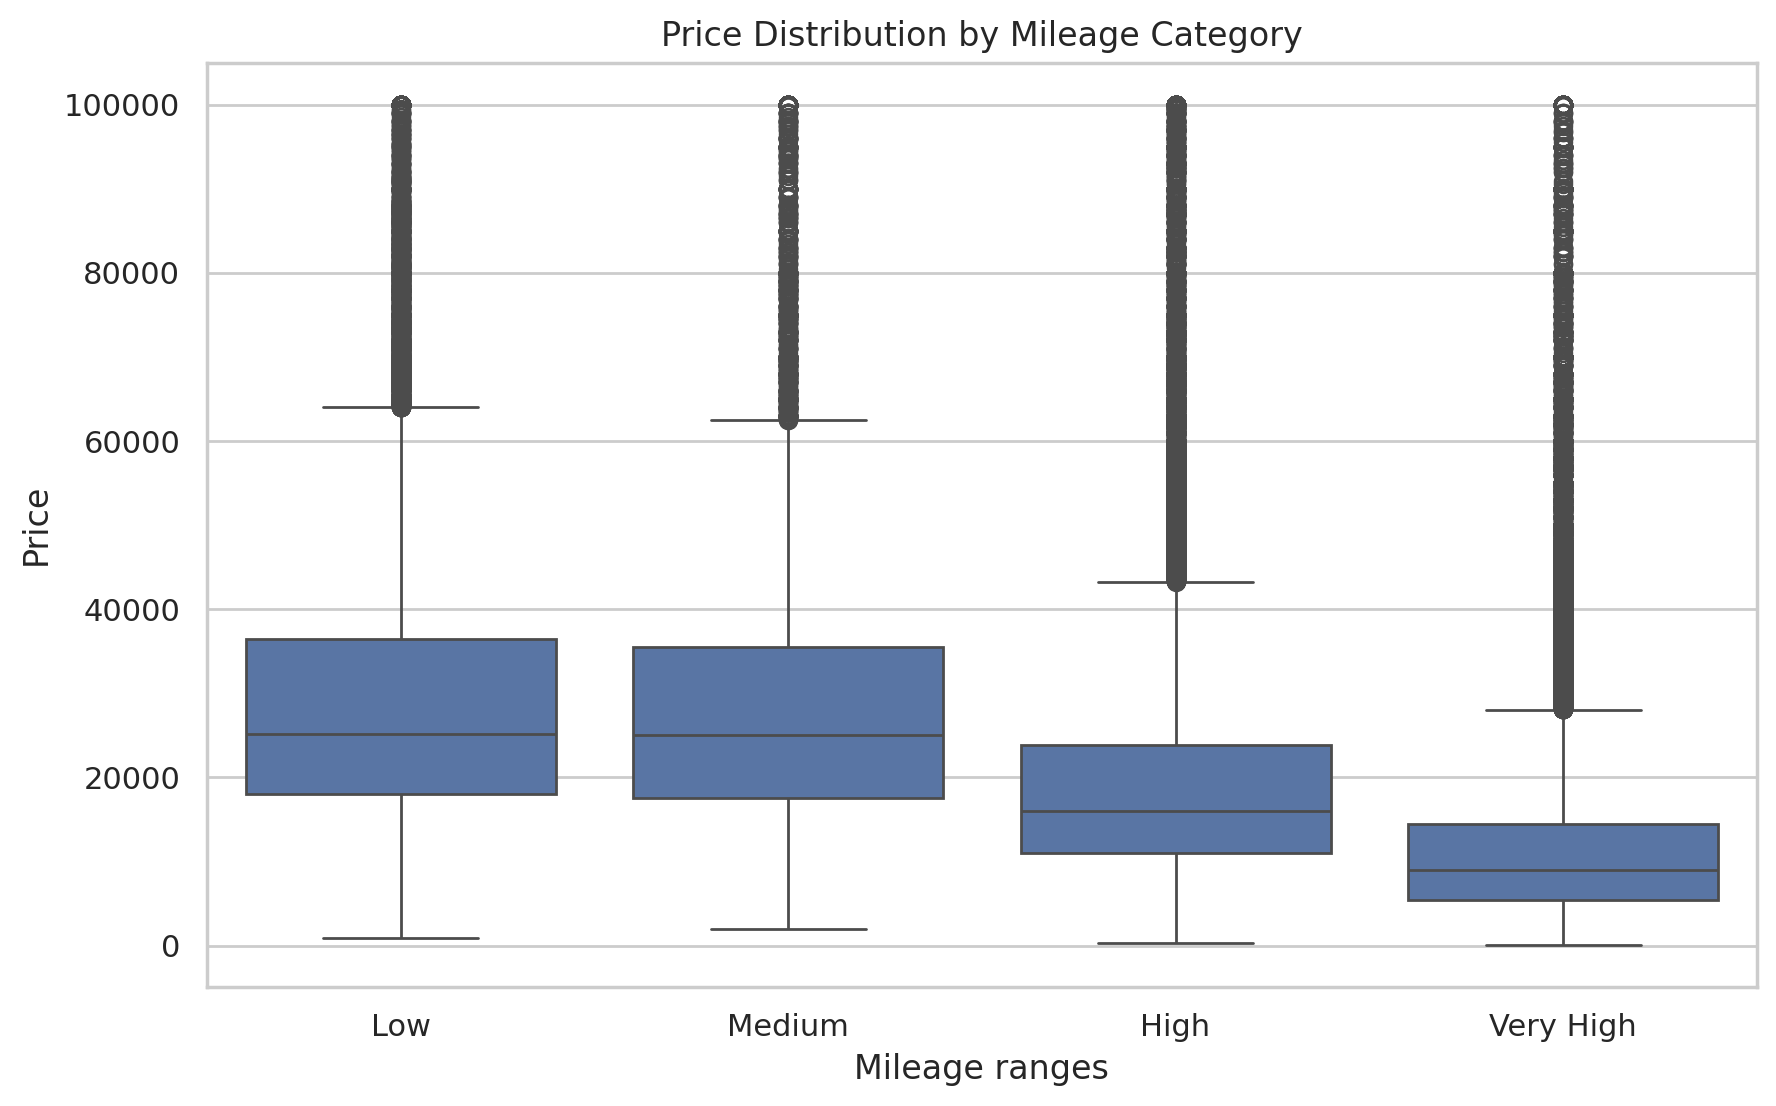

In [89]:
# prompt: define bins for log_mileage and plot price distrubtion

import pandas as pd
import matplotlib.pyplot as plt
# Define bins for log_mileage
bins = [0, 5, 8, 10, 12]  # Example bins, adjust as needed

# Create a new column 'mileage_category' based on the bins
AT_cleaned['mileage_ranges'] = pd.cut(AT_cleaned['log_mileage'], bins=bins, labels=['Low', 'Medium', 'High', 'Very High'])

# Plot the price distribution for each mileage category
plt.figure(figsize=(10, 6))
sns.boxplot(x='mileage_ranges', y='price', data=AT_cleaned)
plt.title('Price Distribution by Mileage Category')
plt.xlabel('Mileage ranges')
plt.ylabel('Price')
plt.show()


In [90]:
(AT_cleaned['mileage_ranges'].isna()).value_counts() # Changed 'mileage_range' to 'mileage_ranges'

mileage_ranges
False    384198
True      17807
Name: count, dtype: int64

#feature engineering
and dropping of old useless features

In [91]:
AT_cleaned.isna().sum()

public_reference             0
mileage                      0
reg_code                     0
standard_colour              0
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration     33311
price                        0
body_type                    0
crossover_car_and_van        0
fuel_type                    0
clipped_price                0
price_clipped                0
corrected_year_of_reg        0
log_mileage                  0
mileage_ranges           17807
dtype: int64

## feature engineerr make+model+body+fuel
and then atrget encode with k-fold cross

In [92]:
AT_cleaned['MMBF'] = (
    AT_cleaned['standard_make'].astype(str) + '_' +
    AT_cleaned['standard_model'].astype(str) + '_' +
    AT_cleaned['body_type'].astype(str) + '_' +
    AT_cleaned['fuel_type'].astype(str)
)


In [93]:
num_unique_mmbf = AT_cleaned['MMBF'].nunique()
print(f"Number of unique MMBF combinations: {num_unique_mmbf}")


Number of unique MMBF combinations: 2535


In [94]:
mmbf_counts = AT_cleaned['MMBF'].value_counts()
print(mmbf_counts.head(10))  # View top 10 most common combinations


MMBF
Vauxhall_Corsa_Hatchback_Petrol           10098
Volkswagen_Polo_Hatchback_Petrol           7210
MINI_Hatch_Hatchback_Petrol                5792
Fiat_500_Hatchback_Petrol                  5734
Volkswagen_Golf_Hatchback_Petrol           5637
Vauxhall_Astra_Hatchback_Petrol            4581
Volkswagen_Golf_Hatchback_Diesel           4478
Nissan_Juke_SUV_Petrol                     3852
Mercedes-Benz_A Class_Hatchback_Diesel     3849
BMW_1 Series_Hatchback_Diesel              3823
Name: count, dtype: int64


In [95]:
from sklearn.model_selection import KFold

def target_encode_kfold(data, feature_col, target_col, n_splits=5):
    data = data.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    encoded = pd.Series(index=data.index, dtype=float)

    for train_idx, val_idx in kf.split(data):
        train, val = data.iloc[train_idx], data.iloc[val_idx]
        means = train.groupby(feature_col)[target_col].mean()
        encoded.iloc[val_idx] = val[feature_col].map(means)

    return encoded

# Apply with fixed function name
AT_cleaned['MMBF_target_encoded'] = target_encode_kfold(AT_cleaned, 'MMBF', 'price')


In [96]:
AT_cleaned['MMBF_target_encoded'].isna().sum()

np.int64(655)

In [97]:
global_mean_price = AT_cleaned['price'].mean()
AT_cleaned['MMBF_target_encoded'] = AT_cleaned['MMBF_target_encoded'].fillna(global_mean_price)



In [98]:
AT_cleaned['MMBF_target_encoded'].isna().sum()

np.int64(0)

In [99]:
AT_cleaned['MMBF_target_encoded'].describe()

count   402005.00
mean     16543.10
std      12886.61
min        295.00
25%       8670.47
50%      13387.23
75%      18631.61
max     100000.00
Name: MMBF_target_encoded, dtype: float64

##vehicle age from year of reg

In [100]:
AT_cleaned['corrected_year_of_reg'] = pd.to_numeric(AT_cleaned['corrected_year_of_reg'], errors='coerce')

# Dynamically determine the reference year
reference_year = AT_cleaned['corrected_year_of_reg'].max()

# Calculate vehicle age using the dynamically determined reference year
AT_cleaned['vehicle_age_years'] = reference_year - AT_cleaned['corrected_year_of_reg']

# Check the updated DataFrame
print(AT_cleaned[['corrected_year_of_reg', 'vehicle_age_years']].head())
print(AT_cleaned[['corrected_year_of_reg', 'vehicle_age_years']].tail())

   corrected_year_of_reg  vehicle_age_years
0                2021.00               0.00
1                2011.00              10.00
2                2017.00               4.00
3                2016.00               5.00
4                2015.00               6.00
        corrected_year_of_reg  vehicle_age_years
402000                2019.00               2.00
402001                2009.00              12.00
402002                2012.00               9.00
402003                2015.00               6.00
402004                2014.00               7.00


In [101]:
print(AT_cleaned[['vehicle_age_years']].max())

vehicle_age_years   112.00
dtype: float64


In [102]:
AT_cleaned['vehicle_age_years'].describe()

count   402005.00
mean         5.48
std          4.48
min          0.00
25%          3.00
50%          4.00
75%          7.00
max        112.00
Name: vehicle_age_years, dtype: float64

In [103]:
AT_cleaned['make_model']= AT_cleaned['standard_make'] + ' ' +AT_cleaned['standard_model']

In [104]:
(AT_cleaned[['vehicle_age_years', 'corrected_year_of_reg', 'make_model']].sort_values(by='vehicle_age_years', ascending=False).head(10))

vehicle_age_years  corrected_year_of_reg        make_model
148003             112.00                1909.00       Hyundai i10
150850              88.00                1933.00     Austin Twelve
28925               88.00                1933.00      Austin Seven
156562              87.00                1934.00         Morris 10
194010              71.00                1950.00        Morgan 4/4
354336              69.00                1952.00    Triumph Renown
319411              69.00                1952.00     Morris Oxford
87933               67.00                1954.00  Morgan Plus Four
396021              67.00                1954.00  Aston Martin DB2
397962              67.00                1954.00  Fiat Pininfarina

In [105]:
AT_cleaned['vehicle_age_years'] = AT_cleaned['vehicle_age_years'].clip(upper=50)


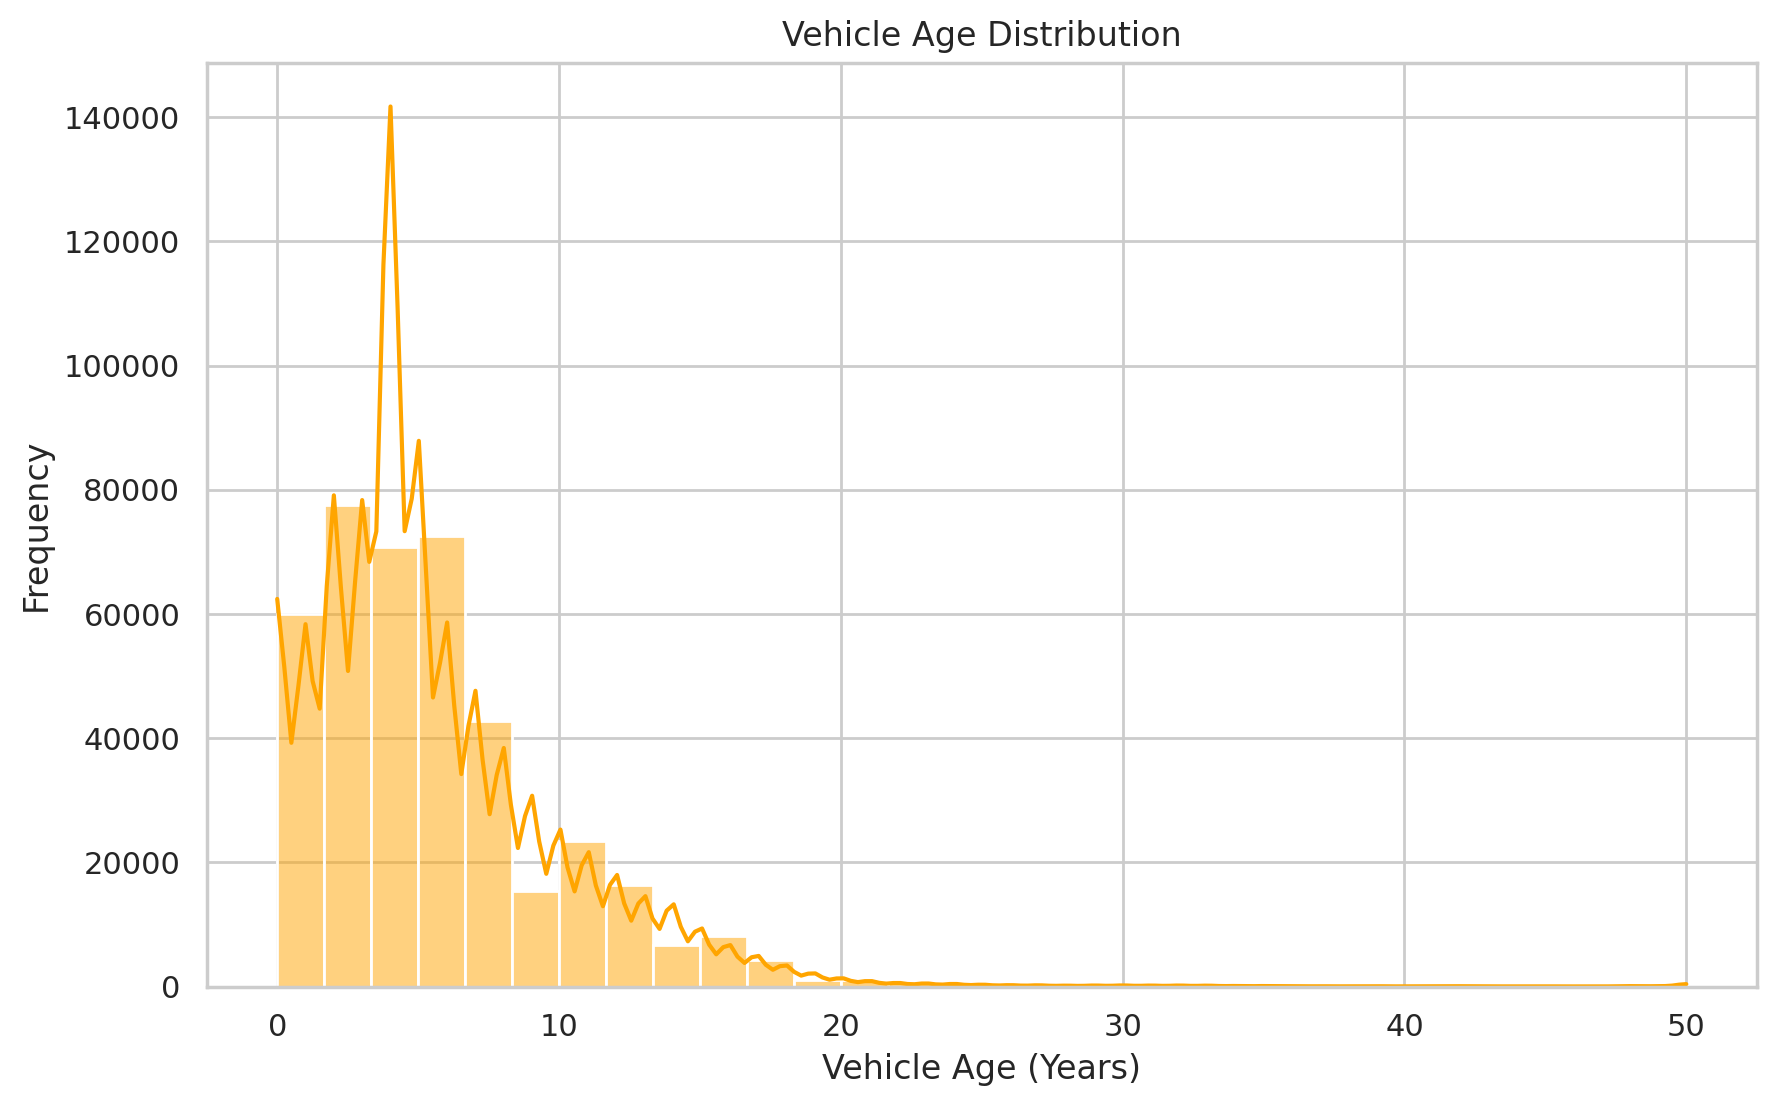

In [106]:
plt.figure(figsize=(10, 6))
sns.histplot(AT_cleaned['vehicle_age_years'], kde=True, bins=30, color="orange")
plt.title("Vehicle Age Distribution")
plt.xlabel("Vehicle Age (Years)")
plt.ylabel("Frequency")
plt.show()


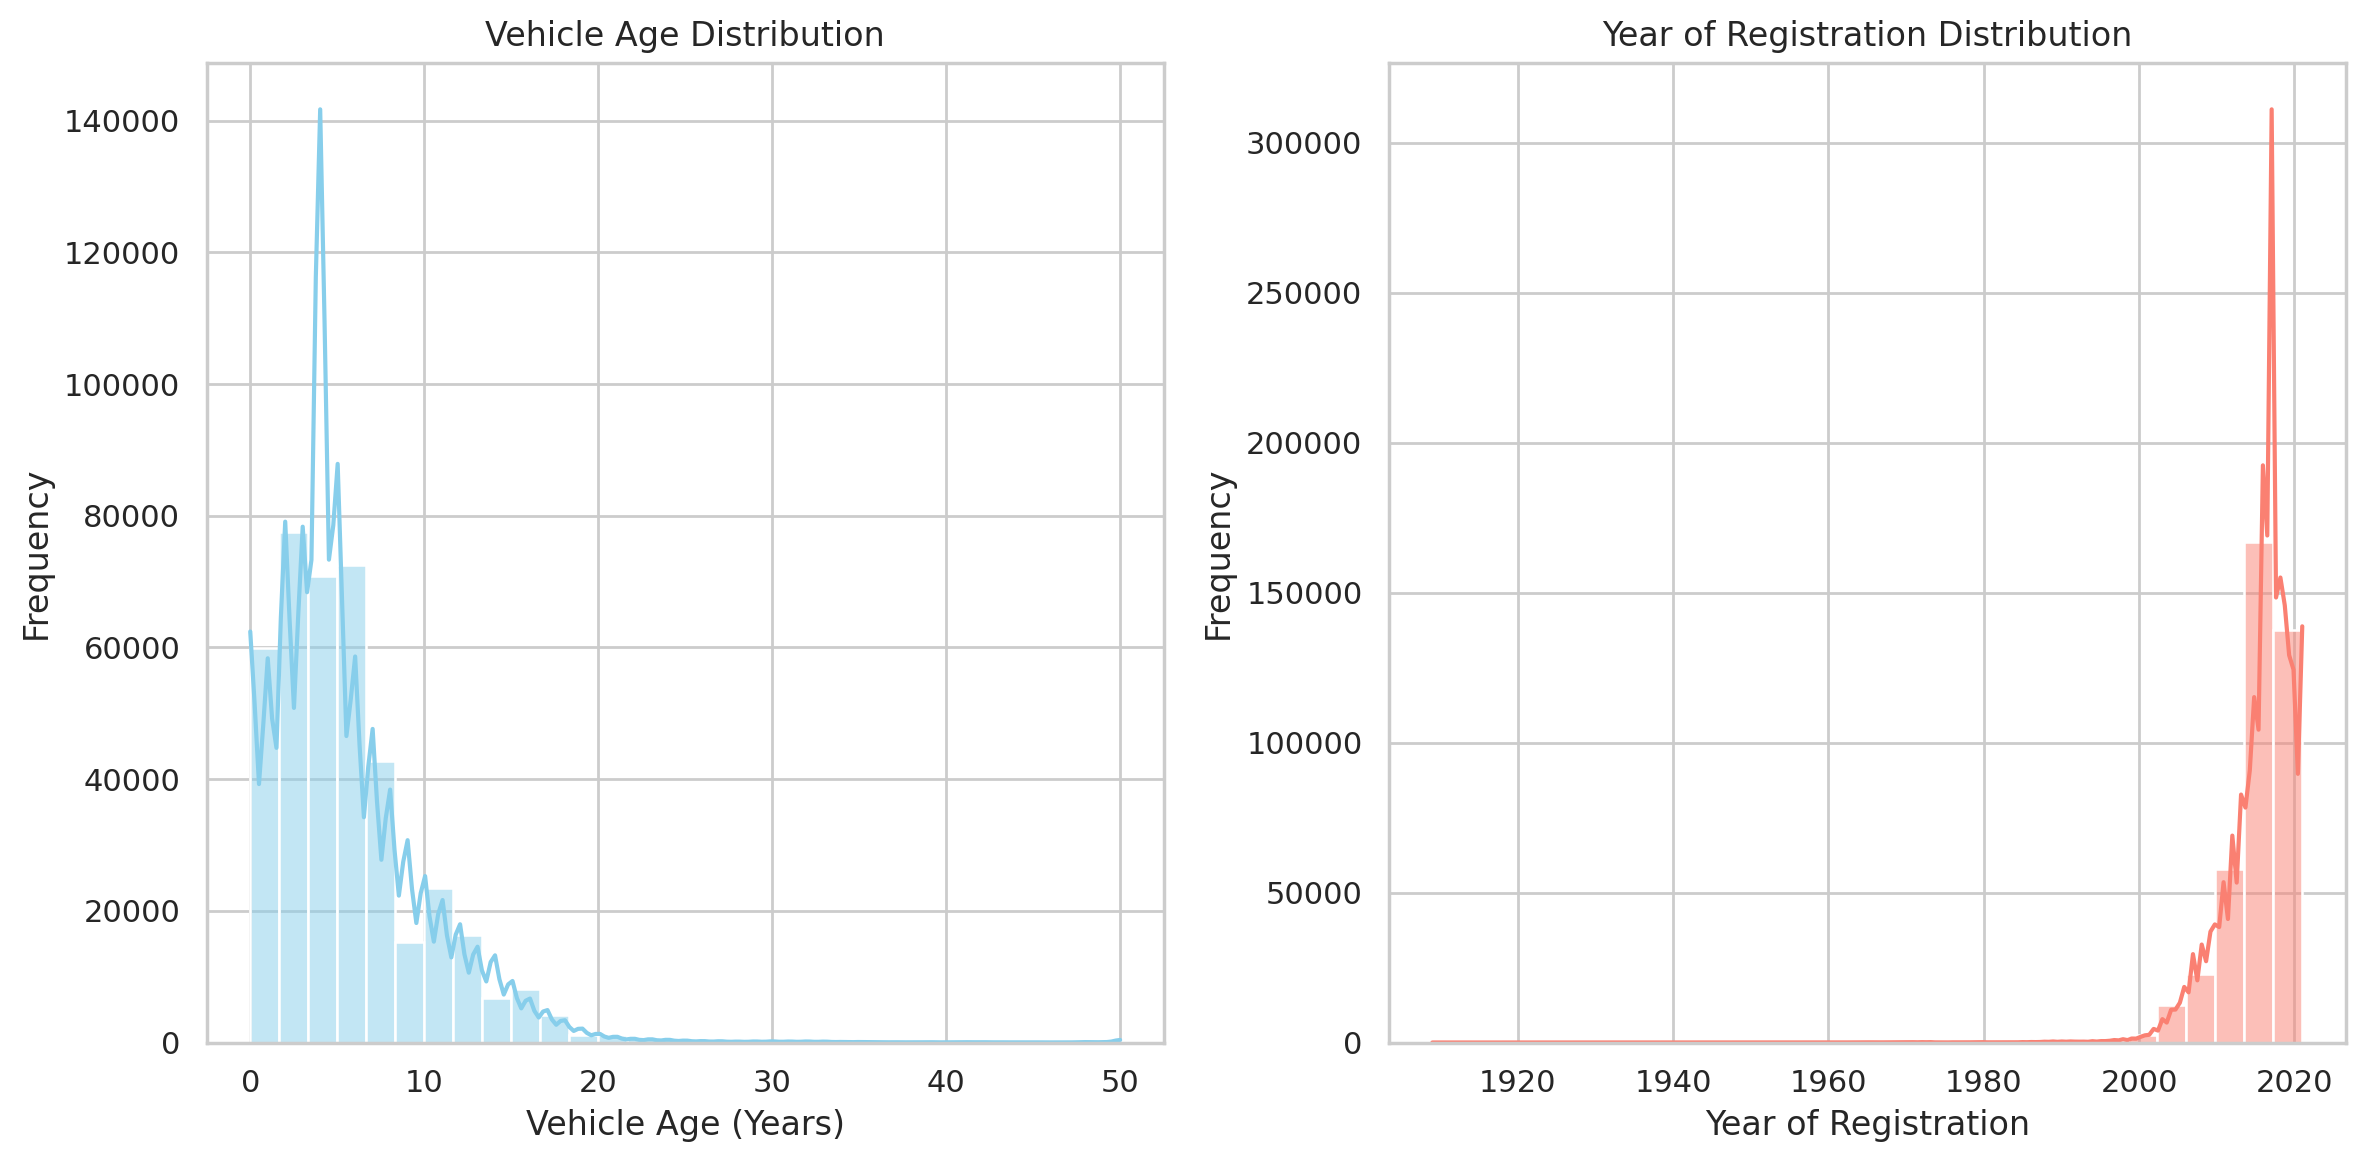

In [107]:
# prompt: side by side distrubtions plots of  vehicle_age_years and year of registration

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(AT_cleaned['vehicle_age_years'], kde=True, bins=30, color="skyblue")
plt.title("Vehicle Age Distribution")
plt.xlabel("Vehicle Age (Years)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(AT_cleaned['corrected_year_of_reg'], kde=True, bins=30, color="salmon")
plt.title("Year of Registration Distribution")
plt.xlabel("Year of Registration")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [108]:
AT_cleaned['vehicle_age_years'].describe()

count   402005.00
mean         5.47
std          4.45
min          0.00
25%          3.00
50%          4.00
75%          7.00
max         50.00
Name: vehicle_age_years, dtype: float64

In [109]:
AT_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   public_reference       402005 non-null  int64   
 1   mileage                402005 non-null  float64 
 2   reg_code               402005 non-null  object  
 3   standard_colour        402005 non-null  object  
 4   standard_make          402005 non-null  object  
 5   standard_model         402005 non-null  object  
 6   vehicle_condition      402005 non-null  int64   
 7   year_of_registration   368694 non-null  float64 
 8   price                  402005 non-null  int64   
 9   body_type              402005 non-null  object  
 10  crossover_car_and_van  402005 non-null  bool    
 11  fuel_type              402005 non-null  object  
 12  clipped_price          402005 non-null  int64   
 13  price_clipped          402005 non-null  int64   
 14  corrected_year_of_re

In [110]:
print(AT_cleaned['price'].max())


100000


##crossover_car_and_van

In [111]:
AT_cleaned['crossover_car_and_van'].describe()

count     402005
unique         2
top        False
freq      400210
Name: crossover_car_and_van, dtype: object

In [112]:
AT_cleaned['crossover_car_and_van'].value_counts()

crossover_car_and_van
False    400210
True       1795
Name: count, dtype: int64

In [113]:
# Step 1: Fill any missing values (assume False by default or use mode)
AT_cleaned['crossover_car_and_van'].fillna(False, inplace=True)

# Step 2: Convert boolean to integer (0 or 1)
AT_cleaned['crossover_car_and_van'] = AT_cleaned['crossover_car_and_van'].astype(int)

# Optional: Confirm conversion
print(AT_cleaned['crossover_car_and_van'].value_counts(normalize=True))


crossover_car_and_van
0   1.00
1   0.00
Name: proportion, dtype: float64


<ipython-input-113-ce7139fc25cd>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  AT_cleaned['crossover_car_and_van'].fillna(False, inplace=True)


In [114]:
print(AT_cleaned['crossover_car_and_van'].isna().sum())


0


In [115]:
selected_features = [
    'price_clipped',
    'standard_colour',
    'vehicle_condition',
    'log_mileage',
    'MMBF_target_encoded',
    'vehicle_age_years',
    'crossover_car_and_van'
]

AT_ML = AT_cleaned[selected_features].copy()


In [116]:
AT_ML.isna().sum()

price_clipped            0
standard_colour          0
vehicle_condition        0
log_mileage              0
MMBF_target_encoded      0
vehicle_age_years        0
crossover_car_and_van    0
dtype: int64

In [117]:
AT_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price_clipped          402005 non-null  int64  
 1   standard_colour        402005 non-null  object 
 2   vehicle_condition      402005 non-null  int64  
 3   log_mileage            402005 non-null  float64
 4   MMBF_target_encoded    402005 non-null  float64
 5   vehicle_age_years      402005 non-null  float64
 6   crossover_car_and_van  402005 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 21.5+ MB


##standard colour

In [118]:
# Step 1: Create dummy variables for 'standard_colour'
# This will create new columns like 'colour_Black', 'colour_White', etc.
# 'drop_first=True' avoids duplicate info (one category becomes the reference)
colour_dummies = pd.get_dummies(
    AT_ML['standard_colour'],
    prefix='colour',
    drop_first=True
)

# Step 2: Add the new dummy columns to the main dataset
AT_ML= pd.concat([AT_ML, colour_dummies], axis=1)

# Step 3: Remove the original 'standard_colour' column (we've now encoded it)
AT_ML.drop('standard_colour', axis=1, inplace=True)


In [119]:
AT_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price_clipped          402005 non-null  int64  
 1   vehicle_condition      402005 non-null  int64  
 2   log_mileage            402005 non-null  float64
 3   MMBF_target_encoded    402005 non-null  float64
 4   vehicle_age_years      402005 non-null  float64
 5   crossover_car_and_van  402005 non-null  int64  
 6   colour_Black           402005 non-null  bool   
 7   colour_Blue            402005 non-null  bool   
 8   colour_Bronze          402005 non-null  bool   
 9   colour_Brown           402005 non-null  bool   
 10  colour_Burgundy        402005 non-null  bool   
 11  colour_Gold            402005 non-null  bool   
 12  colour_Green           402005 non-null  bool   
 13  colour_Grey            402005 non-null  bool   
 14  colour_Indigo          402005 non-nu

##building task 2 RFE

In [120]:
#X = AT_ML.drop(columns='price_clipped')
#y = AT_ML['price_clipped']
AT_sampled = AT_ML.sample(frac=0.4, random_state=42)

X = AT_sampled.drop(columns='price_clipped')
y = AT_sampled['price_clipped']

# Split into train, validation, test (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

sample taken 40% of dataset

In [121]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

model = RandomForestRegressor(n_estimators=100, random_state=42)


In [122]:
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X, y)

top_features = X.columns[rfe.support_]
feature_ranks = rfe.ranking_


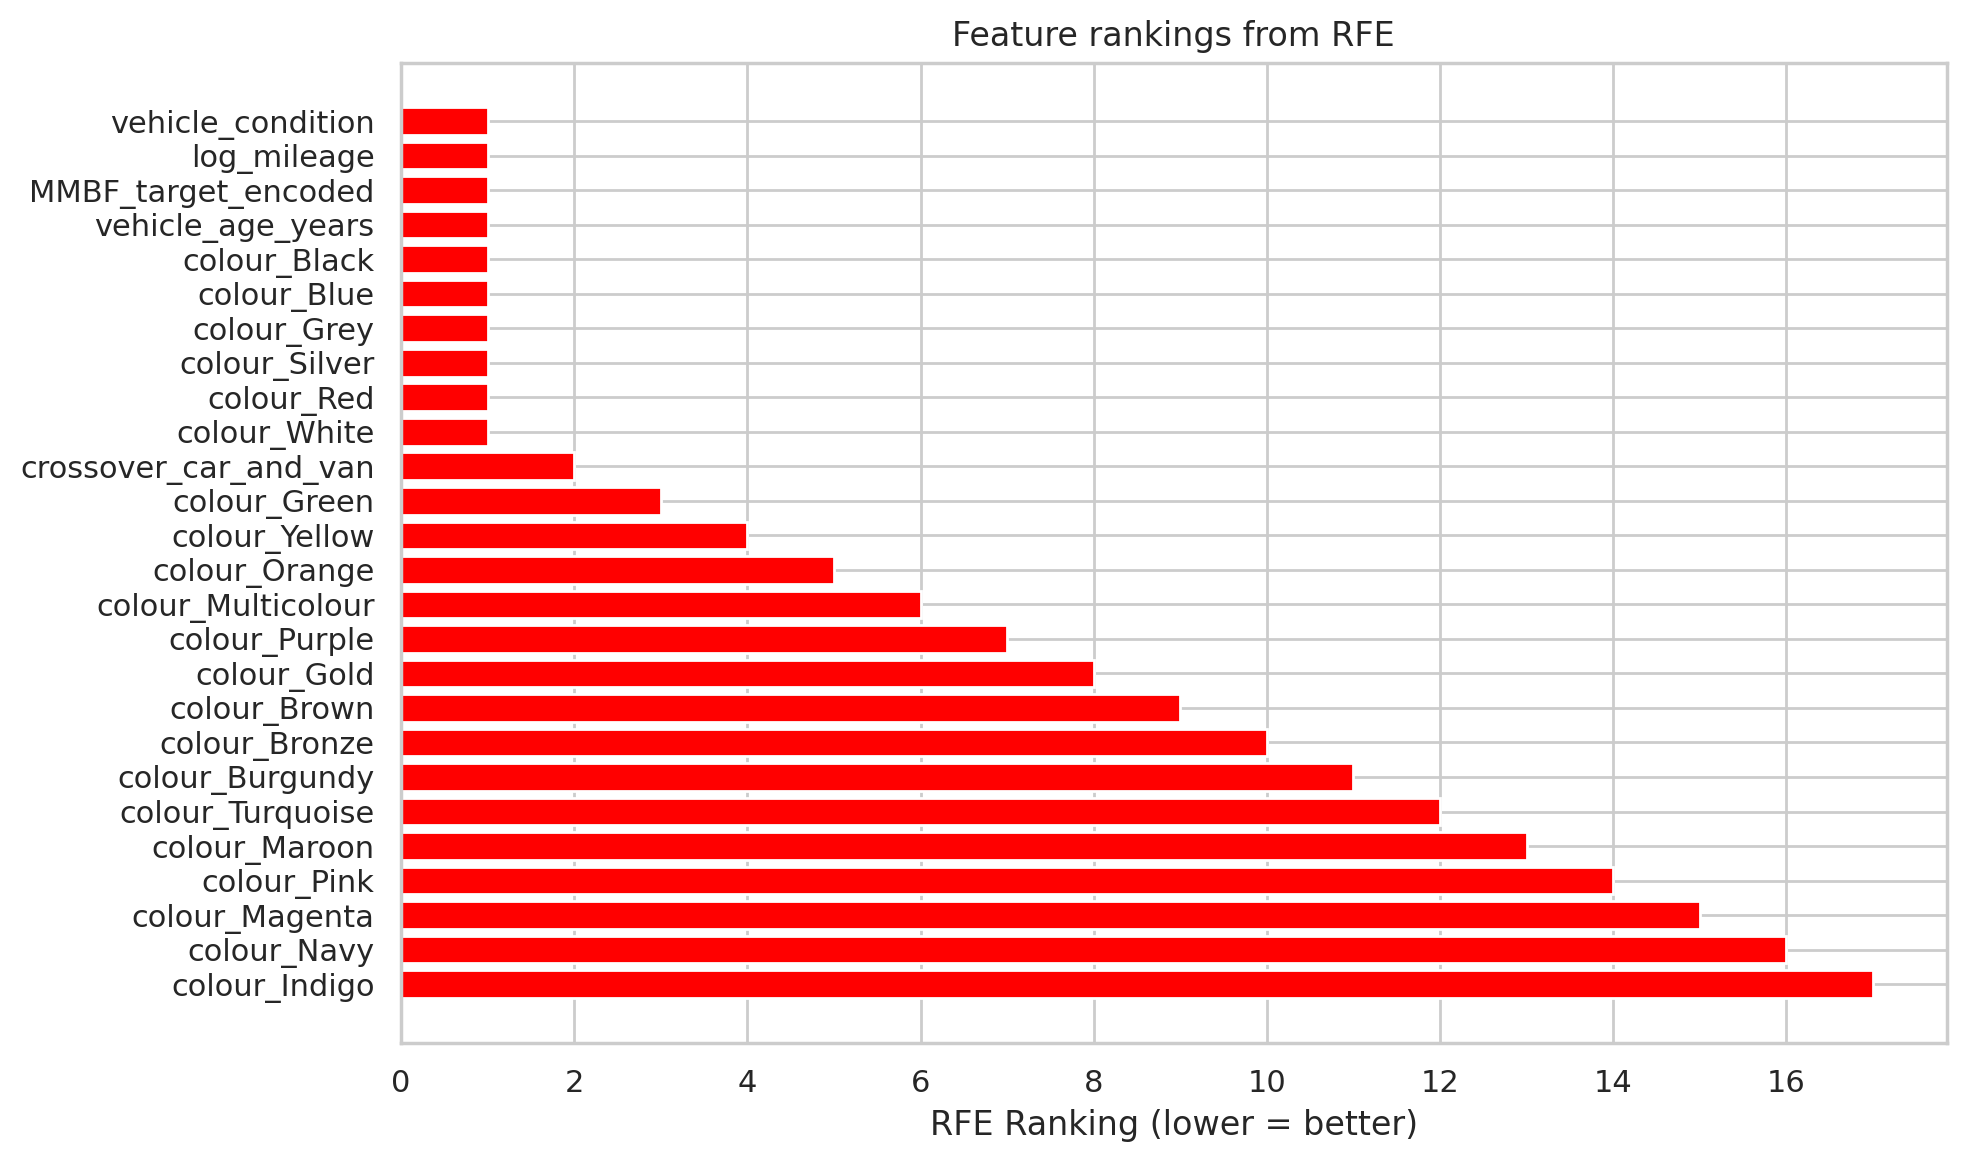

In [123]:
ranking_RFE = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': feature_ranks
}).sort_values(by='Ranking')

plt.figure(figsize=(10, 6))
plt.barh(ranking_RFE['Feature'], ranking_RFE['Ranking'], color='red')
plt.xlabel("RFE Ranking (lower = better)")
plt.title("Feature rankings from RFE")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Task 3 gradientboostedreggressor and random forest regressor

##random forest regreessor

In [124]:
#from sklearn.ensemble import RandomForestRegressor

#rf_model = RandomForestRegressor(
 #   n_estimators=100,
  #  max_depth=10,
   # random_state=42,
    #n_jobs=-1
#)

#rf_model.fit(X_train, y_train)


In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [126]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_val)

rf_mae = mean_absolute_error(y_val, rf_pred)
rf_rmse = mean_squared_error(y_val, rf_pred) ** 0.5
rf_r2 = r2_score(y_val, rf_pred)

print("Random Forest MAE:", rf_mae)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest R² Score:", rf_r2)


Random Forest MAE: 2739.6456595466143
Random Forest RMSE: 4520.13323330129
Random Forest R² Score: 0.9102320037422102


In [127]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
                           param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=3,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

best_rf_pred = best_rf.predict(X_val)
print("Tuned Random Forest MAE:", mean_absolute_error(y_val, best_rf_pred))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuned Random Forest MAE: 2216.1494421224234


In [128]:
print(grid_search.best_params_)


{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


In [129]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

best_rf_pred = best_rf.predict(X_val)

mae = mean_absolute_error(y_val, best_rf_pred)
mse = mean_squared_error(y_val, best_rf_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val, best_rf_pred)

print("Tuned Random Forest MAE:", mae)
print("Tuned Random Forest MSE:", mse)
print("Tuned Random Forest RMSE:", rmse)
print("Tuned Random Forest R² Score:", r2)


Tuned Random Forest MAE: 2216.1494421224234
Tuned Random Forest MSE: 15746263.005435871
Tuned Random Forest RMSE: 3968.156121605584
Tuned Random Forest R² Score: 0.930817450865055


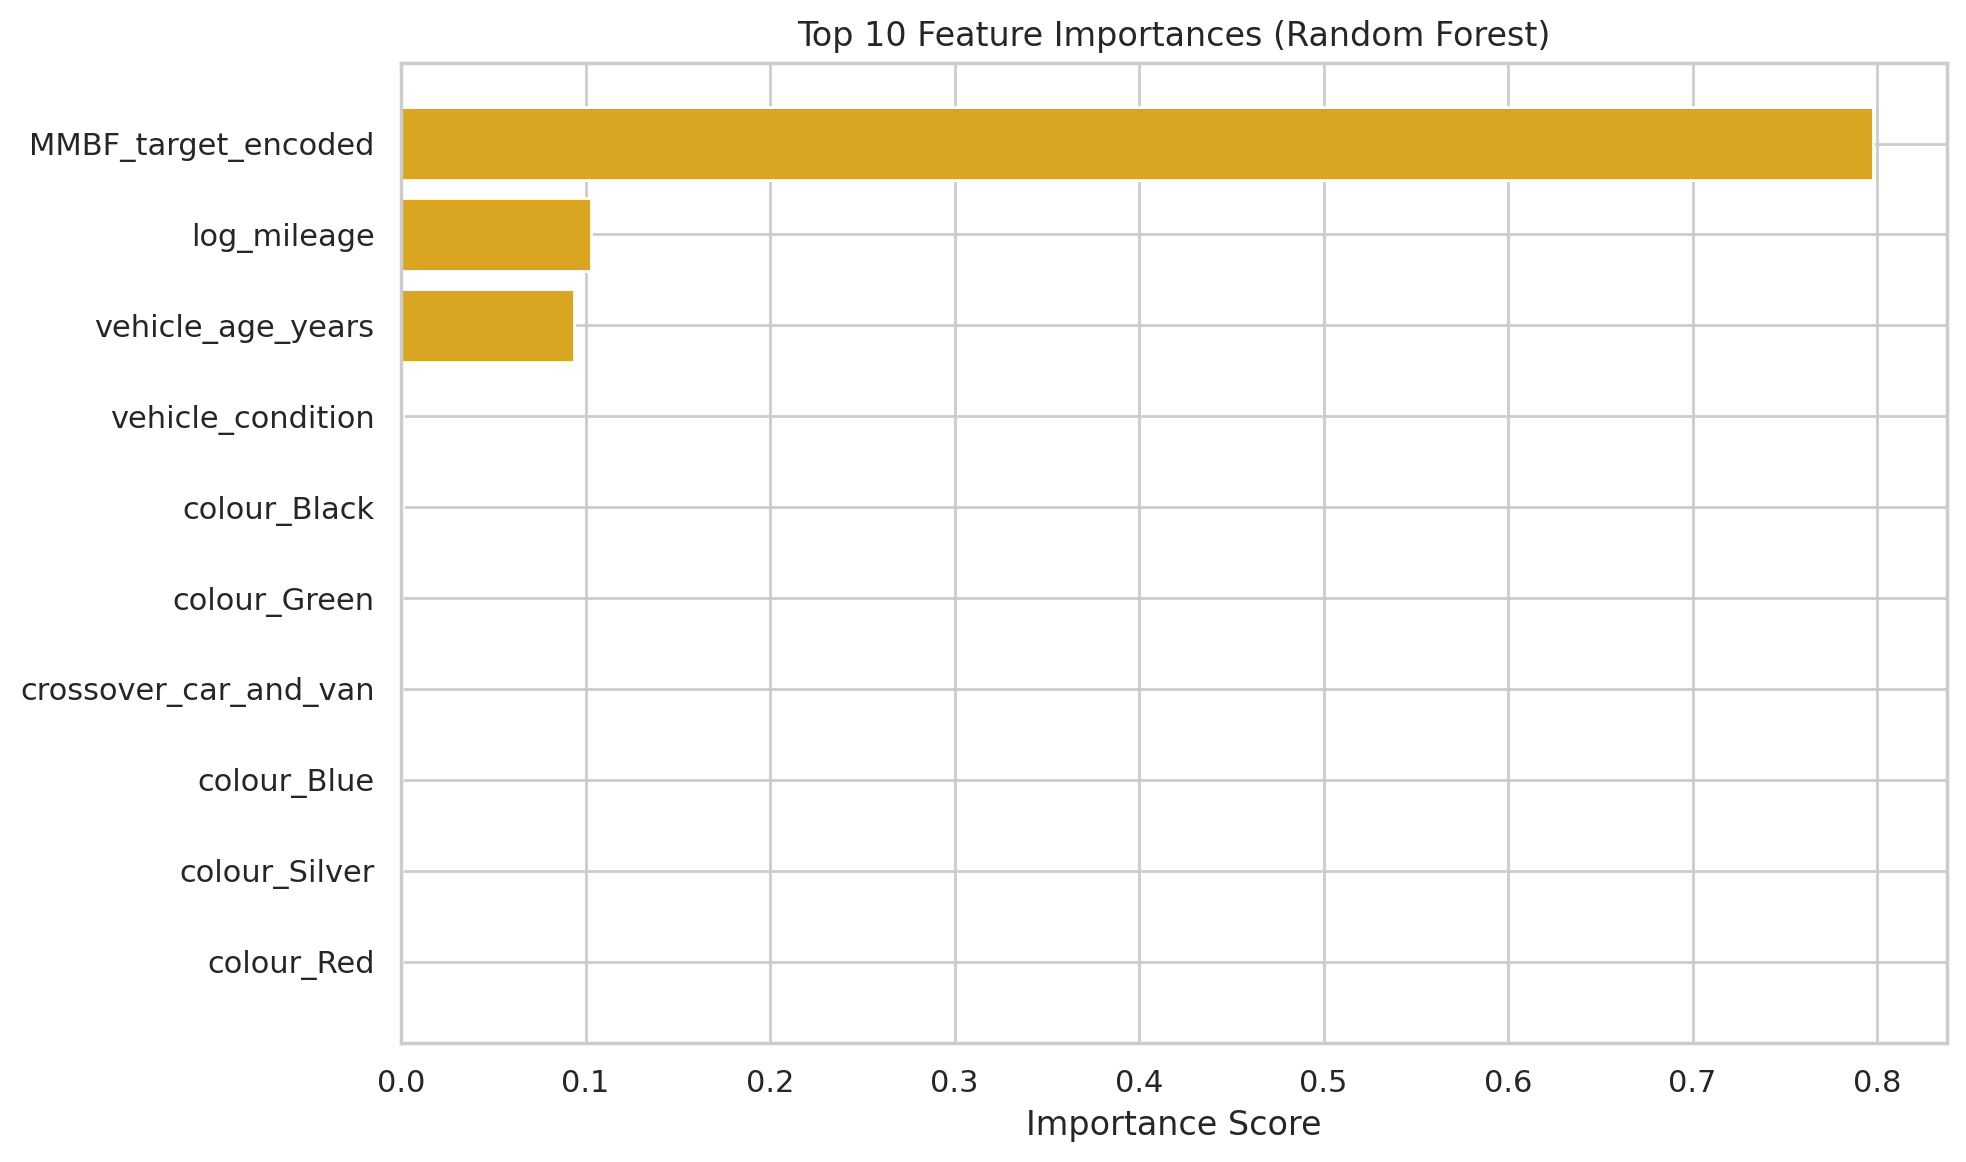

In [130]:
rf_importances = rf_model.feature_importances_

rf_feat_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(rf_feat_df['Feature'][:10][::-1], rf_feat_df['Importance'][:10][::-1], color='goldenrod')
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


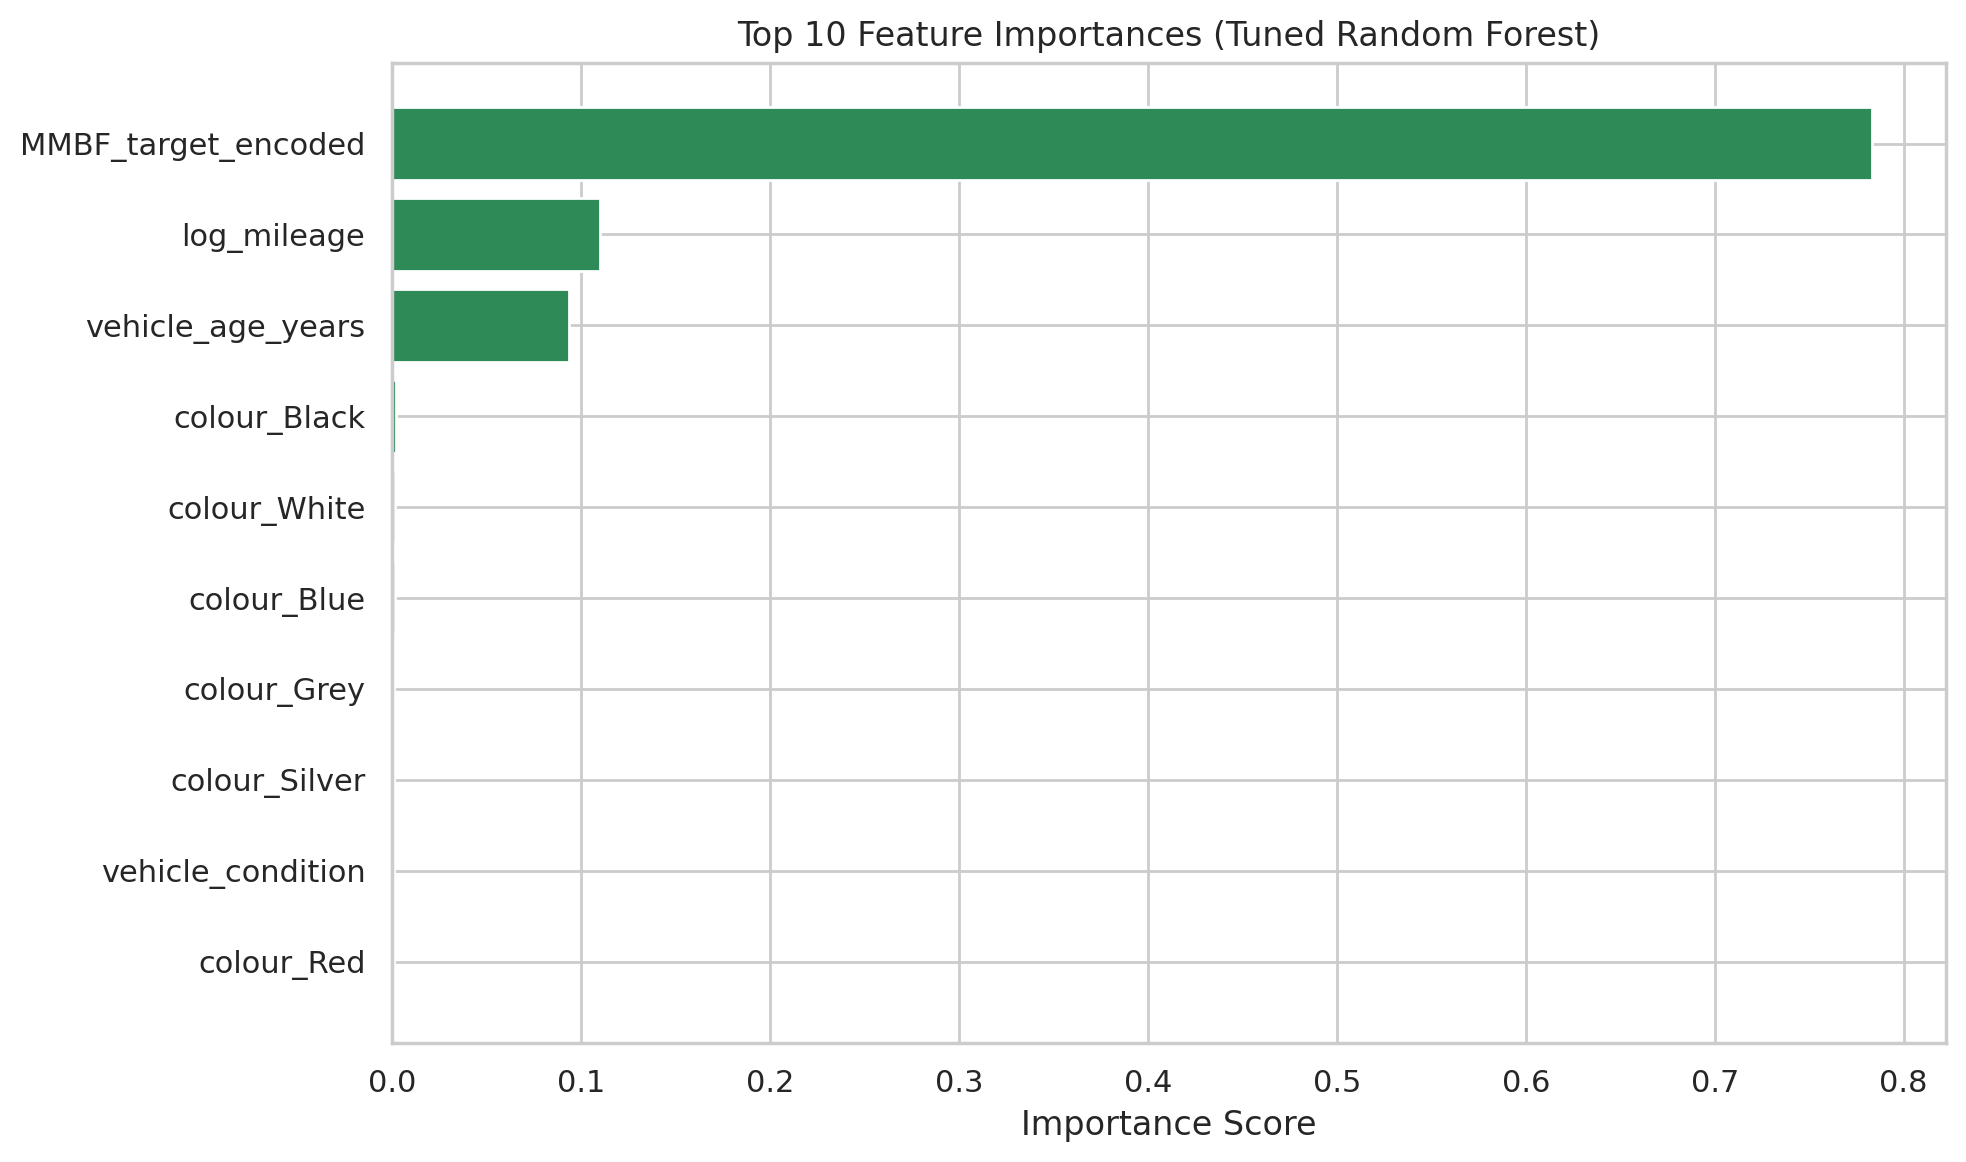

In [131]:
best_rf_importances = best_rf.feature_importances_

best_rf_feat_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(best_rf_feat_df['Feature'][:10][::-1], best_rf_feat_df['Importance'][:10][::-1], color='seagreen')
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances (Tuned Random Forest)")
plt.tight_layout()
plt.show()


##gradient boosting regressor

In [132]:
gbr_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

gbr_model.fit(X_train, y_train)
gbr_pred = gbr_model.predict(X_val)

In [133]:
gbr_mae = mean_absolute_error(y_val, gbr_pred)
gbr_rmse = mean_squared_error(y_val, gbr_pred) ** 0.5
gbr_r2 = r2_score(y_val, gbr_pred)

print("Gradient Boosting MAE:", gbr_mae)
print("Gradient Boosting RMSE:", gbr_rmse)
print("Gradient Boosting R² Score:", gbr_r2)

Gradient Boosting MAE: 2695.8320477934517
Gradient Boosting RMSE: 4433.987896828252
Gradient Boosting R² Score: 0.9136210211213946


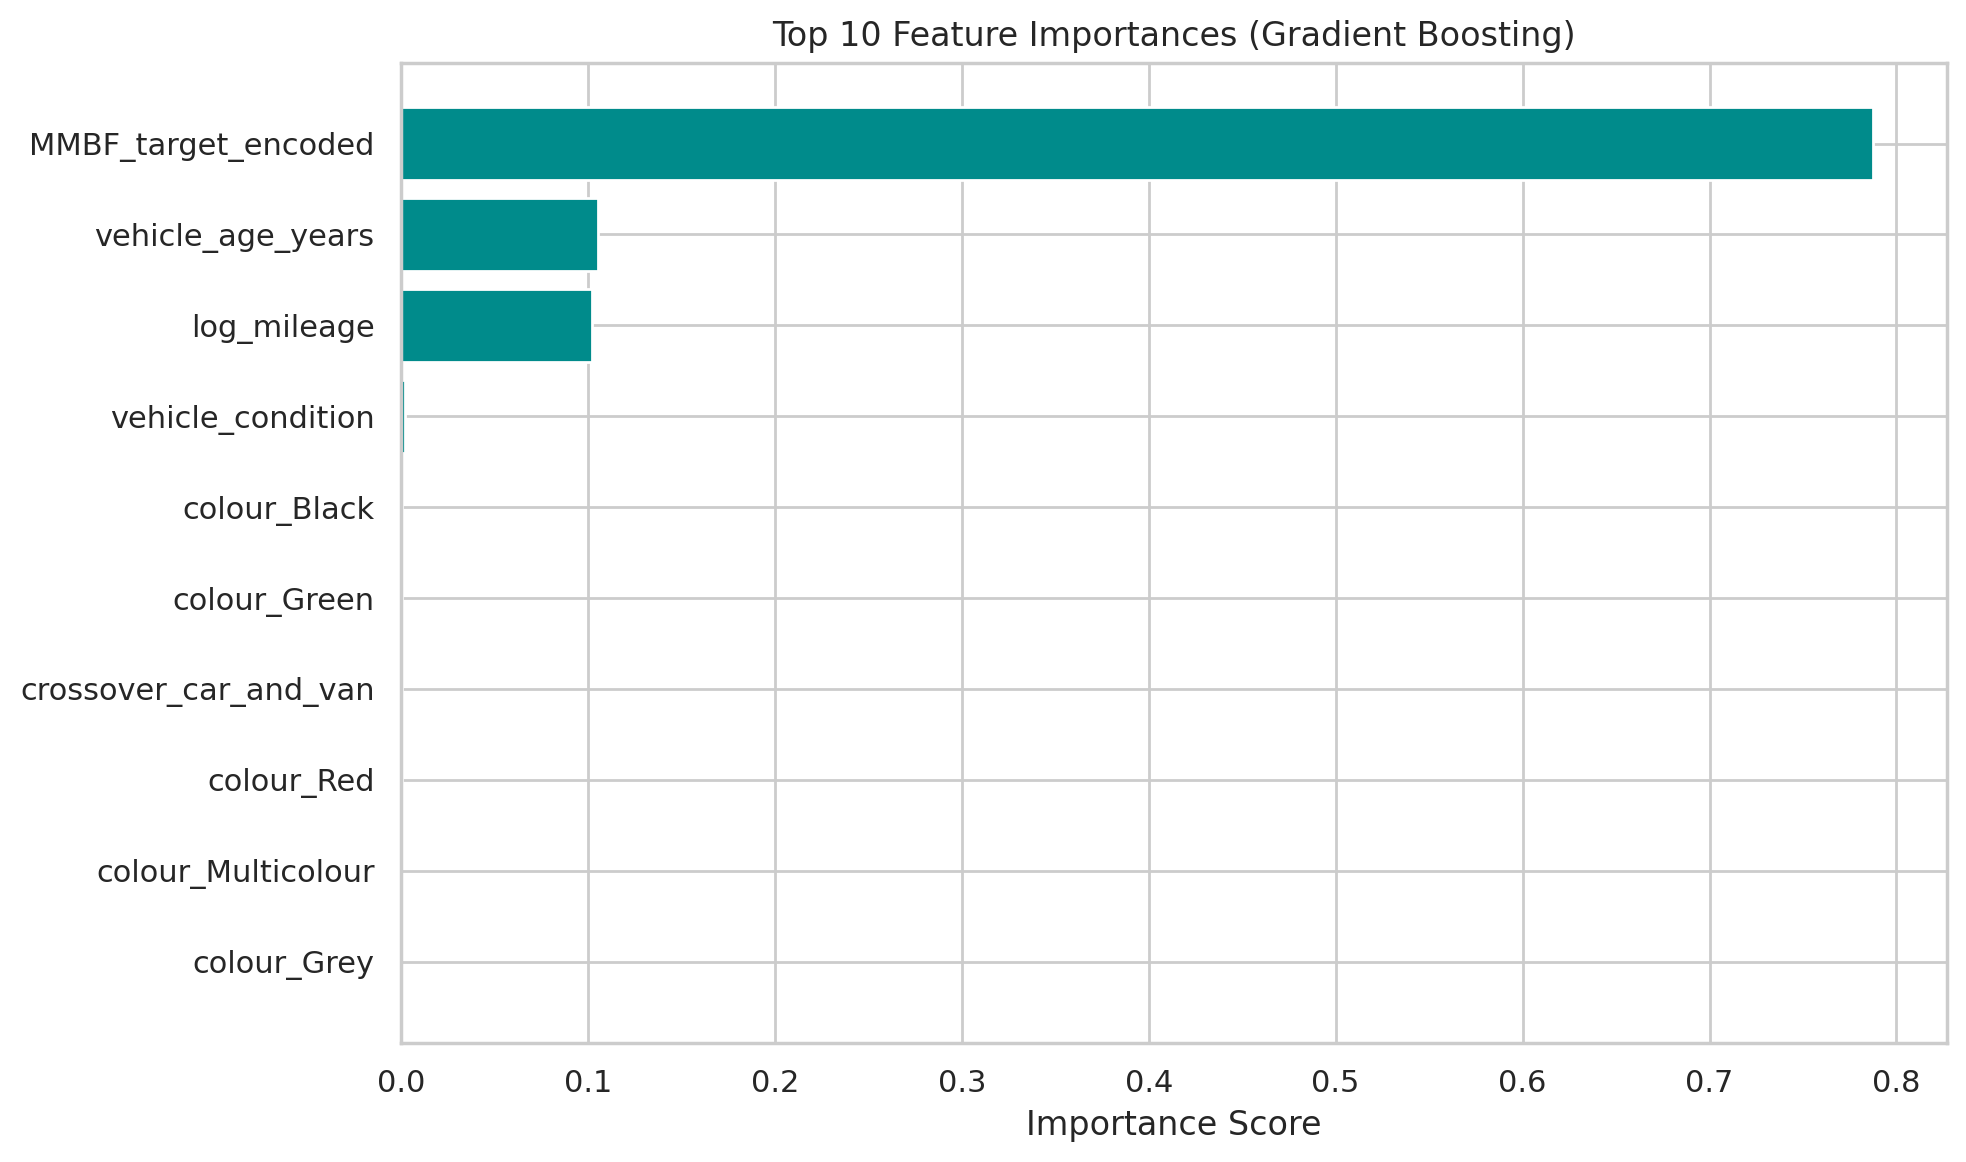

In [134]:
gbr_importances = gbr_model.feature_importances_

gbr_feat_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gbr_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(gbr_feat_df['Feature'][:10][::-1], gbr_feat_df['Importance'][:10][::-1], color='darkcyan')
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances (Gradient Boosting)")
plt.tight_layout()
plt.show()


In [135]:
# cv_model = GradientBoostingRegressor(
#     n_estimators=200,
#     learning_rate=0.1,
#     max_depth=5,
#     subsample=0.8,
#     random_state=42
# )

# cv_scores = cross_val_score(cv_model, X, y, cv=5, scoring='neg_mean_absolute_error')
# cv_mae_scores = -cv_scores

# print("MAE scores from 5-fold CV:", cv_mae_scores)
# print("Average MAE:", cv_mae_scores.mean())


In [136]:
from sklearn.model_selection import cross_validate

cv_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

# Use cross_validate instead of cross_val_score
cv_results = cross_validate(cv_model, X, y, cv=5, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])

# Flip negative scores to positive
mae_scores = -cv_results['test_neg_mean_absolute_error']
mse_scores = -cv_results['test_neg_mean_squared_error']
rmse_scores = mse_scores ** 0.5
r2_scores = cv_results['test_r2']

# Print averages
print("Average MAE:", mae_scores.mean())
print("Average RMSE:", rmse_scores.mean())
print("Average R²:", r2_scores.mean())


Average MAE: 2693.860977641106
Average RMSE: 4494.970676285957
Average R²: 0.9109060343224712


In [137]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split  # Import train_test_split

# # Assuming X and y are your feature and target data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data

# rf_model = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=10,
#     random_state=42,
#     n_jobs=-1
# )

# rf_model.fit(X_train, y_train)  # Now X_train and y_train are defined

#task 4 Ensemble of Tree Ensembles

gradident boosting + random forest

In [138]:
# predictions from both models (on validation set)
gbr_pred = gbr_model.predict(X_val)
tuned_rf_pred = best_rf.predict(X_val)


# weighted average
ensemble_pred = 0.7 * tuned_rf_pred + 0.3 * gbr_pred

In [139]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

ensemble_mae = mean_absolute_error(y_val, ensemble_pred)
ensemble_mse = mean_squared_error(y_val, ensemble_pred)
ensemble_rmse = ensemble_mse ** 0.5
ensemble_r2 = r2_score(y_val, ensemble_pred)

print("Weighted Ensemble MAE:", ensemble_mae)
print("Weighted Ensemble RMSE:", ensemble_rmse)
print("Weighted Ensemble R² Score:", ensemble_r2)


Weighted Ensemble MAE: 2276.017090209384
Weighted Ensemble RMSE: 3975.1994195208817
Weighted Ensemble R² Score: 0.9305716411069678


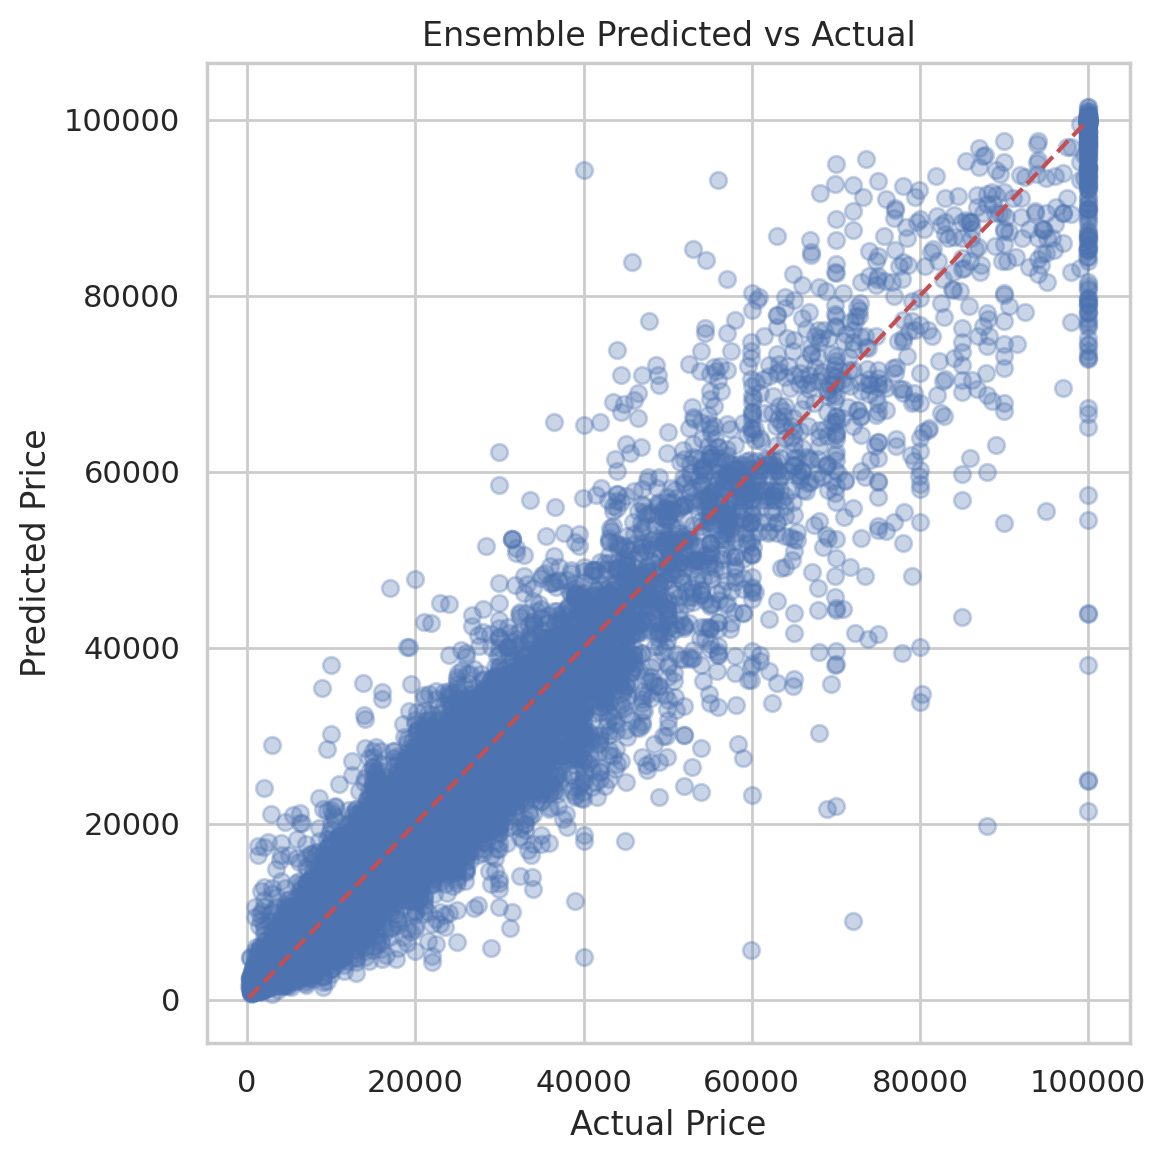

In [140]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, ensemble_pred, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Ensemble Predicted vs Actual")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.tight_layout()
plt.show()


##stacking ensemble

In [141]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# define base mmodels
estimators = [
    ('rf', best_rf),
    ('gbr', gbr_model)
]

# stacking regressor with lineear model as final estimatorr
stacked = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    passthrough=False,
    cv=5,
    n_jobs=-1
)

stacked.fit(X_train, y_train)


StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=20,
                                                     min_samples_split=5,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('gbr',
                               GradientBoostingRegressor(max_depth=5,
                                                         n_estimators=200,
                                                         random_state=42,
                                                         subsample=0.8))],
                  final_estimator=LinearRegression(), n_jobs=-1)

In [142]:
# evaluate on the validatiion set
stacked_pred = stacked.predict(X_val)

stacked_mae = mean_absolute_error(y_val, stacked_pred)
stacked_mse = mean_squared_error(y_val, stacked_pred)
stacked_rmse = stacked_mse ** 0.5
stacked_r2 = r2_score(y_val, stacked_pred)

print("Stacked Ensemble MAE:", stacked_mae)
print("Stacked Ensemble RMSE:", stacked_rmse)
print("Stacked Ensemble R² Score:", stacked_r2)


Stacked Ensemble MAE: 2233.8274694036777
Stacked Ensemble RMSE: 3956.7022408557223
Stacked Ensemble R² Score: 0.9312162582808234


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


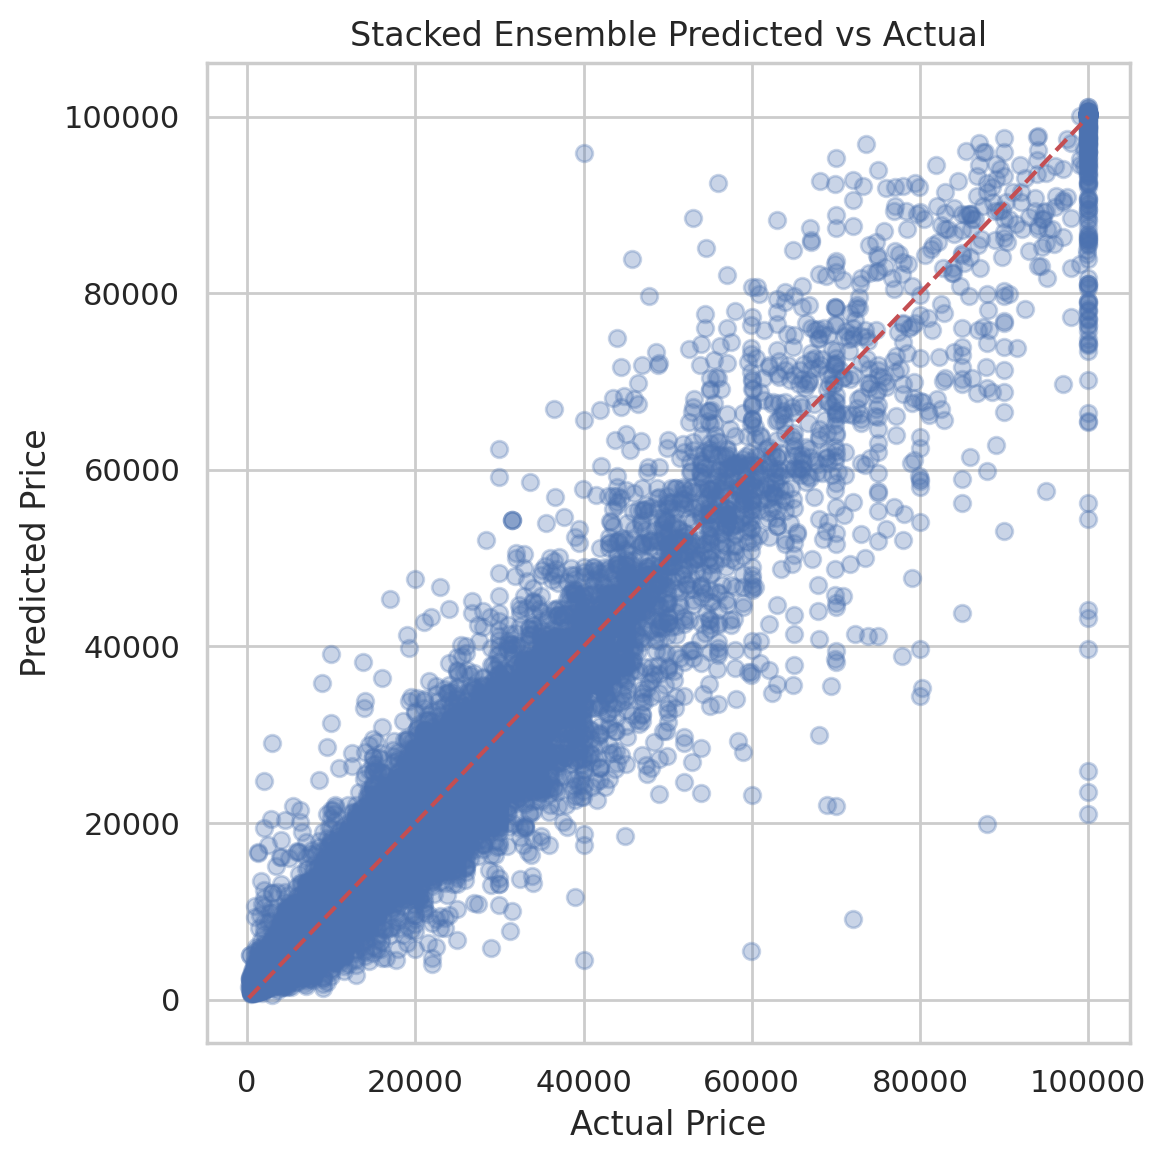

In [143]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, stacked_pred, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Stacked Ensemble Predicted vs Actual")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.tight_layout()
plt.show()


##Feature Importance via permutation importance and SHAP.

###gradident boosting regrssor and fined tuned rf

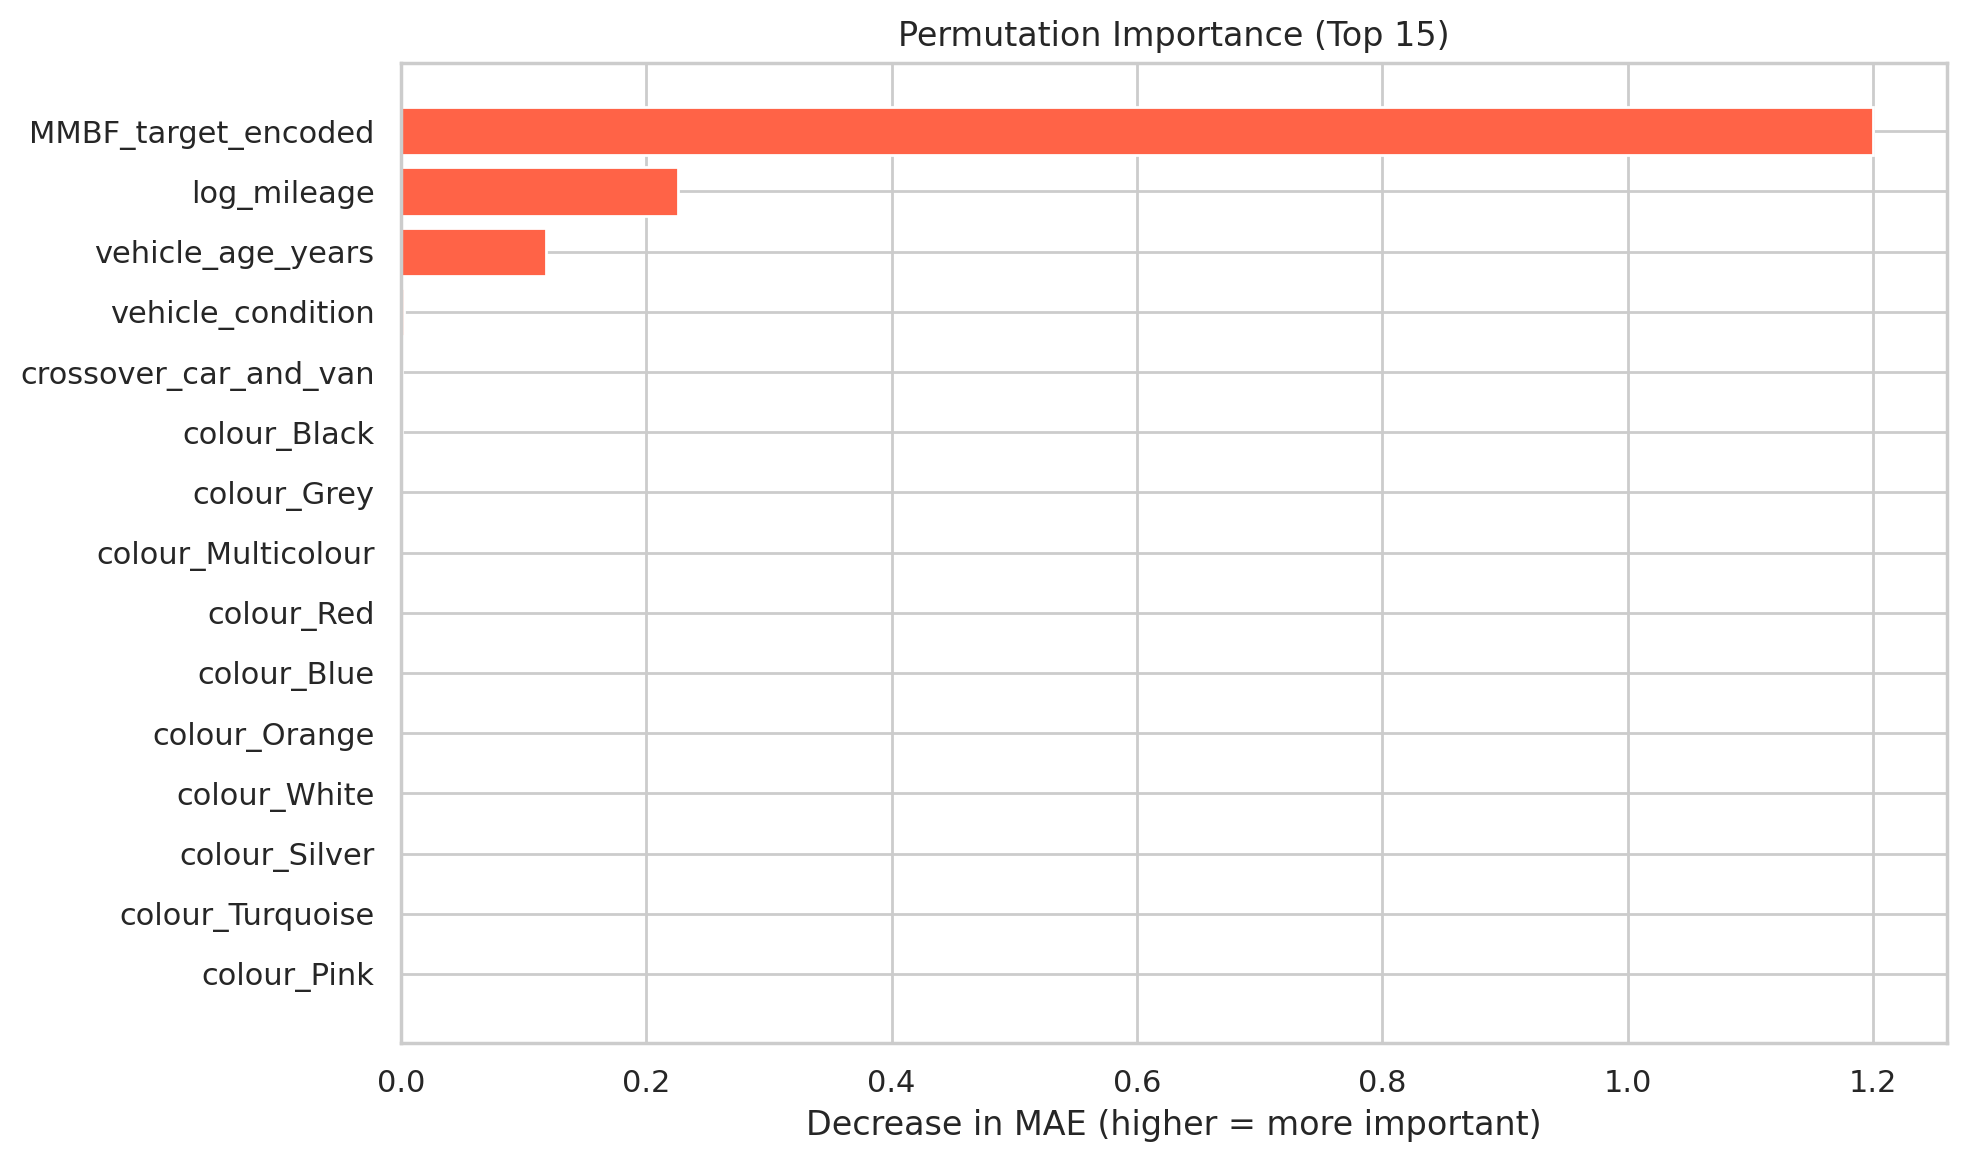

In [144]:
from sklearn.inspection import permutation_importance

# run permutation importance on validation set
perm_result = permutation_importance(
    gbr_model, X_val, y_val,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# sort results
perm_sorted_idx = perm_result.importances_mean.argsort()[::-1]

# take top 15 for display
top_perm_idx = perm_sorted_idx[:15]
top_perm_features = X_val.columns[top_perm_idx]
top_perm_scores = perm_result.importances_mean[top_perm_idx]

# plot
plt.figure(figsize=(10, 6))
plt.barh(top_perm_features[::-1], top_perm_scores[::-1], color='tomato')
plt.xlabel("Decrease in MAE (higher = more important)")
plt.title("Permutation Importance (Top 15)")
plt.tight_layout()
plt.show()


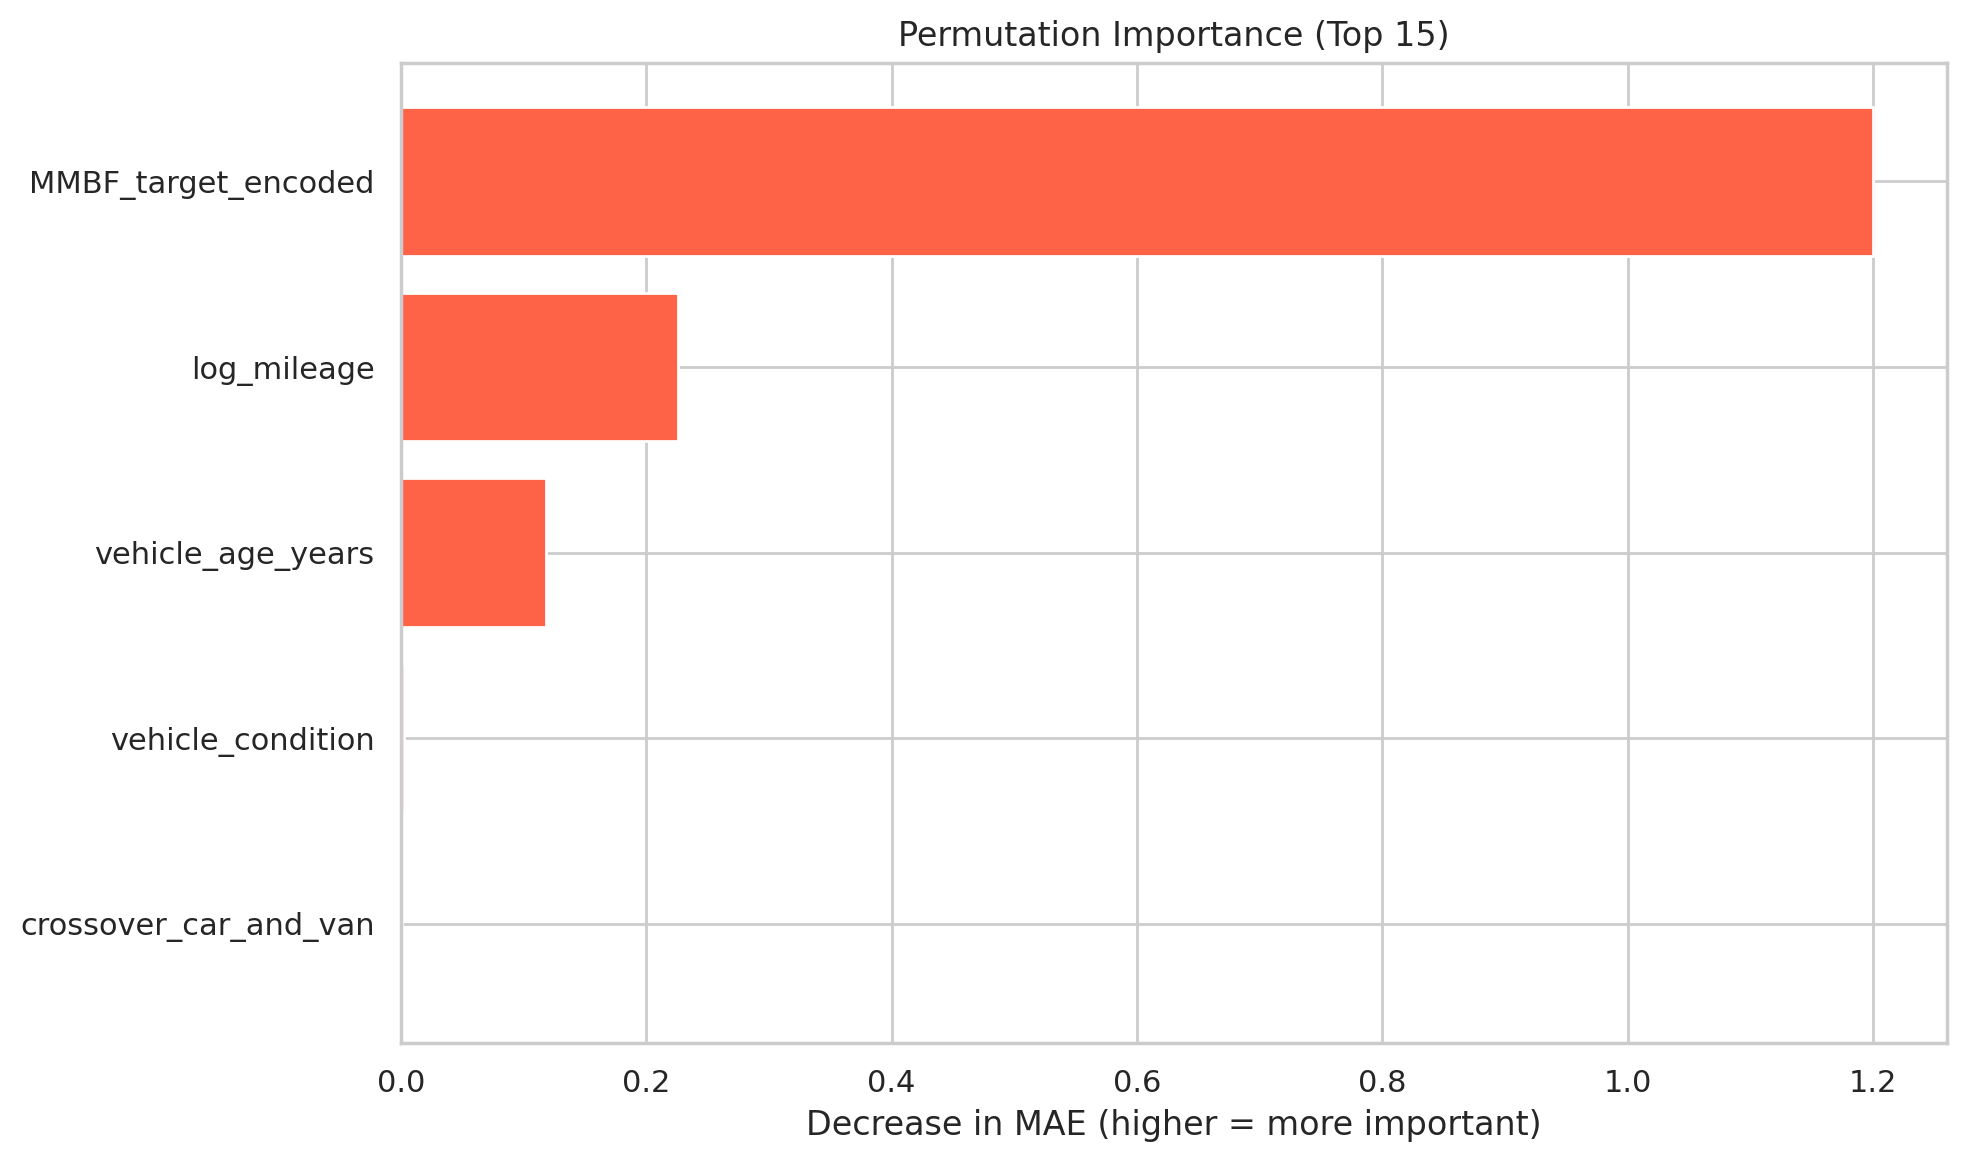

In [145]:
# take top 15 for display
top_perm_idx = perm_sorted_idx[:5]
top_perm_features = X_val.columns[top_perm_idx]
top_perm_scores = perm_result.importances_mean[top_perm_idx]

# plot
plt.figure(figsize=(10, 6))
plt.barh(top_perm_features[::-1], top_perm_scores[::-1], color='tomato')
plt.xlabel("Decrease in MAE (higher = more important)")
plt.title("Permutation Importance (Top 15)")
plt.tight_layout()
plt.show()

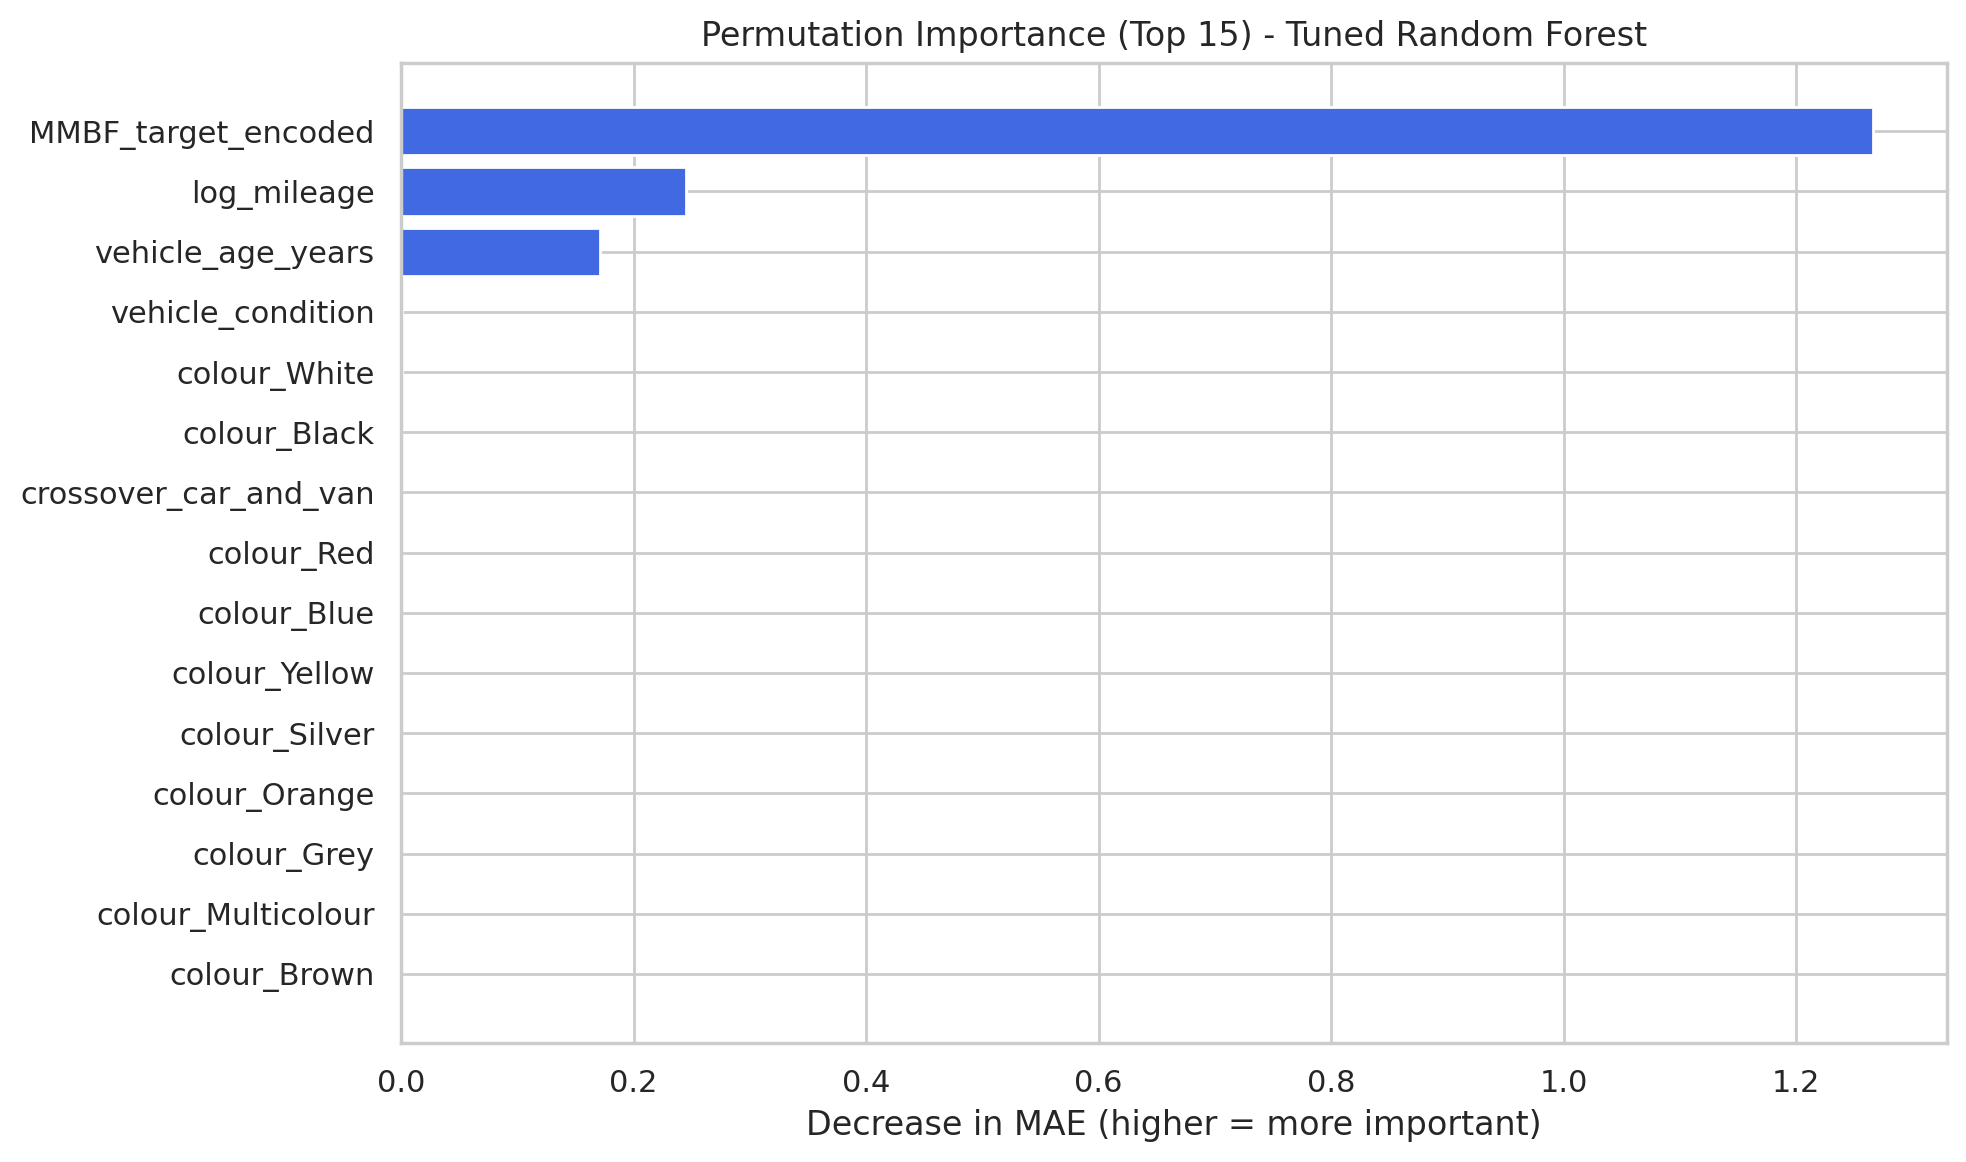

In [146]:
perm_result_rf = permutation_importance(
    best_rf, X_val, y_val,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

perm_sorted_idx_rf = perm_result_rf.importances_mean.argsort()[::-1]
top_perm_idx_rf = perm_sorted_idx_rf[:15]
top_perm_features_rf = X_val.columns[top_perm_idx_rf]
top_perm_scores_rf = perm_result_rf.importances_mean[top_perm_idx_rf]

plt.figure(figsize=(10, 6))
plt.barh(top_perm_features_rf[::-1], top_perm_scores_rf[::-1], color='royalblue')
plt.xlabel("Decrease in MAE (higher = more important)")
plt.title("Permutation Importance (Top 15) - Tuned Random Forest")
plt.tight_layout()
plt.show()


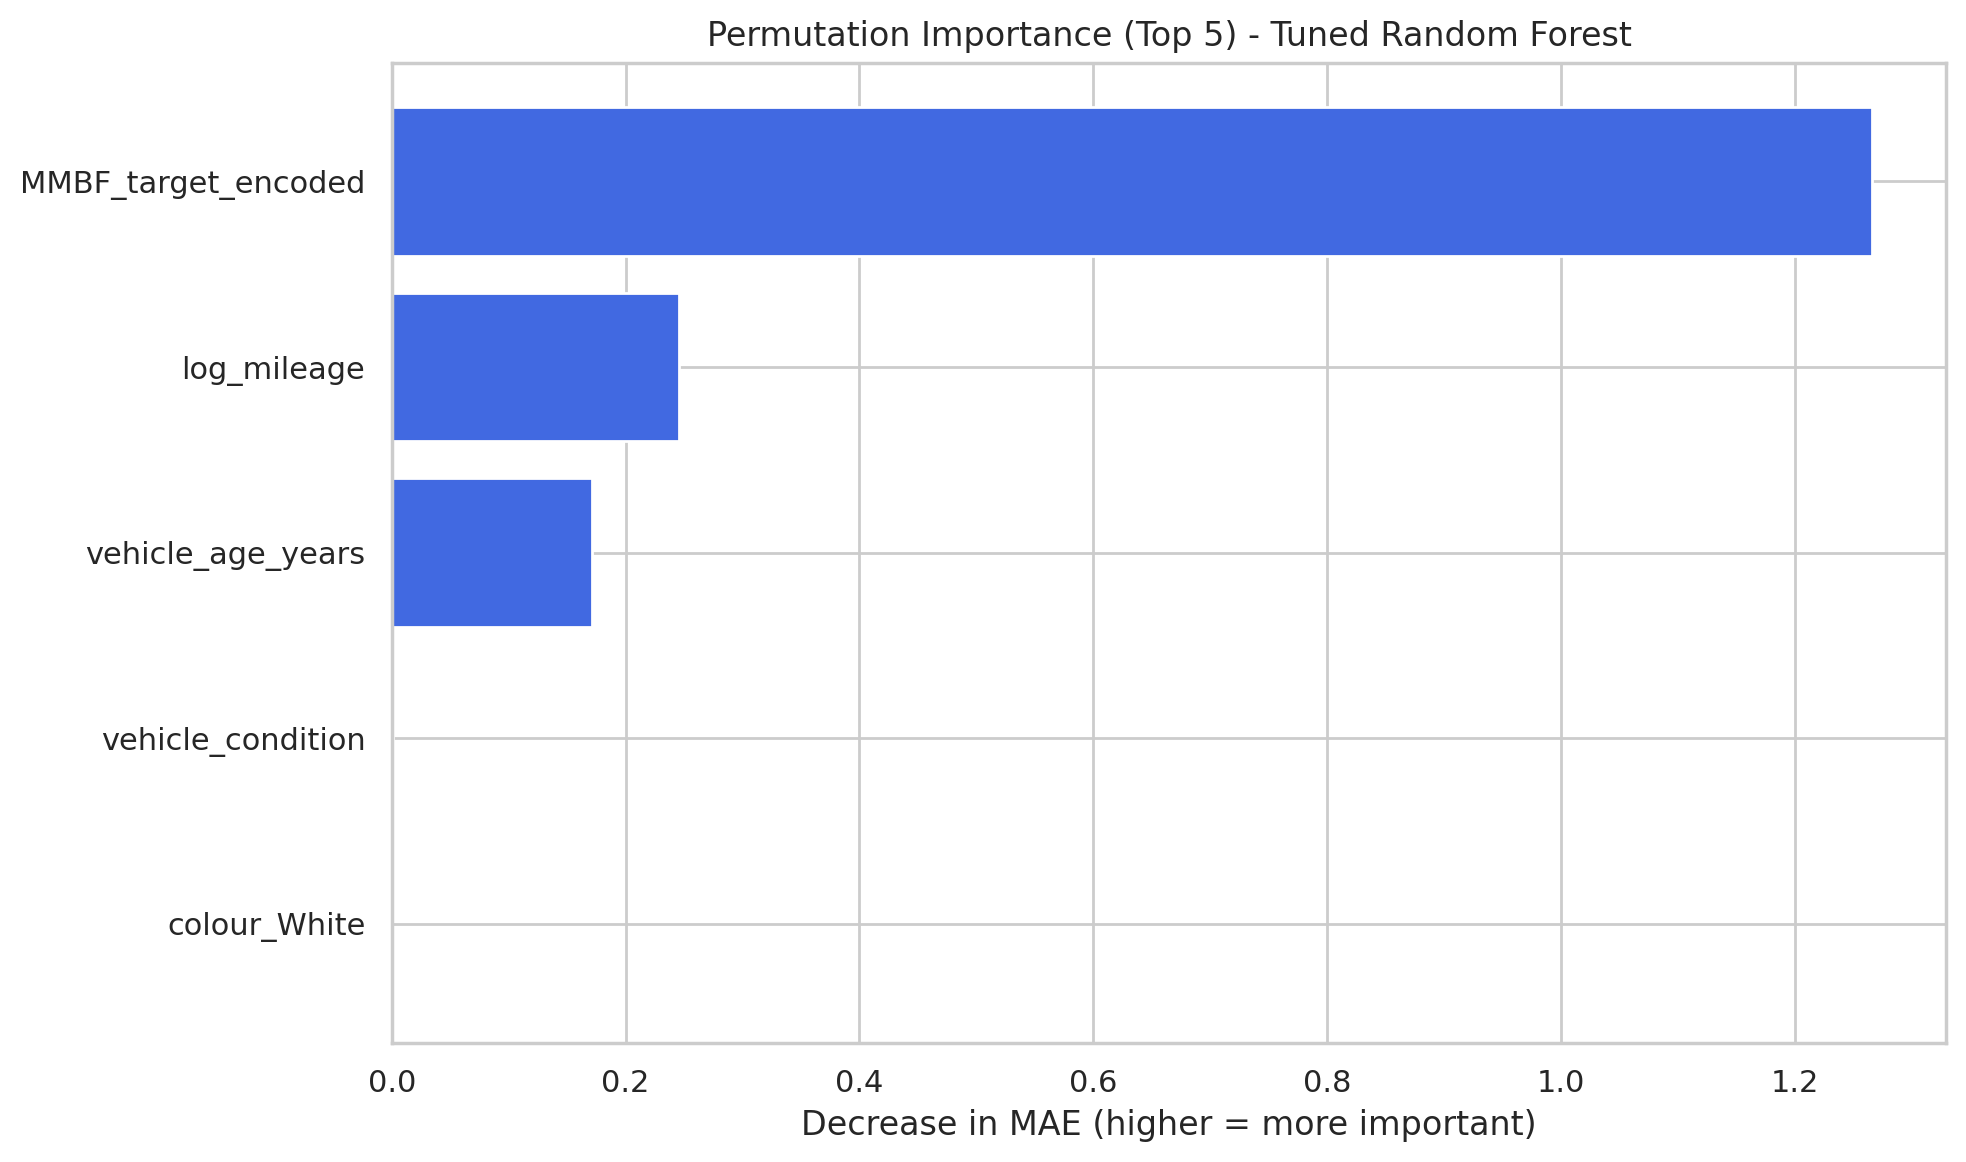

In [147]:
perm_result_rf = permutation_importance(
    best_rf, X_val, y_val,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

perm_sorted_idx_rf = perm_result_rf.importances_mean.argsort()[::-1]
top_perm_idx_rf = perm_sorted_idx_rf[:5]
top_perm_features_rf = X_val.columns[top_perm_idx_rf]
top_perm_scores_rf = perm_result_rf.importances_mean[top_perm_idx_rf]

plt.figure(figsize=(10, 6))
plt.barh(top_perm_features_rf[::-1], top_perm_scores_rf[::-1], color='royalblue')
plt.xlabel("Decrease in MAE (higher = more important)")
plt.title("Permutation Importance (Top 5) - Tuned Random Forest")
plt.tight_layout()
plt.show()

##shapp on gbr and tuned rf

In [148]:
import shap

# create explainer for the gradient boosting model
explainer = shap.Explainer(gbr_model)
shap_values = explainer(X_val)


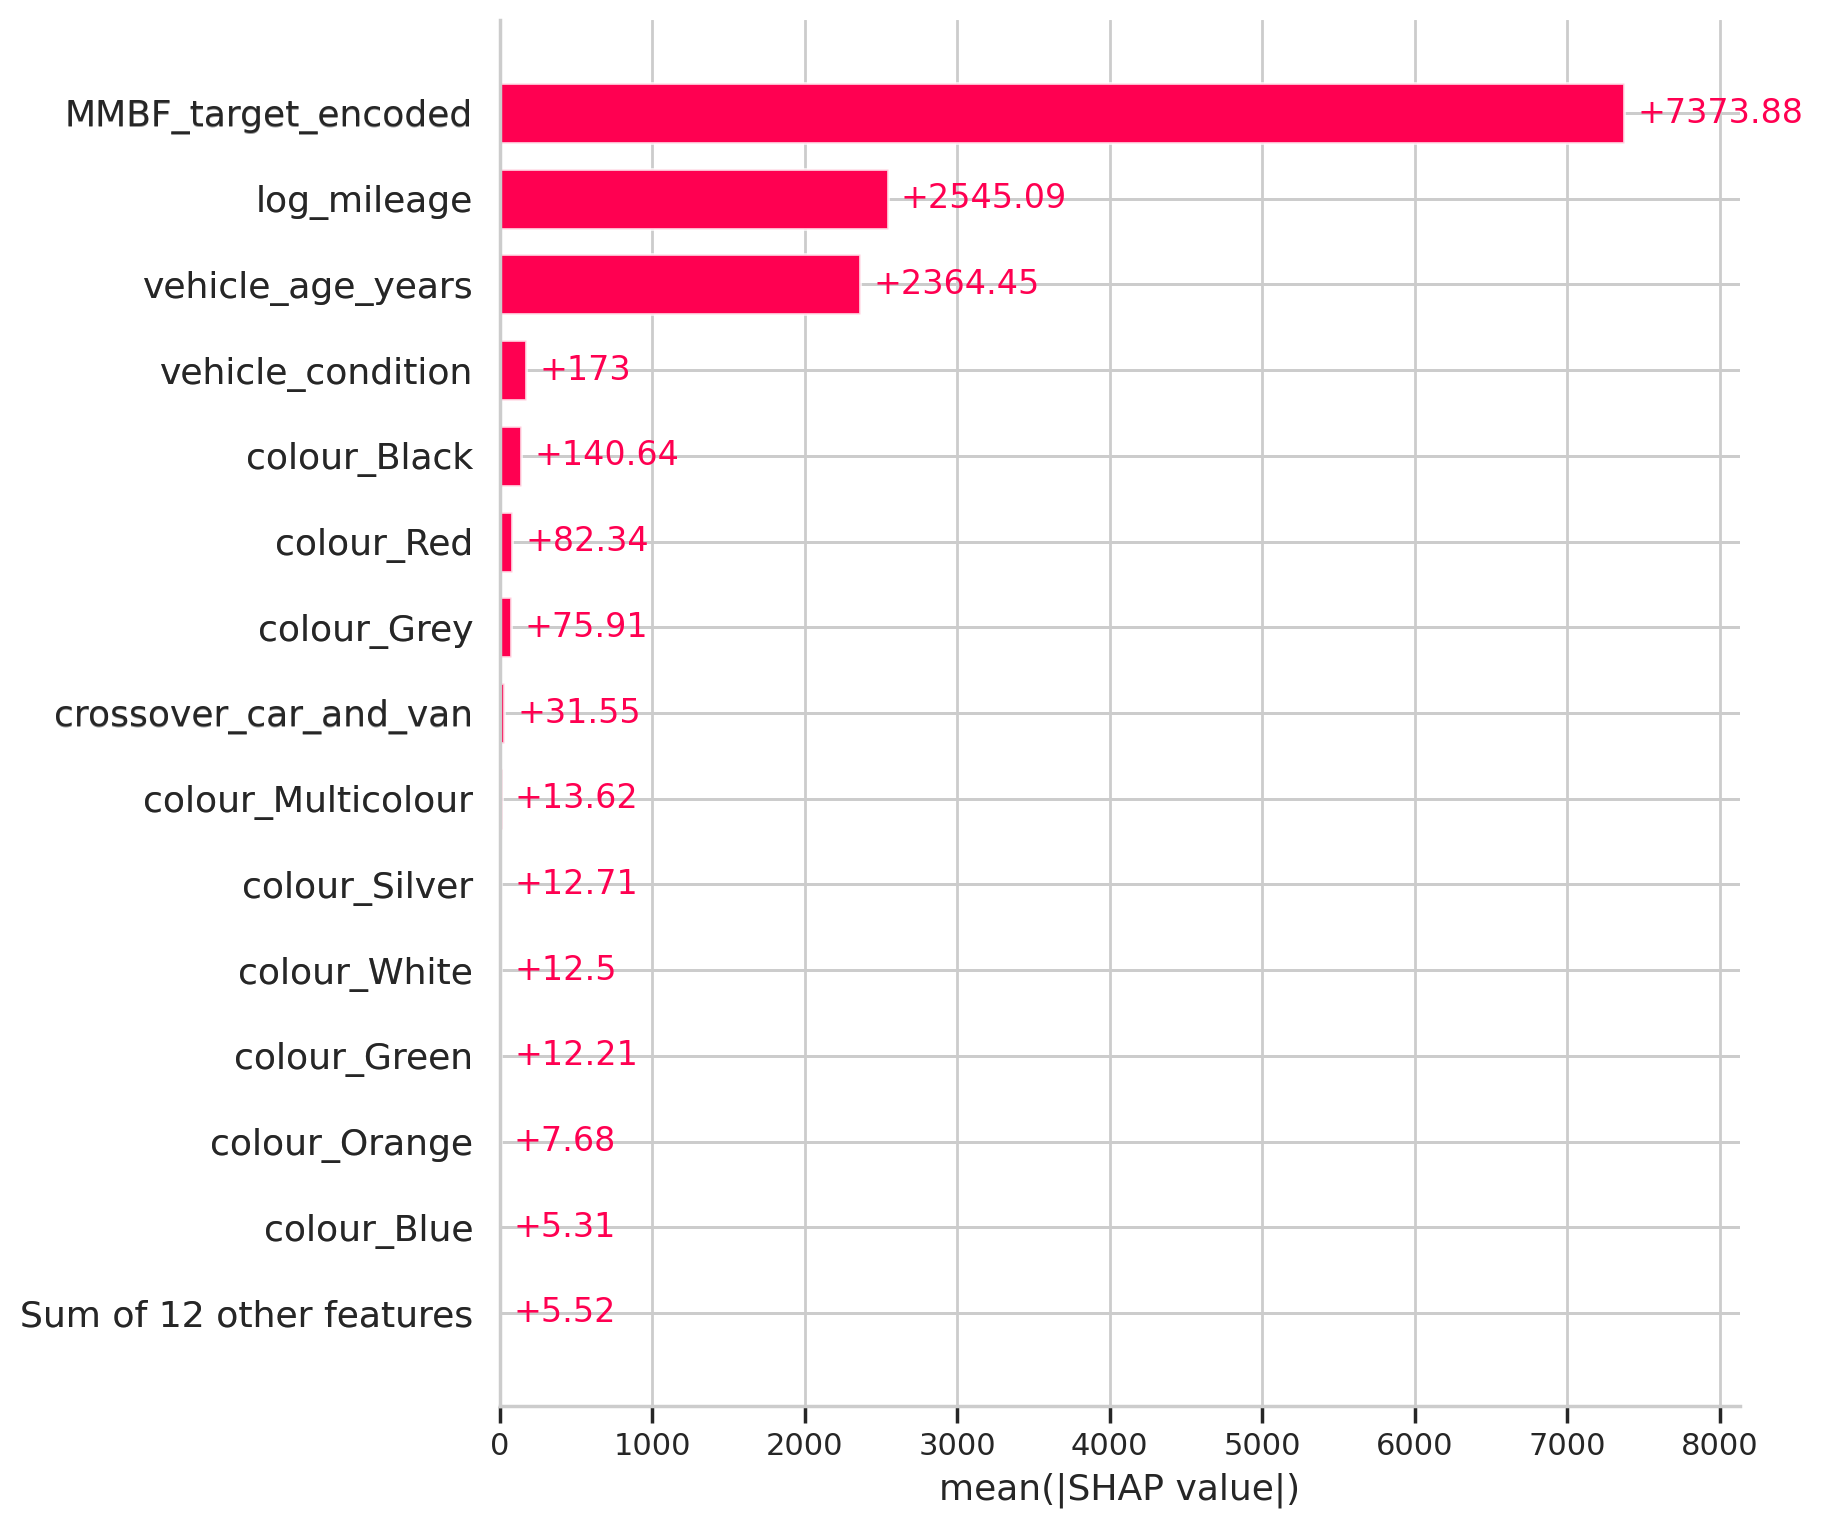

In [149]:
# global importance (bar plot)
shap.plots.bar(shap_values, max_display=15)


In [ ]:
# global importancee (bar plot)
shap.plots.bar(shap_values, max_display=5)

In [ ]:
shap.plots.beeswarm(shap_values, max_display=15)


In [ ]:
shap.plots.beeswarm(shap_values, max_display=5)

In [153]:
# # create explainer for the tuned rf model
# #explainer = shap.Explainer(best_rf)
# explainer = shap.TreeExplainer(best_rf)
# shap_values = explainer(X_val)

In [ ]:
import shap
shap.initjs()

# Sample for speed
X_val_sampled = X_val.sample(n=1000, random_state=42)

# Freshh TreeExplainer for best_rf doesnt work othwerwiseee
explainer_rf = shap.TreeExplainer(best_rf)

# Compute SHAP values
shap_values_rf = explainer_rf(X_val_sampled)

shap.plots.beeswarm(shap_values_rf)


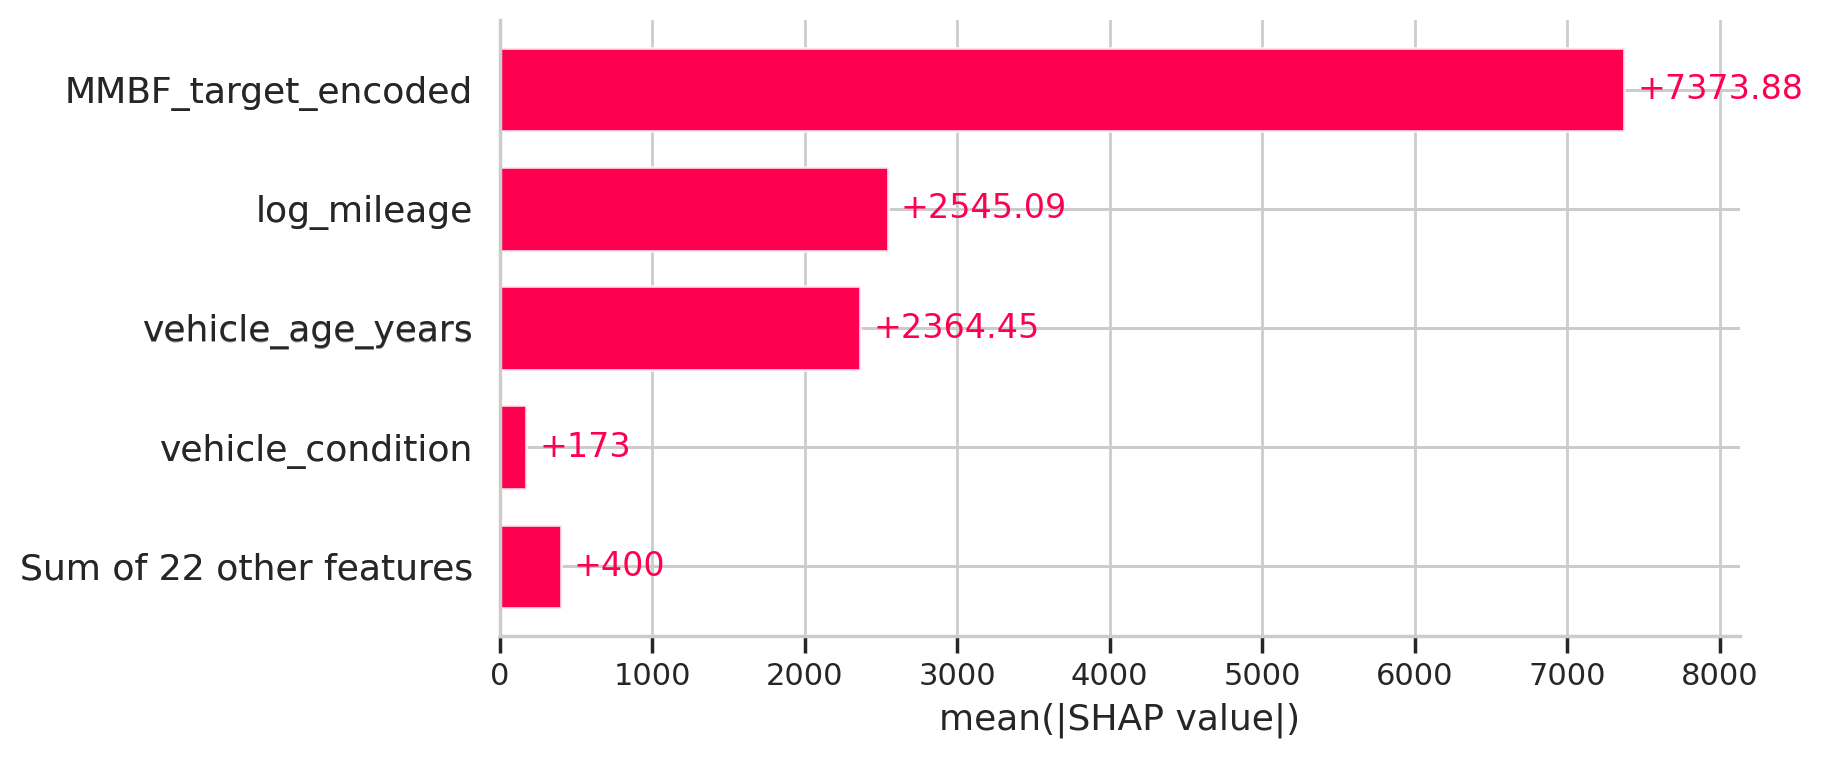

In [155]:
shap.plots.bar(shap_values, max_display=5)

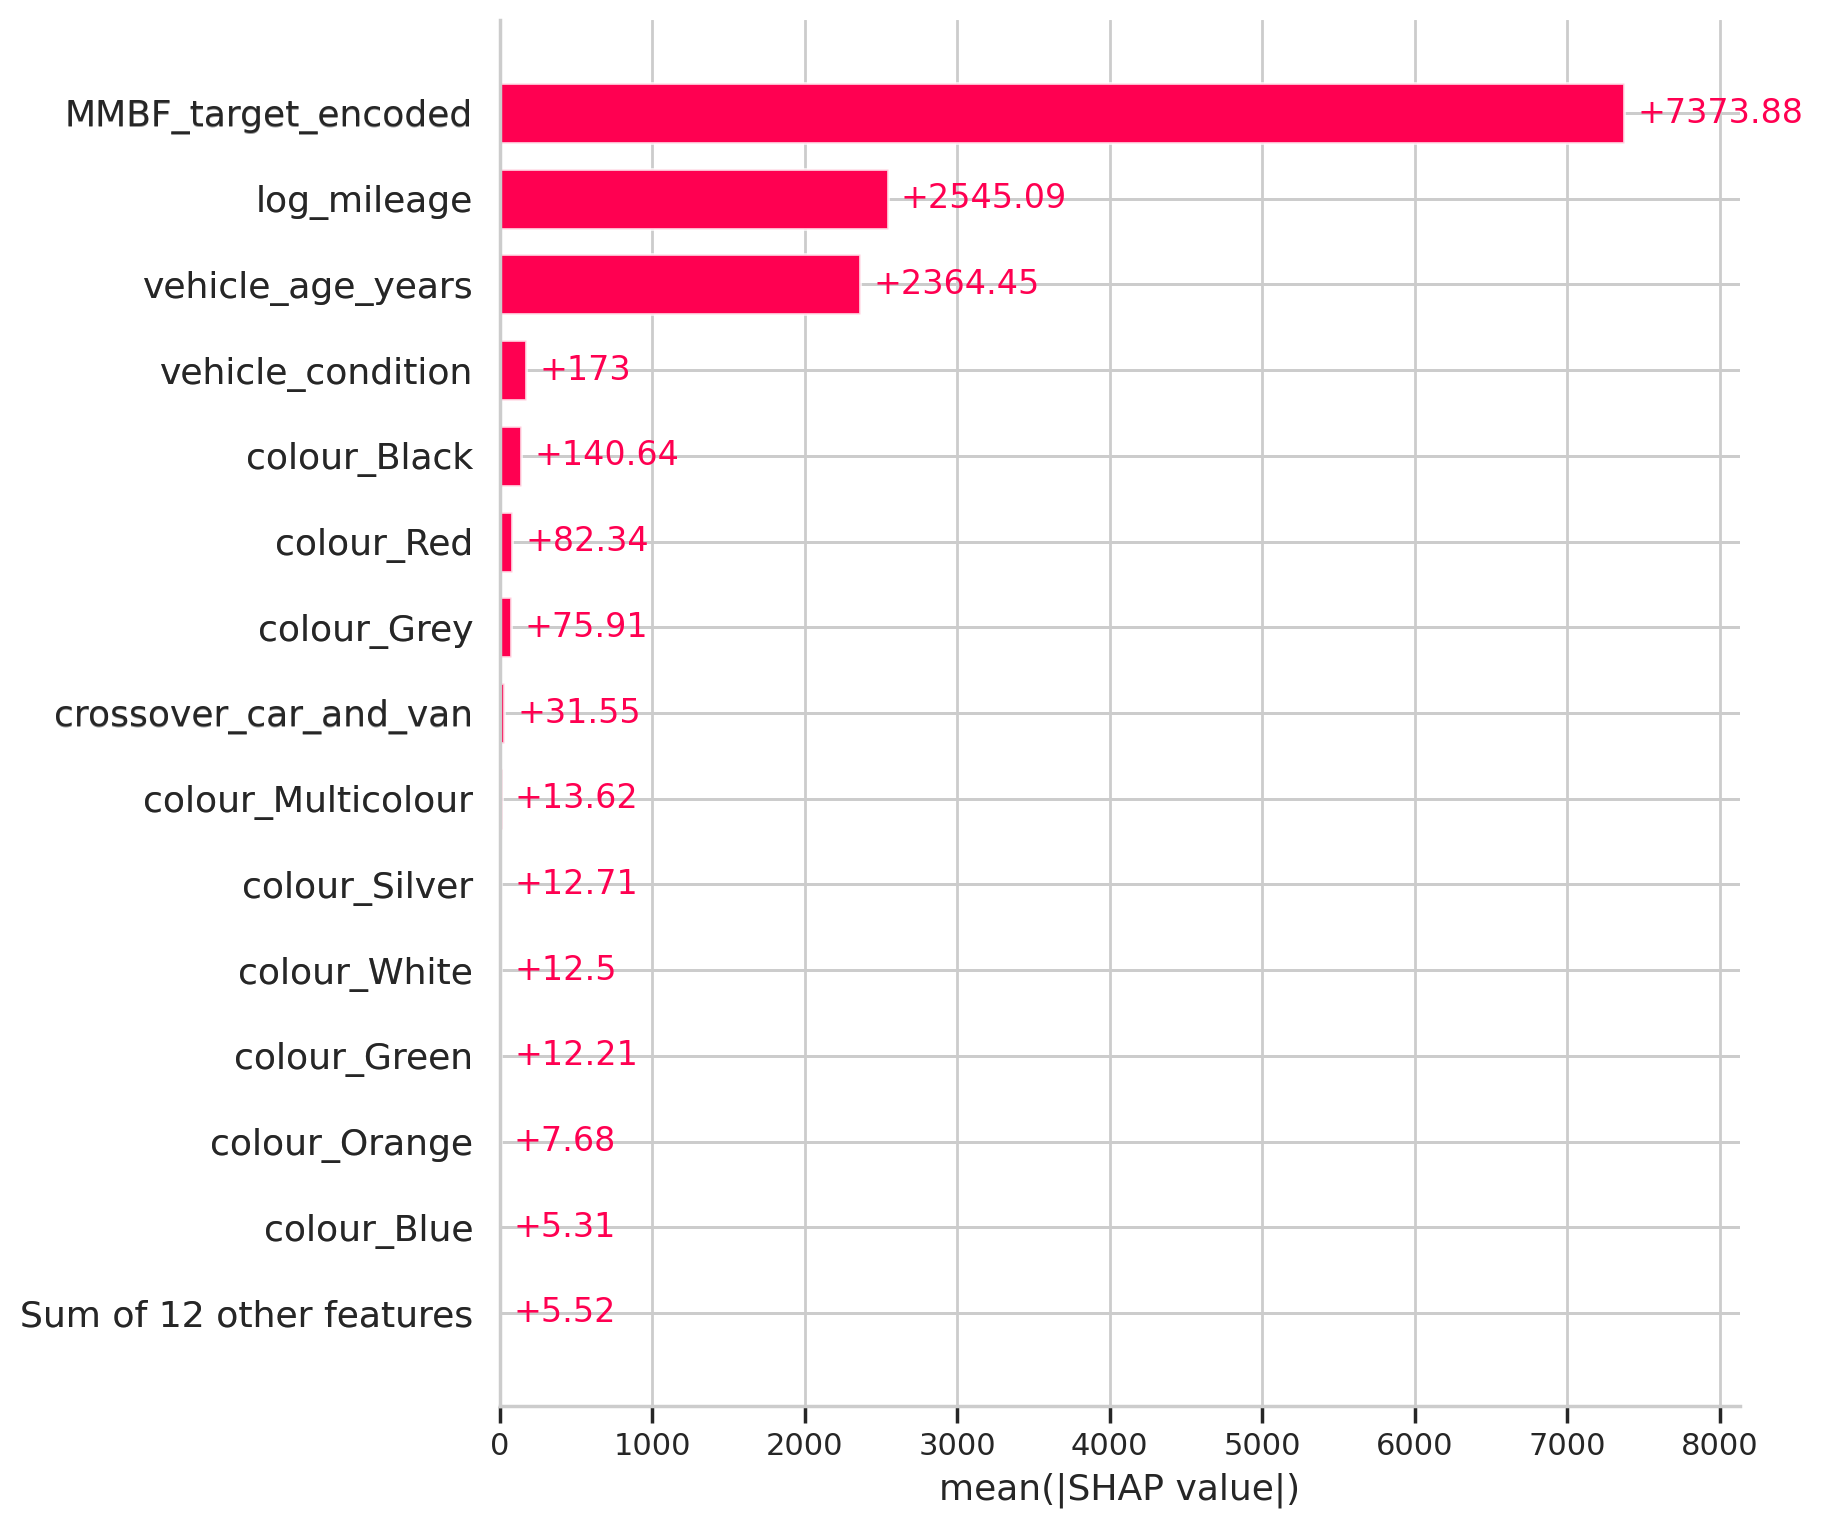

In [156]:
shap.plots.bar(shap_values, max_display=15)

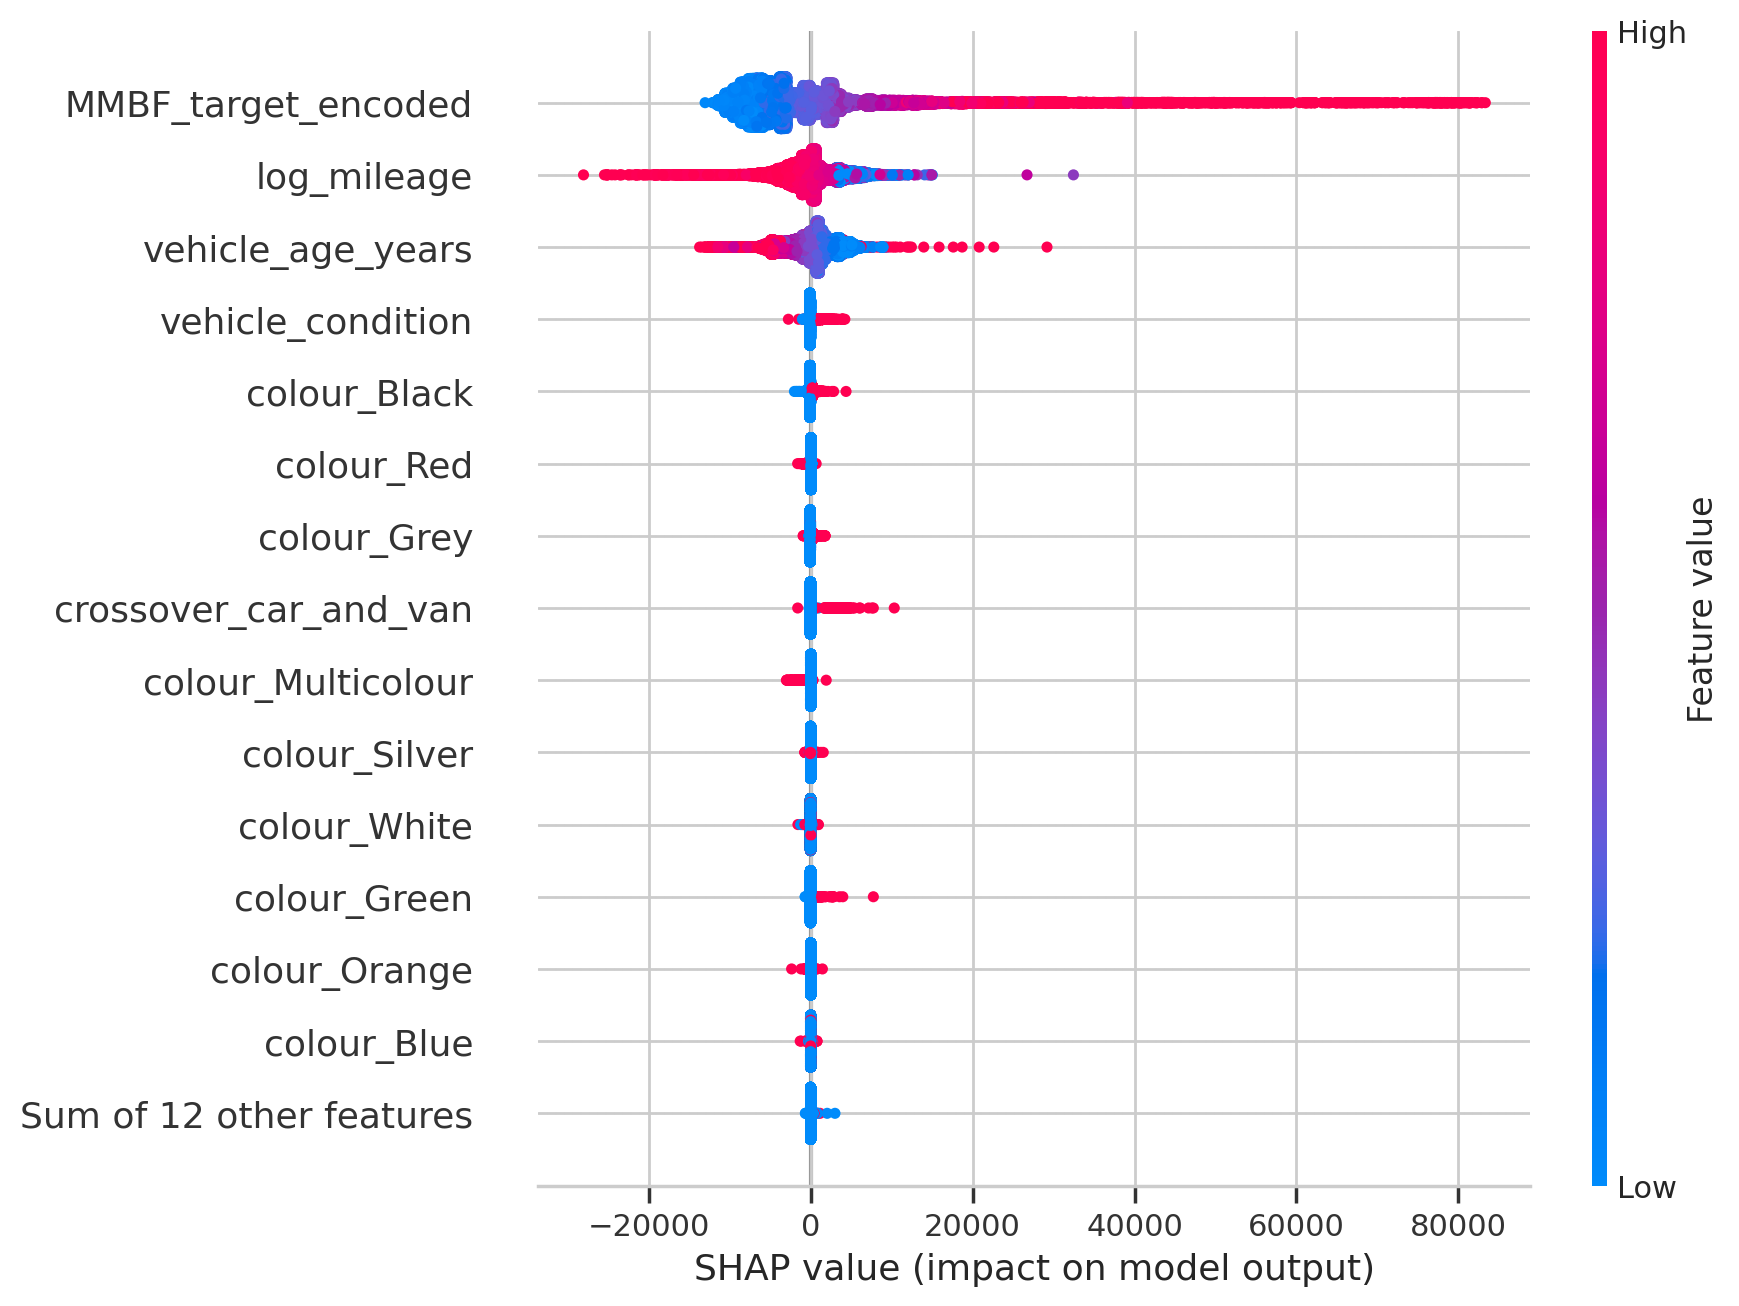

In [157]:
# more detailed view (beeswarm plot)
shap.plots.beeswarm(shap_values, max_display=15)

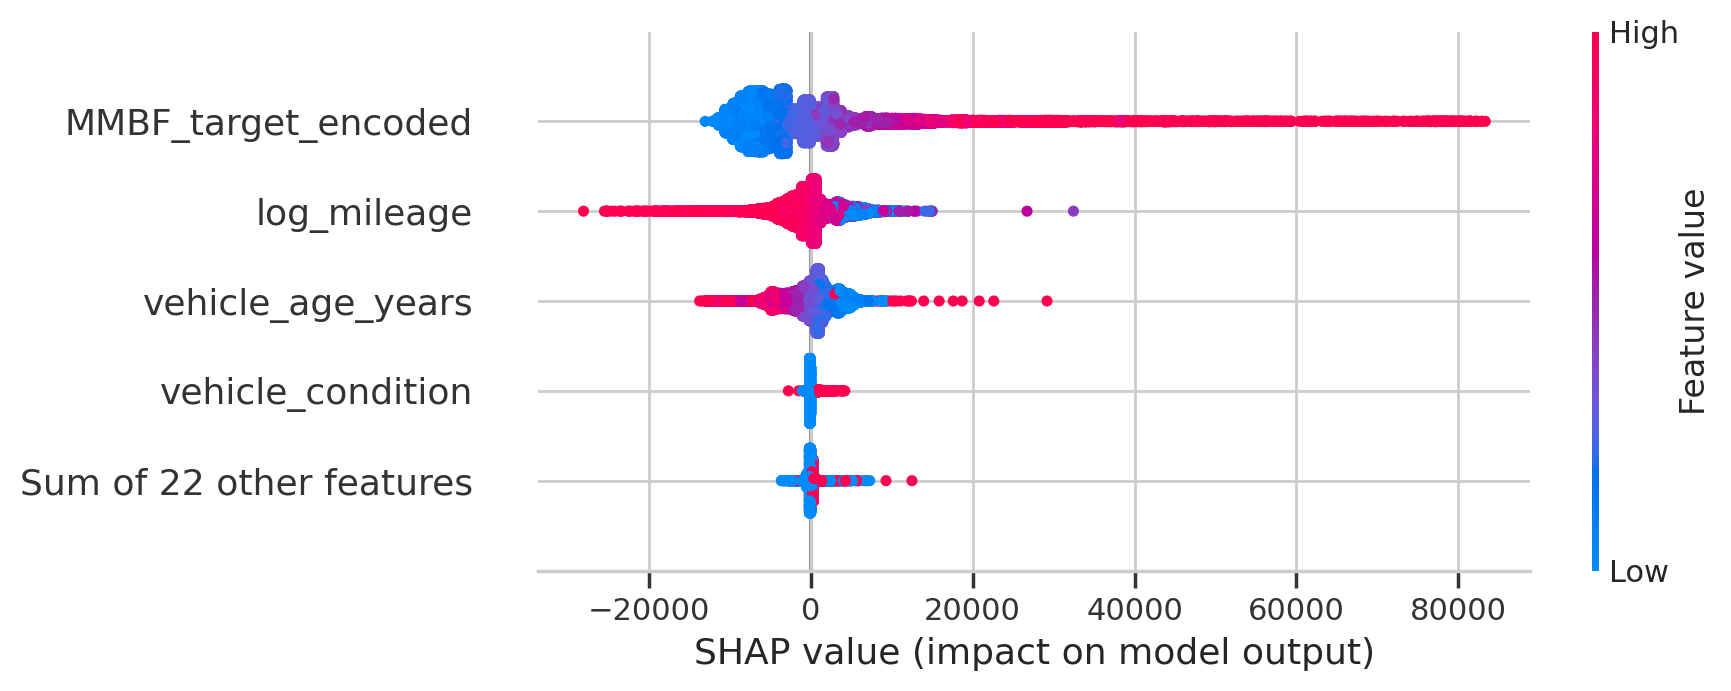

In [207]:
shap.plots.beeswarm(shap_values, max_display=5)

##task 6

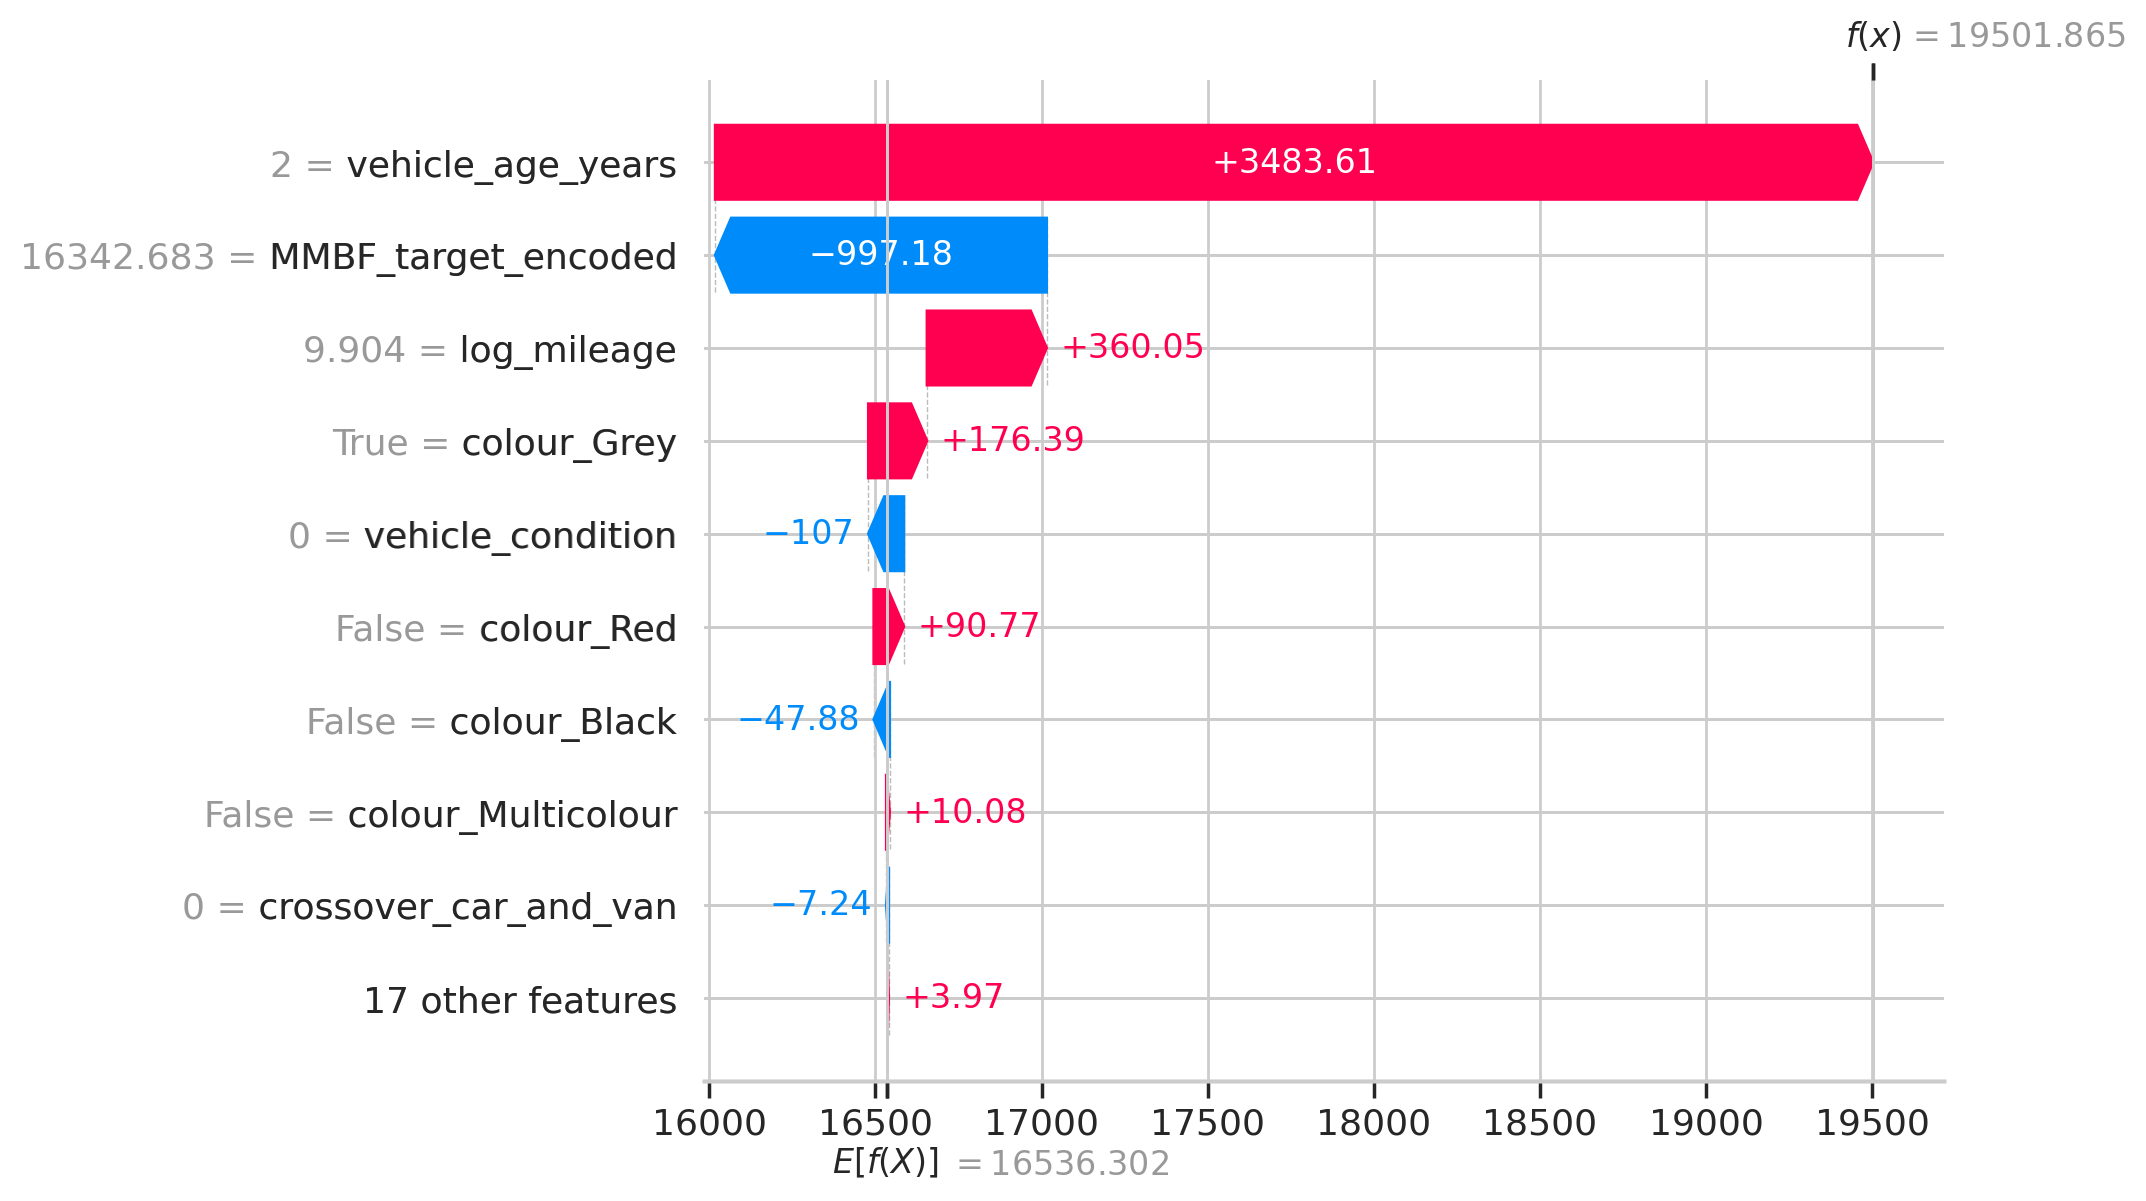

In [208]:
# pick a sample to explain (change index if u want)
sample_index = 5

# get the SHAP explanation
shap.plots.waterfall(shap_values[sample_index])



In [160]:
# show actual vs predicted just to see how close it was
sample = X_val.iloc[[sample_index]]

print("Predicted price gbr:", gbr_model.predict(sample)[0])
print("Actual price gbr:", y_val.iloc[sample_index])



Predicted price gbr: 19501.86471939203
Actual price gbr: 16390


In [161]:
# show actual vs predicted just to see how close it was
sample = X_val.iloc[[sample_index]]

print("Predicted price best rf:", best_rf.predict(sample)[0])
print("Actual price best rf:", y_val.iloc[sample_index])

Predicted price best rf: 19876.255061615102
Actual price best rf: 16390


###pdp plots

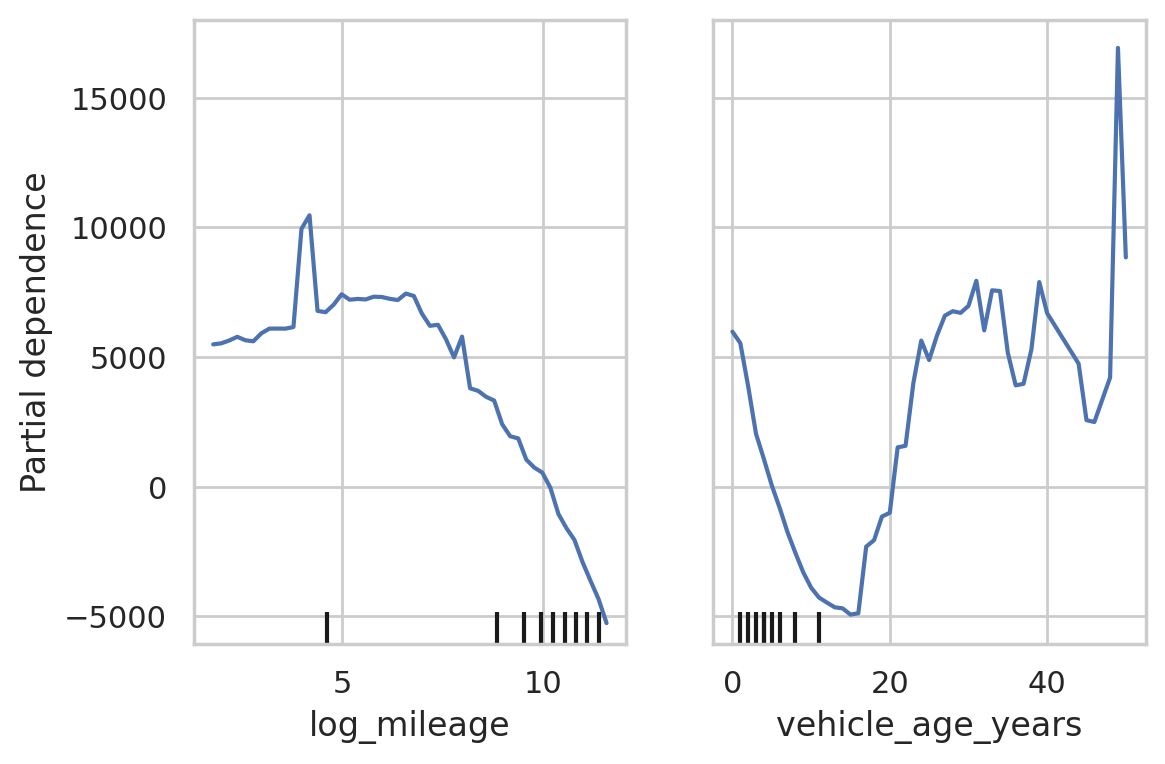

In [162]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ['log_mileage', 'vehicle_age_years']

PartialDependenceDisplay.from_estimator(
    gbr_model,
    X_val,
    features=features_to_plot,
    grid_resolution=50
)

plt.tight_layout()
plt.show()


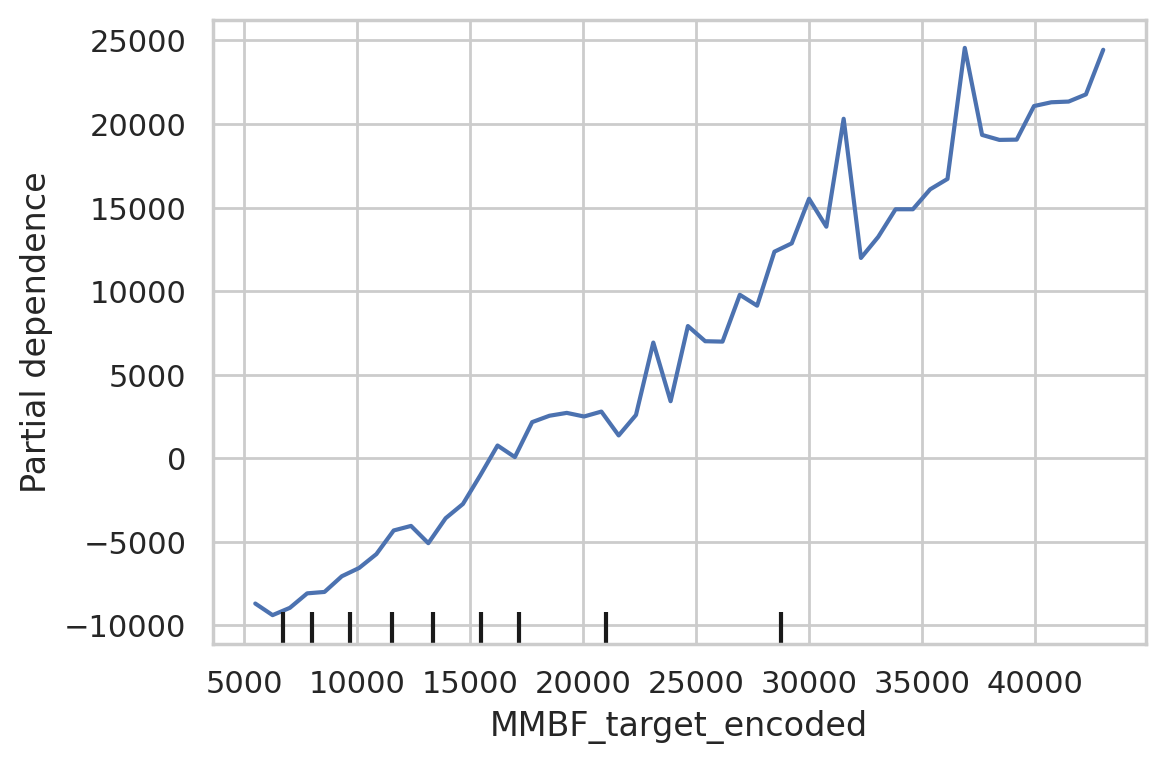

In [163]:
PartialDependenceDisplay.from_estimator(
    gbr_model,
    X_val,
    features=['MMBF_target_encoded'],
    grid_resolution=50
)
plt.tight_layout()
plt.show()

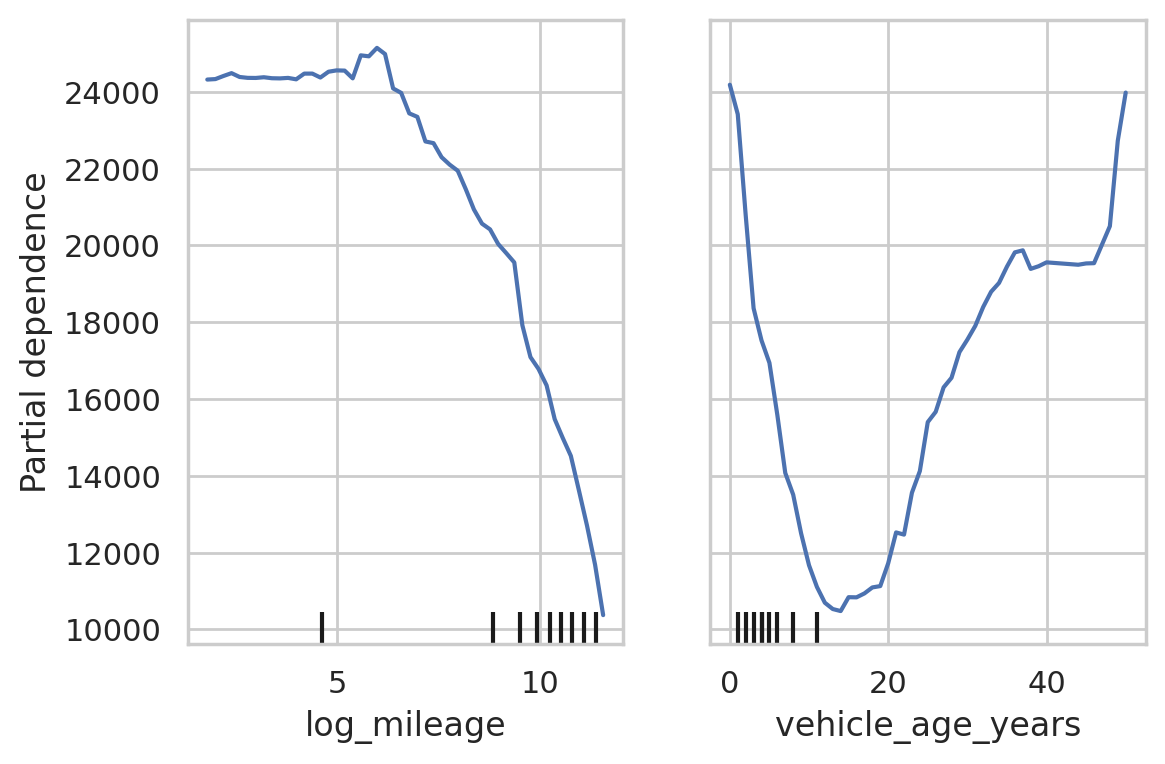

In [164]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ['log_mileage', 'vehicle_age_years']

PartialDependenceDisplay.from_estimator(
    best_rf,
    X_val,
    features=features_to_plot,
    grid_resolution=50
)

plt.tight_layout()
plt.show()

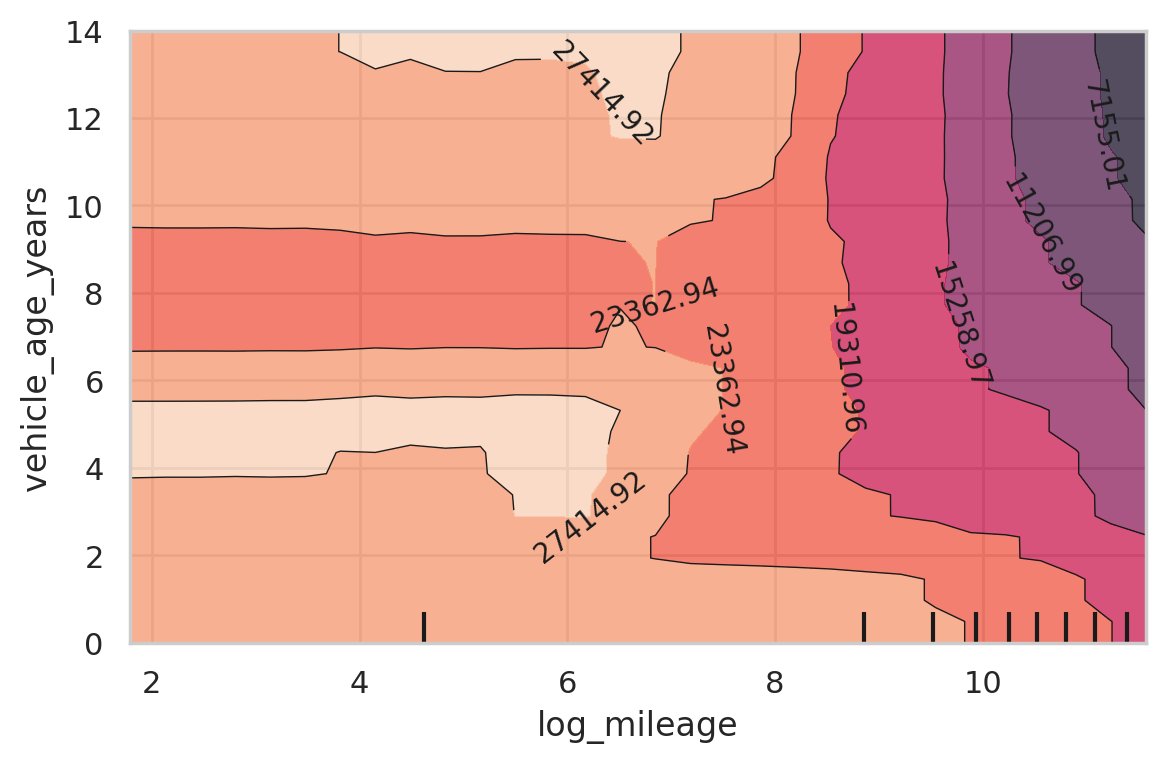

In [165]:
PartialDependenceDisplay.from_estimator(
    best_rf,
    X_val,
    features=[('log_mileage', 'vehicle_age_years')],
    grid_resolution=30
)
plt.tight_layout()
plt.show()


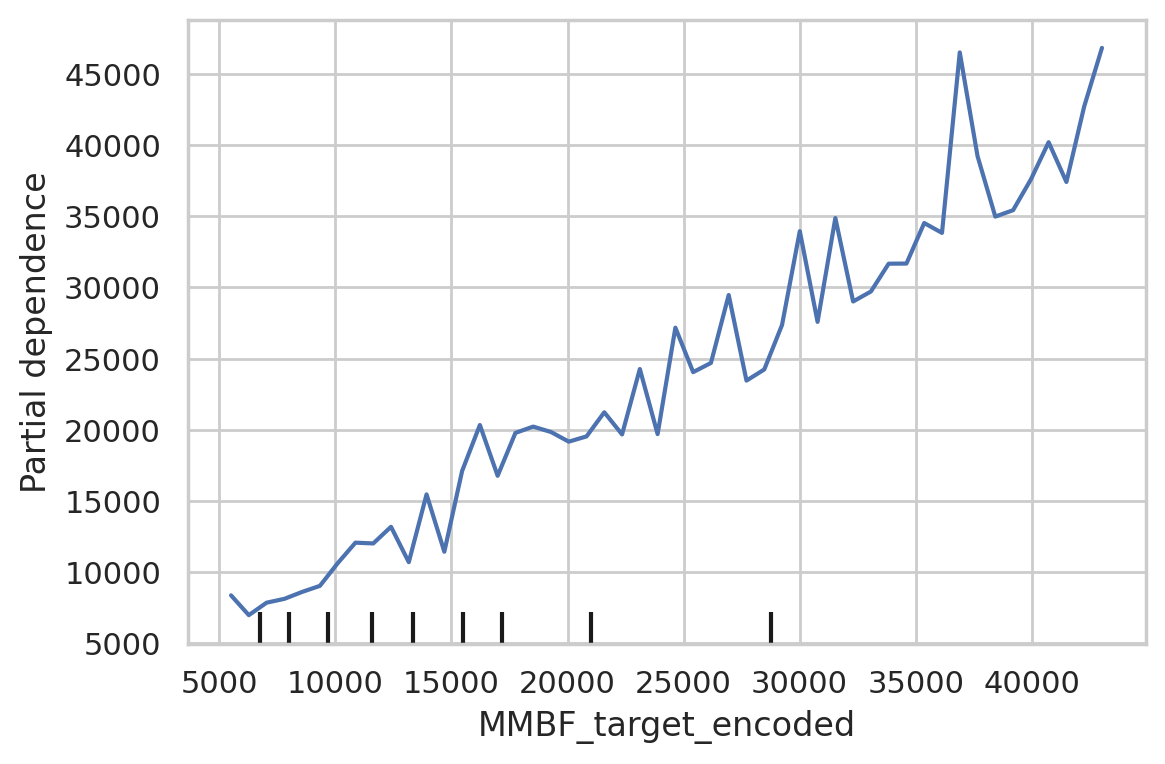

In [166]:
PartialDependenceDisplay.from_estimator(
    best_rf,
    X_val,
    features=['MMBF_target_encoded'],
    grid_resolution=50
)
plt.tight_layout()
plt.show()


##task 7 PCA

In [167]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# we need to scale features for PCA
X_scaled = StandardScaler().fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)


 checking how much variance the components actually explain

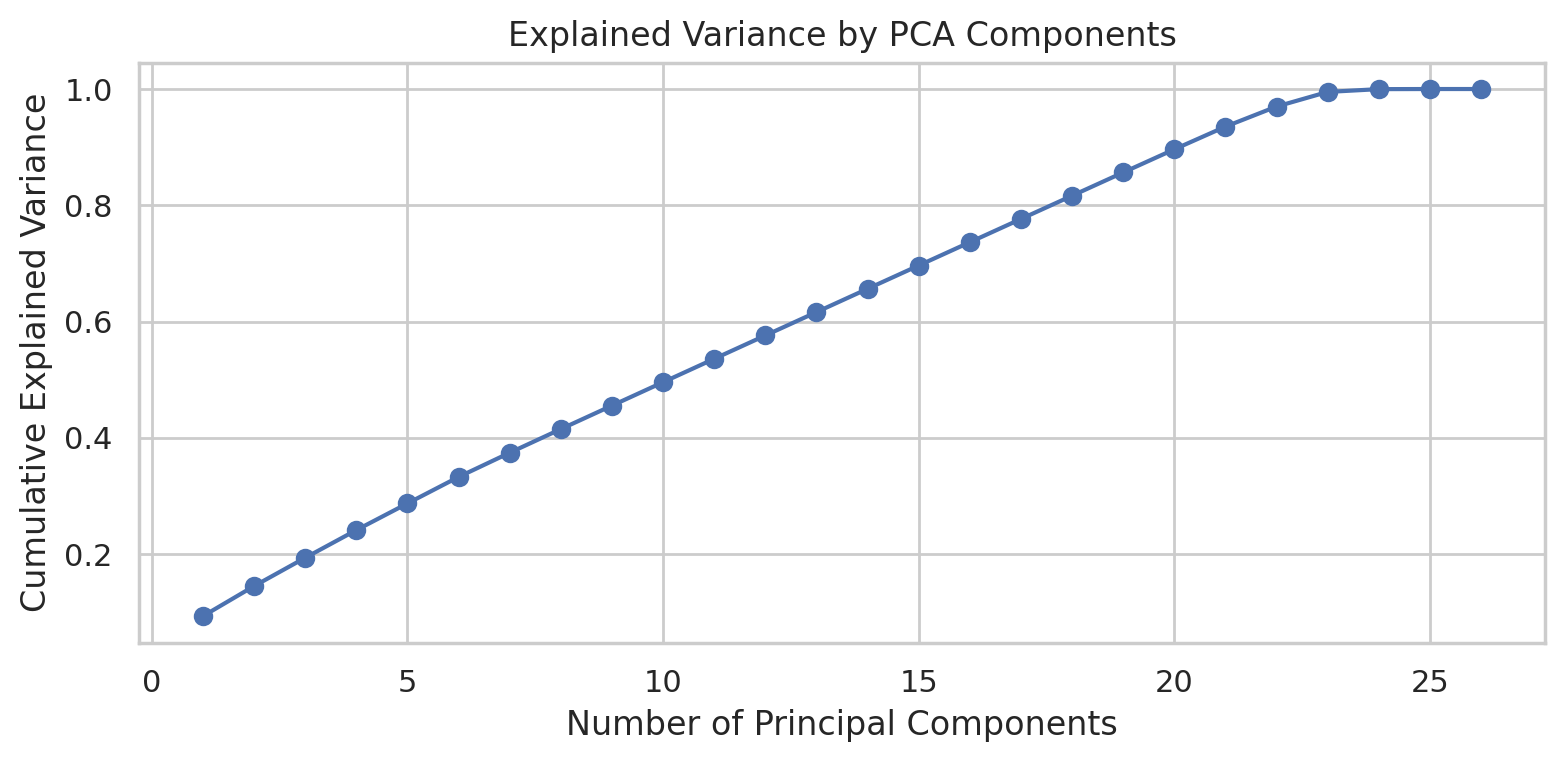

In [197]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.tight_layout()
plt.show()


In [205]:
# Step 1: Find number of components to retain 95% variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components to explain 95% variance: {n_components_95}")

# Step 2: Apply PCA with reduced dimensionality
pca_final = PCA(n_components=n_components_95)
X_reduced = pca_final.fit_transform(X_scaled)

# Step 3: Convert to NumPy array if not already
X_reduced = np.array(X_reduced)



Number of components to explain 95% variance: 22


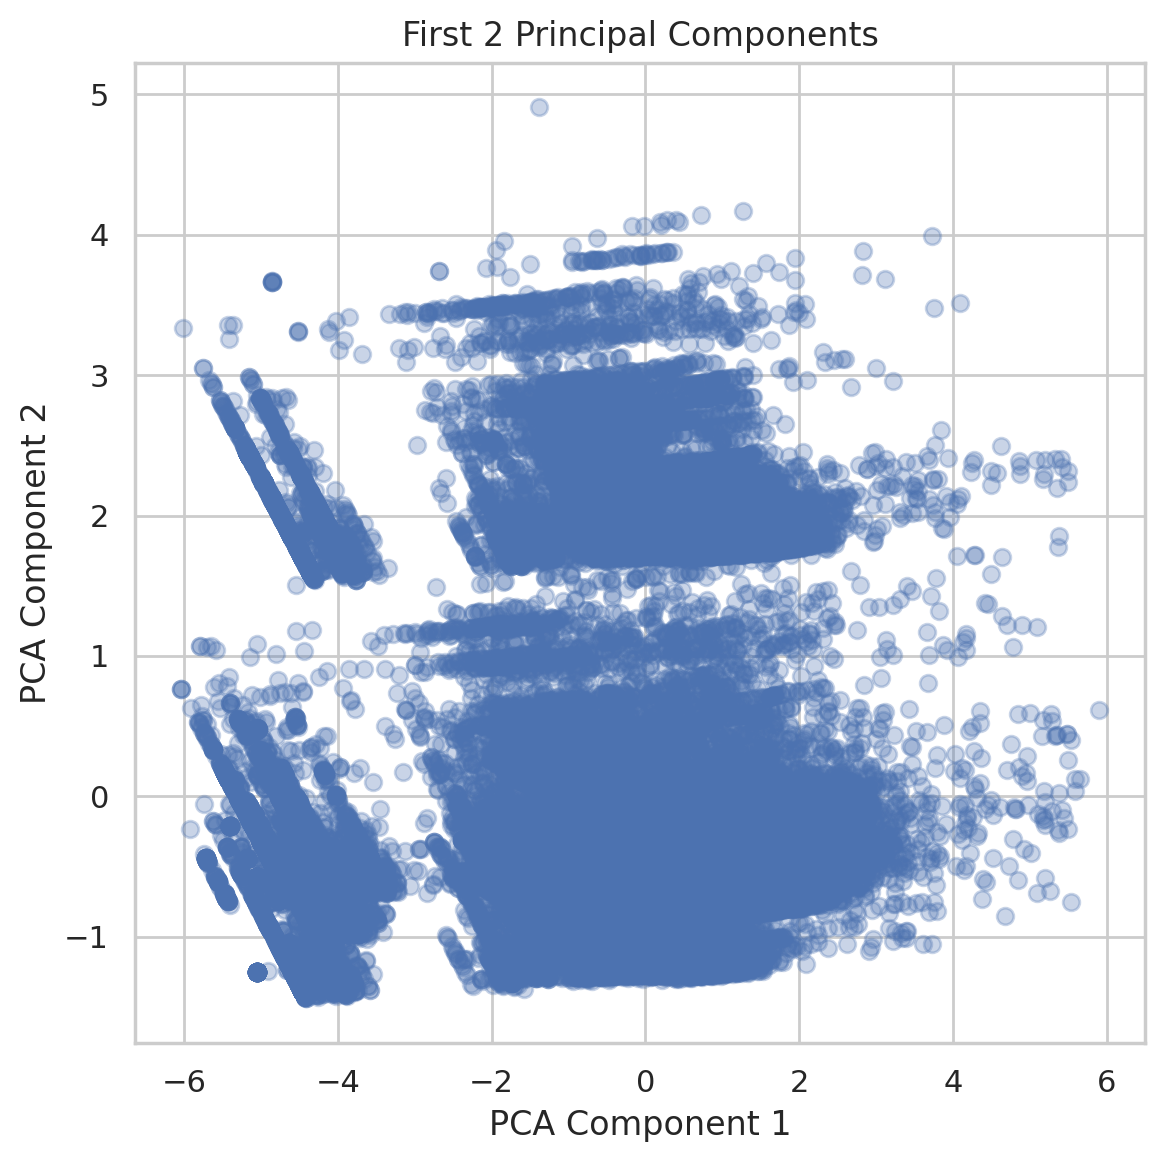

In [170]:
plt.figure(figsize=(6, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.3)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("First 2 Principal Components")
plt.tight_layout()
plt.show()


In [171]:
# plt.figure(figsize=(6, 6))
# plt.scatter(X_reduced_np[:, 0], X_reduced_np[:, 1], alpha=0.3)
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
# plt.title("First 2 Principal Components")
# plt.tight_layout()
# plt.show()


The first two PCA components reveal structure in the data, with noticeable banding that may relate to categorical variables like brand or condition. While PCA is unsupervised, this projection shows the dataset contains distinct feature-driven groupings, which could be useful for clustering or anomaly detection.”

Principal Component Analysis (PCA) was applied to the scaled dataset to explore dimensionality reduction. A cumulative variance analysis showed that X components were sufficient to explain 95% of the dataset’s variance. This dimensionality reduction could help reduce model complexity in future applications. A 2D projection using the first two components was also visualised to observe broad structure in the dataset.”

##task 8 non linear dimsenatilty reduction isomaap

In [172]:
# from sklearn.manifold import Isomap

# # using same scaled X from PCA
# isomap = Isomap(n_components=2)
# X_iso = isomap.fit_transform(X_scaled)


In [173]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import Isomap

# # Step 1: Convert to NumPy array (if needed)
# X_array = X_scaled.values if hasattr(X_scaled, 'values') else X_scaled

# # Step 2: Sample 5000 rows
# sample_idx = np.random.choice(X_array.shape[0], size=5000, replace=False)
# X_sample = X_array[sample_idx]
# y_sample = y.iloc[sample_idx].reset_index(drop=True).to_numpy()  # <== convert to plain NumPy array

# # Step 3: Run Isomap
# isomap = Isomap(n_components=2, n_neighbors=10)
# X_iso = isomap.fit_transform(X_sample)

# # Step 4: Plot with no index mismatch
# plt.figure(figsize=(8, 6))
# plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y_sample, cmap='viridis', alpha=0.6)
# plt.colorbar(label='Price')
# plt.title("Isomap Projection (2D)")
# plt.xlabel("Component 1")
# plt.ylabel("Component 2")
# plt.tight_layout()
# plt.show()


In [174]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import Isomap

# # Step 1: Convert to NumPy (if needed)
# X_array = X_scaled.values if hasattr(X_scaled, 'values') else X_scaled

# # Step 2: Sample 5000 rows safely
# sample_idx = np.random.choice(X_array.shape[0], size=5000, replace=False)
# X_sample = X_array[sample_idx]
# y_sample = y.iloc[sample_idx].to_numpy()  # Pure NumPy array

# # Step 3: Run Isomap
# isomap = Isomap(n_components=2, n_neighbors=10)
# X_iso = isomap.fit_transform(X_sample)

# # Step 4: Plot Isomap projection
# plt.figure(figsize=(8, 6))
# plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y_sample, cmap='viridis', alpha=0.6)
# plt.colorbar(label='Price')
# plt.title("Isomap Projection (2D)")
# plt.xlabel("Component 1")
# plt.ylabel("Component 2")
# plt.tight_layout()
# plt.show()


In [175]:
# print("X_iso:", type(X_iso), X_iso.shape)
# print("y_sample:", type(y_sample), y_sample.shape)


In [176]:
# import numpy as np
# from sklearn.manifold import Isomap
# import matplotlib.pyplot as plt

# # Make sure X_scaled is a NumPy array
# X_array = X_scaled.values if hasattr(X_scaled, 'values') else X_scaled

# # Sample 5000 rows
# sample_idx = np.random.choice(X_array.shape[0], size=5000, replace=False)
# X_sample = X_array[sample_idx]
# y_sample = y.iloc[sample_idx]  # for colouring




In [177]:
# # Run Isomap
# isomap = Isomap(n_components=2, n_neighbors=10)
# X_iso = isomap.fit_transform(X_sample)
# y_sample = y.iloc[sample_idx].reset_index(drop=True)

In [178]:
# ### plot it – price-based colour to see if structure matches target
# plt.figure(figsize=(8, 6))
# plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y_sample, cmap='viridis', alpha=0.6)
# plt.colorbar(label='Price')
# plt.title("Isomap Projection (2D)")
# plt.xlabel("Component 1")
# plt.ylabel("Component 2")
# plt.tight_layout()
# plt.show()


plot isomap output color by price maybe

In [179]:
import numpy as np
from sklearn.manifold import Isomap

# Ensure X_scaled is a NumPy array
X_array = X_scaled.values if hasattr(X_scaled, 'values') else X_scaled

# Sample 5000 rows
sample_idx = np.random.choice(X_array.shape[0], size=5000, replace=False)
X_sample = X_array[sample_idx]
y_sample = y.iloc[sample_idx].to_numpy()  # Convert y to plain NumPy array

# Run Isomap
isomap = Isomap(n_components=2, n_neighbors=10)
X_iso = isomap.fit_transform(X_sample)  # This is already a NumPy array



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 16 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-p

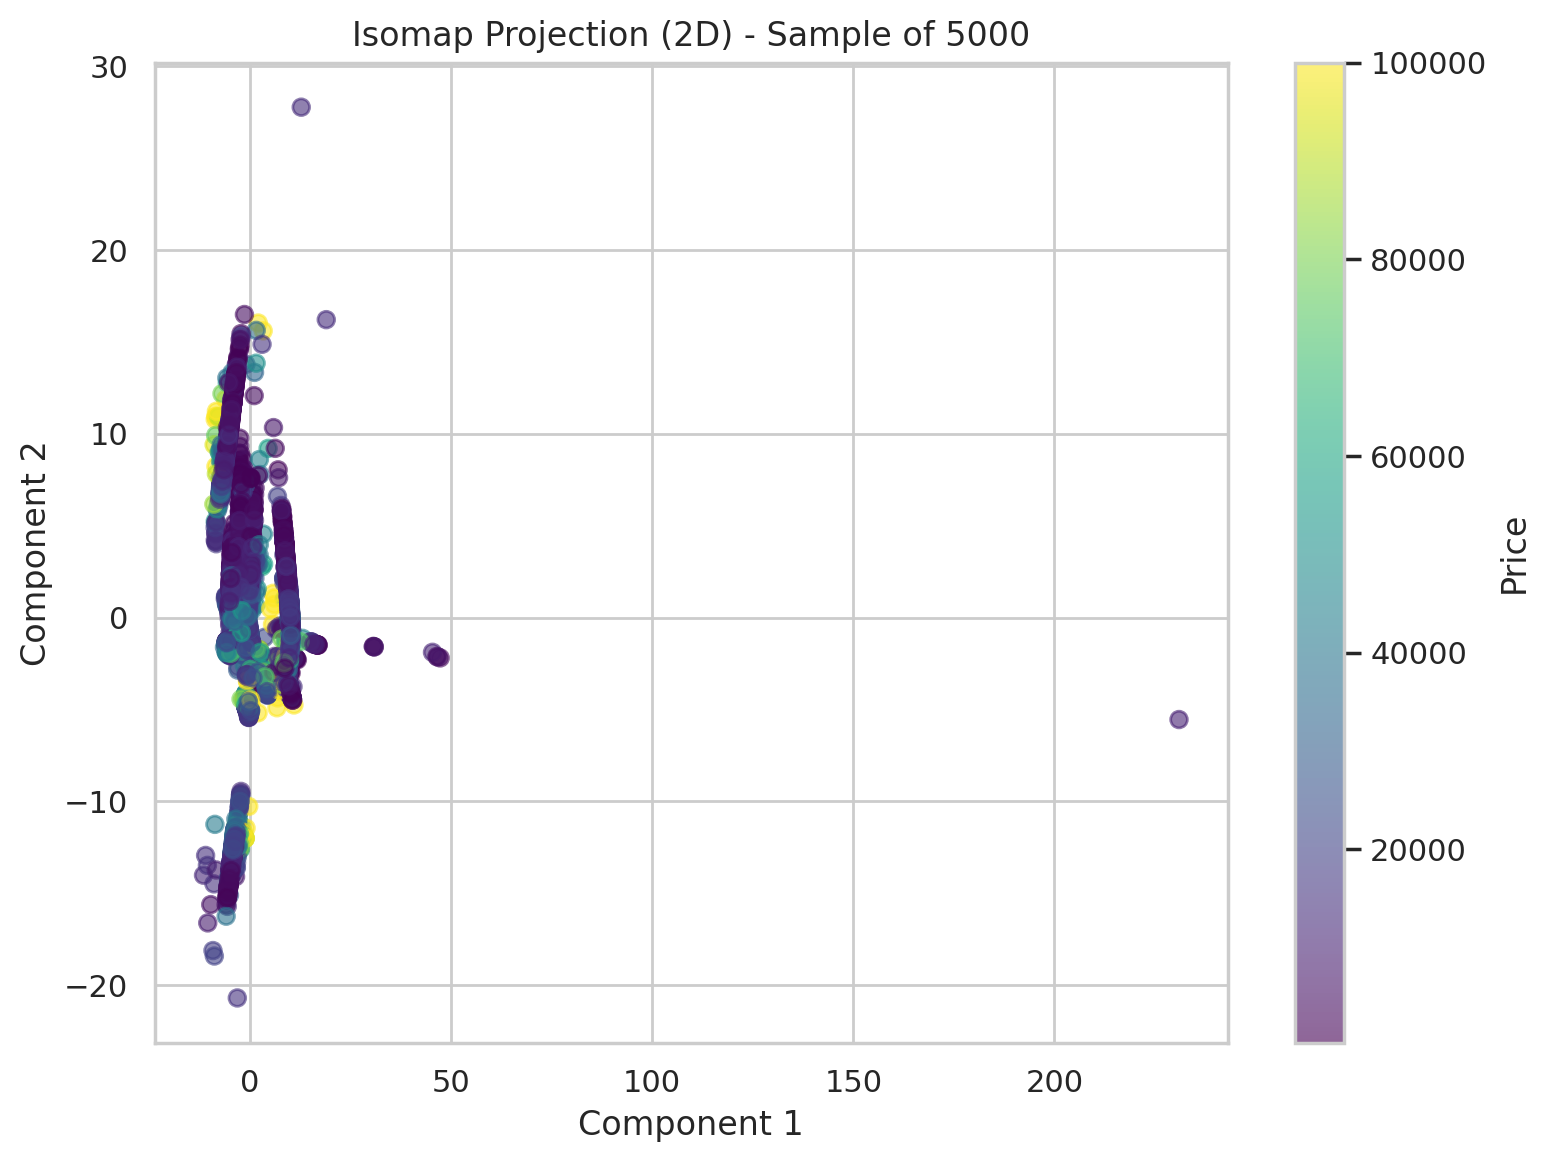

In [180]:
import matplotlib.pyplot as plt

# Convert DataFrame to NumPy array to allow slicing
X_iso = X_iso.to_numpy()

# Now safely plot
plt.figure(figsize=(8, 6))
plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y_sample, cmap='viridis', alpha=0.6)
plt.colorbar(label='Price')
plt.title("Isomap Projection (2D) - Sample of 5000")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()




“A 2D Isomap projection of a 5,000-sample subset revealed non-linear structure in the feature space. Curved manifolds and dense clusters appeared in the lower-left, with price gradients confirming meaningful structure. This validates the presence of non-linear relationships and supports the use of non-linear models like Random Forest and Gradient Boosting.”

In [181]:
print("X_iso type:", type(X_iso))
print("X_iso shape:", X_iso.shape)
print("y_sample type:", type(y_sample))
print("y_sample shape:", y_sample.shape)


X_iso type: <class 'numpy.ndarray'>
X_iso shape: (5000, 2)
y_sample type: <class 'numpy.ndarray'>
y_sample shape: (5000,)


In [182]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_iso)


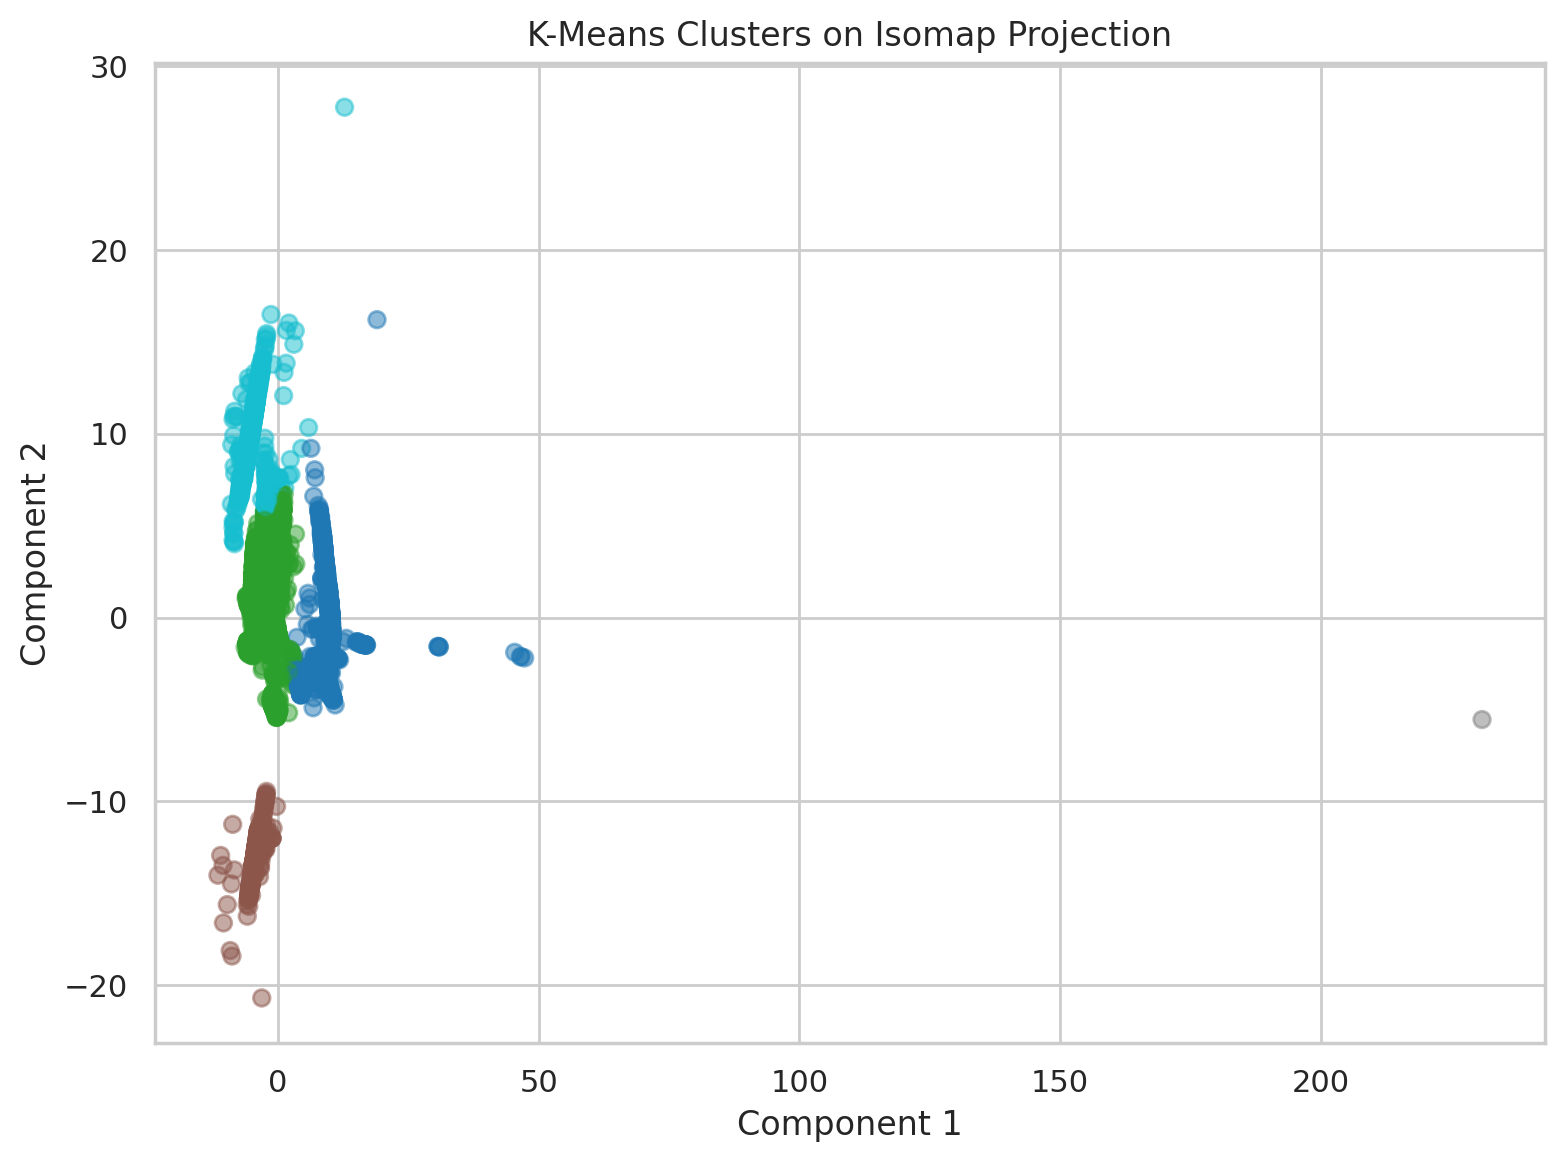

In [183]:
plt.figure(figsize=(8, 6))
plt.scatter(X_iso[:, 0], X_iso[:, 1], c=clusters, cmap='tab10', alpha=0.5)
plt.title("K-Means Clusters on Isomap Projection")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()


In [184]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_iso, clusters)
print("Silhouette Score:", score)


Silhouette Score: 0.6495901986400795


##outlier detection -nahhhh

In [185]:
from sklearn.ensemble import IsolationForest

# Use scaled full dataset (not sample)
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
outlier_preds = iso_forest.fit_predict(X_scaled)  # -1 for outliers, 1 for inliers


In [186]:
# Attach labels to your original dataset (e.g. AT_sampled)
AT_sampled['outlier'] = outlier_preds


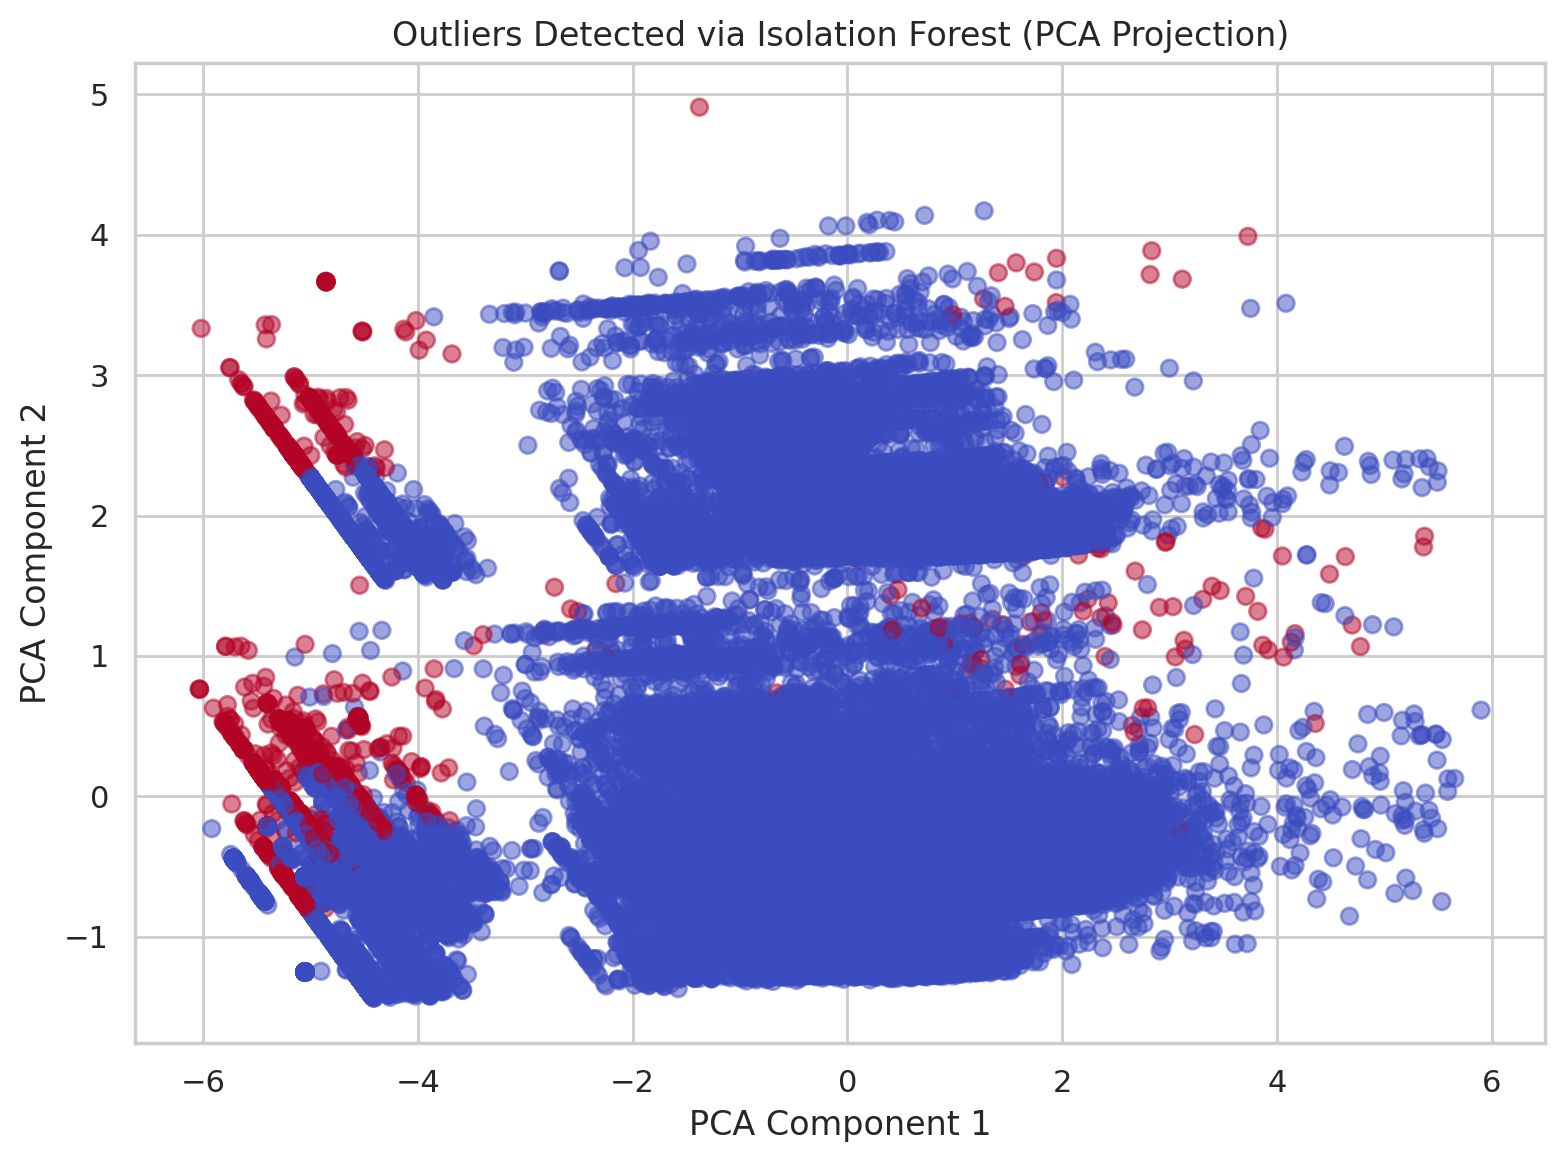

In [187]:
import matplotlib.pyplot as plt
X_pca = X_pca.to_numpy()
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=(outlier_preds == -1), cmap='coolwarm', alpha=0.5)
plt.title("Outliers Detected via Isolation Forest (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


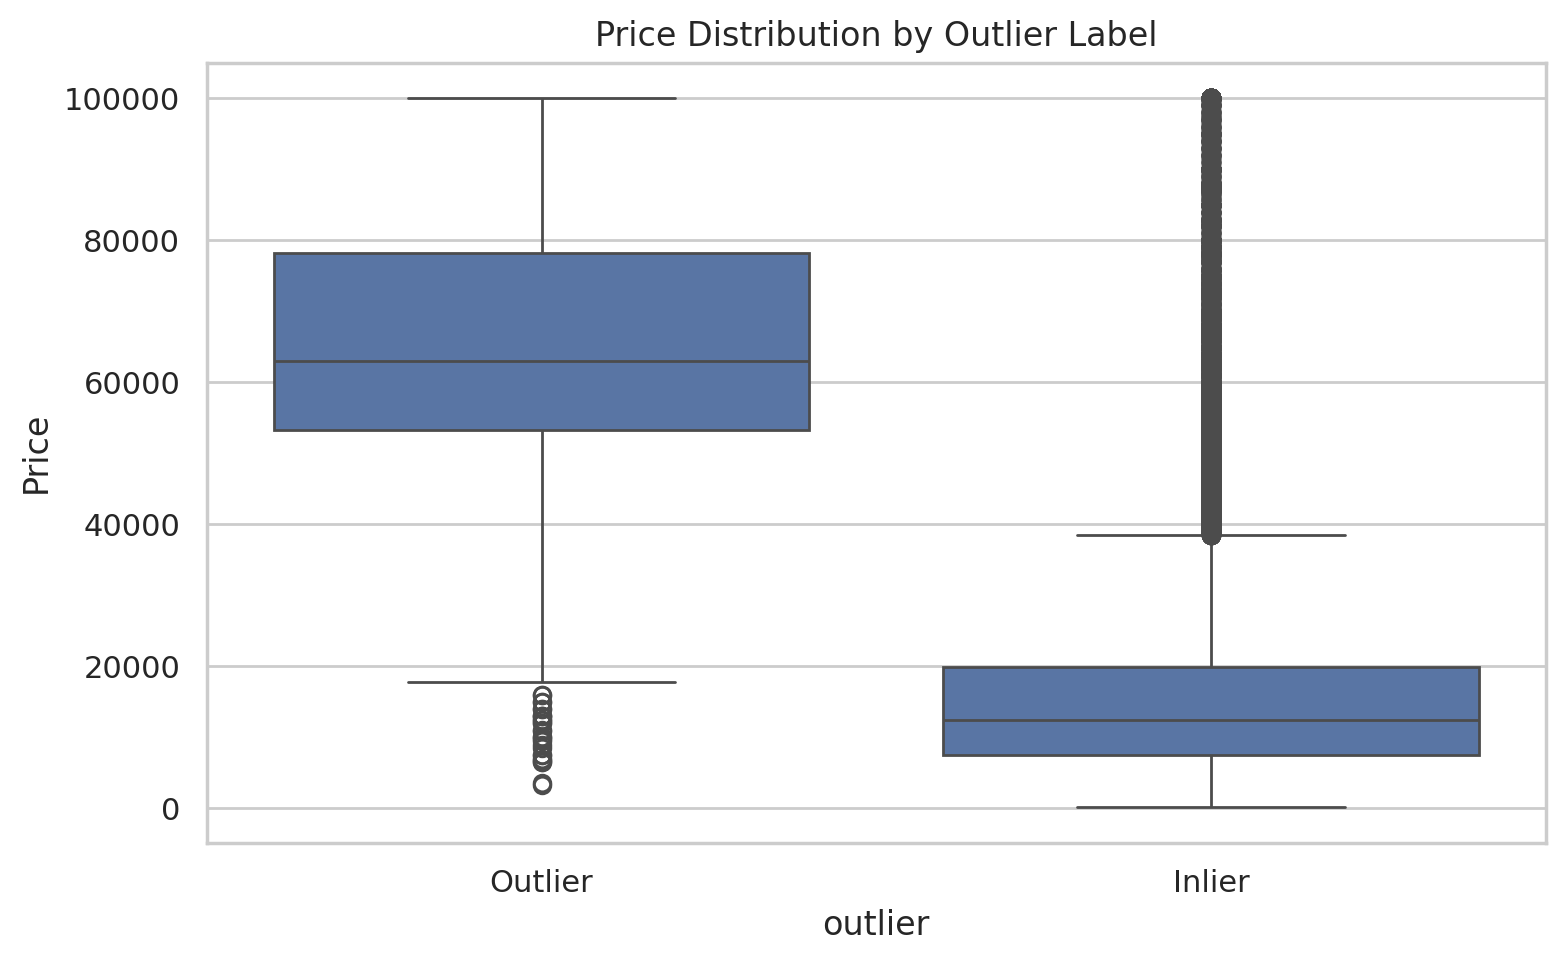

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add outlier column to main dataset if not done
AT_sampled['outlier'] = outlier_preds

plt.figure(figsize=(8, 5))
sns.boxplot(x='outlier', y='price_clipped', data=AT_sampled)
plt.xticks([0, 1], ['Outlier', 'Inlier'])
plt.title("Price Distribution by Outlier Label")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


In [189]:
# Count of outliers
print(AT_sampled['outlier'].value_counts())

# Typical outlier profile
outliers = AT_sampled[AT_sampled['outlier'] == -1]
print(outliers.describe())


outlier
 1    159195
-1      1607
Name: count, dtype: int64
       price_clipped  vehicle_condition  log_mileage  MMBF_target_encoded  \
count        1607.00            1607.00      1607.00              1607.00   
mean        64935.79               0.94         1.37             55163.04   
std         19039.28               0.25         2.57             13880.56   
min          3250.00               0.00         0.00              8695.00   
25%         53292.50               1.00         0.00             49259.70   
50%         62995.00               1.00         0.00             52640.91   
75%         78152.50               1.00         2.40             61990.77   
max        100000.00               1.00        12.36            100000.00   

       vehicle_age_years  crossover_car_and_van  outlier  
count            1607.00                1607.00  1607.00  
mean                1.85                   0.04    -1.00  
std                 7.90                   0.20     0.00  
min       

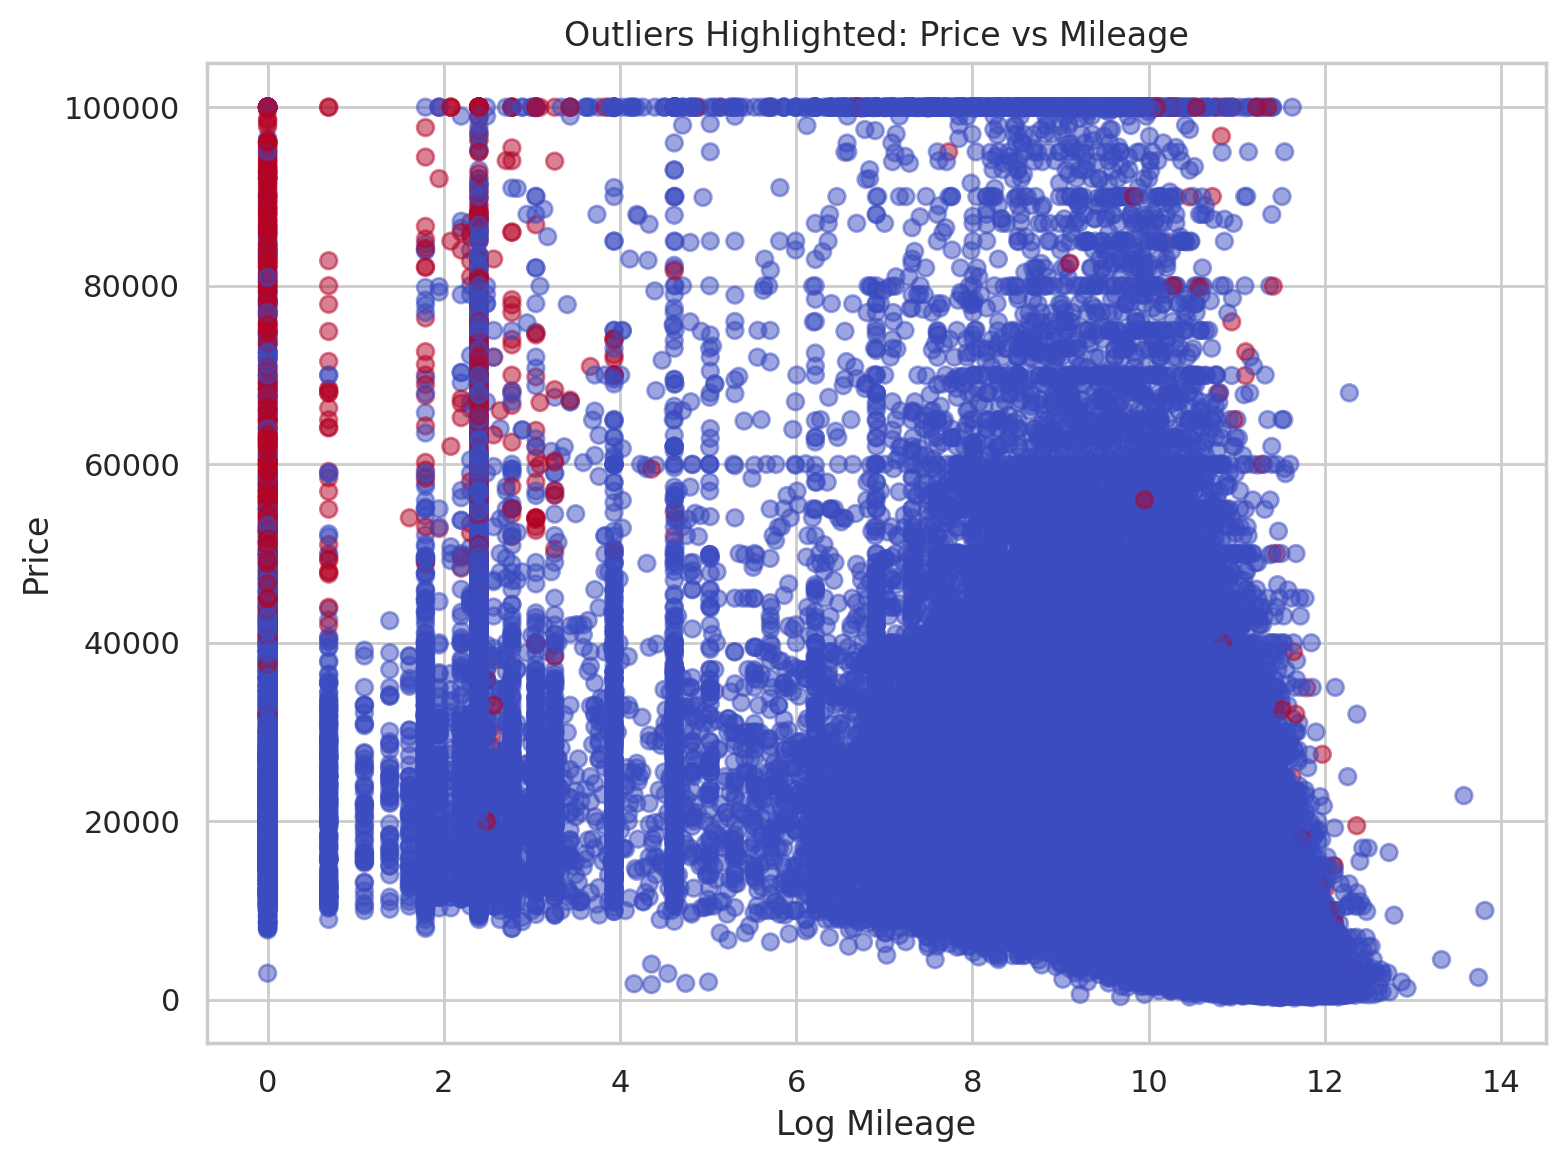

In [190]:
plt.figure(figsize=(8, 6))
plt.scatter(AT_sampled['log_mileage'], AT_sampled['price_clipped'],
            c=(AT_sampled['outlier'] == -1), cmap='coolwarm', alpha=0.5)
plt.xlabel("Log Mileage")
plt.ylabel("Price")
plt.title("Outliers Highlighted: Price vs Mileage")
plt.tight_layout()
plt.show()


##task 9

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Pick a few meaningful continuous features
poly_features = ['log_mileage', 'vehicle_age_years', 'MMBF_target_encoded']

X_poly = AT_sampled[poly_features]
y_poly = AT_sampled['price_clipped']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)


In [192]:
# Use degree 2 (you can ty 3 latr)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)


In [193]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred = model.predict(X_val_poly)

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred) ** 0.5
r2 = r2_score(y_val, y_pred)

print("Polynomial Regression MAE:", mae)
print("Polynomial Regression RMSE:", rmse)
print("Polynomial Regression R² Score:", r2)


Polynomial Regression MAE: 3514.1000646879324
Polynomial Regression RMSE: 5703.050122575196
Polynomial Regression R² Score: 0.8565328738070547


MAE and RMSE are substantially worse than your earlier tree models (which had MAE ~2200–2700)

R² of 0.86 is still decent, but lower than the ~0.91–0.93 range of Random Forest or Gradient Boosting

This confirms that tree models handled the data’s complexity and non-linear interactions better than this polynomial approximation

###bsline LR to compare

In [198]:
# Use same traing/val data (X_train, X_val from earlier, untrasformed)
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

baseline_pred = baseline_model.predict(X_val)

# Metrics
baseline_mae = mean_absolute_error(y_val, baseline_pred)
baseline_rmse = mean_squared_error(y_val, baseline_pred) ** 0.5
baseline_r2 = r2_score(y_val, baseline_pred)

print("Linear Regression MAE:", baseline_mae)
print("Linear Regression RMSE:", baseline_rmse)
print("Linear Regression R² Score:", baseline_r2)


Linear Regression MAE: 3883.8262115038433
Linear Regression RMSE: 6301.649256661109
Linear Regression R² Score: 0.8248353457288695


Polynomial regression outperforms the baseline linear model across all metrics.

However, both are clearly weaker than your Random Forest and Gradient Boosting models (MAE ~2200–2700).

This confirms that while polynomial expansion improves linear regression, it still can’t match the non-linear flexibility of ensemble methods.

##task 10

In [199]:
# Use same scaled feature set
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add to DataFrame
AT_sampled['cluster_label'] = cluster_labels


In [200]:
#Random Forest Regressor as the evaluation model (fast + strong).

# 1. Features without cluster label
X1 = AT_sampled.drop(columns=['price_clipped', 'cluster_label'])
X2 = AT_sampled.drop(columns=['price_clipped'])

y = AT_sampled['price_clipped']

# Train/test split
X1_train, X1_val, y_train, y_val = train_test_split(X1, y, test_size=0.2, random_state=42)
X2_train, X2_val, _, _ = train_test_split(X2, y, test_size=0.2, random_state=42)


In [201]:
# Train model without cluster
model1 = RandomForestRegressor(n_estimators=100, random_state=42)
model1.fit(X1_train, y_train)
pred1 = model1.predict(X1_val)

In [202]:
# Train model with cluster
model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(X2_train, y_train)
pred2 = model2.predict(X2_val)

In [203]:
 #Evaluate both
def print_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

print_metrics("Without Clustering", y_val, pred1)
print_metrics("With Clustering", y_val, pred2)

Without Clustering - MAE: 2167.92, RMSE: 3914.37, R²: 0.932
With Clustering - MAE: 2170.01, RMSE: 3925.10, R²: 0.932
